# Notebook report:
This notebook follows the **feature identification / representation analysis** part of the methodology (closest to **SAE-based analysis**, but implemented as a **linear probe** rather than training an SAE). It tests whether **a small set of attention heads** contains a linearly-decodable signal for **“number focus / number-ness”** during CODI’s latent-thought steps. It does this in three stages:

- **Phase 1: Collect latent-step signals on GSM8K**
  - Runs CODI on the GSM8K test set and iterates through the **latent thought steps** (typically 6).
  - For each latent step, logs:
    - **Attention weights** for every layer/head (saved as `gsm8k_attention_weights.pt`)
    - The model’s **intermediate top-k decoded tokens** at each latent step (saved in `gsm8k_phase1_data_collection.json`)
  - Also produces an overall GSM8K accuracy for the run.

- **Phase 2: Build probe features + labels**
  - Flattens the dataset into per-latent examples (`#questions × #latents`).
  - Constructs a feature matrix from attention statistics for:
    - a **hand-picked set of heads** → `probe_features_top.npy`
    - multiple **random head sets** → `probe_features_rand_*.npy`
  - Builds the target label `probe_labels.npy` as a scalar “number-ness” score per latent step (derived from the intermediate decoded outputs).

- **Phase 3: Train and evaluate the linear probe**
  - Fits a **ridge regression** model to predict the number-ness label from the hand-picked head features.
  - Runs many trials with randomly sampled head sets to form a baseline distribution.
  - Reports:
    - MSE for your selected heads
    - mean random MSE
    - percentile rank vs random
  - Saves a histogram comparison plot: `probe_mse_static_features.png`

In [2]:
import logging
import math
import re
import os
from dataclasses import dataclass, field
from typing import Optional

import torch
import transformers
from torch.nn import functional as F
import json

from peft import PeftModel, LoraConfig, TaskType
from datasets import load_dataset
from safetensors.torch import load_file

import numpy as np

from src.model import CODI, ModelArguments, DataArguments as OriginalDataArguments, TrainingArguments

@dataclass
class DataArguments(OriginalDataArguments):
    data_path: Optional[str] = field(
        default=None, metadata={"help": "(Unused) Path to the local training or evaluation file."}
    )

do_print = True
probe_topk = 5
test_attention = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

captured_attentions = []

def get_attention_hook(module, input, output):
    if isinstance(output, tuple) and len(output) > 1 and output[1] is not None:
        attn = None

        if len(output) >= 3 and torch.is_tensor(output[2]):
            attn = output[2]
        elif torch.is_tensor(output[-1]):
            attn = output[-1]

        if attn is not None:
            captured_attentions.append(attn.detach().cpu())

def extract_answer_number(sentence: str) -> float:
    sentence = sentence.replace(',', '')
    pred = [s for s in re.findall(r'-?\d+\.?\d*', sentence)]
    if not pred:
        return float('inf')
    return float(pred[-1])

def compute_accuracy(gold: list, pred: list):
    acc = sum(p == g for p, g in zip(pred, gold))
    return acc / len(gold)

def evaluation(model_args, data_args, training_args):
    task_type = TaskType.CAUSAL_LM
    target_modules = ["c_attn", "c_proj", "c_fc"]
    lora_config = LoraConfig(
        task_type=task_type,
        inference_mode=False,
        r=model_args.lora_r,
        lora_alpha=model_args.lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
        init_lora_weights=True,
    )

    model = CODI(model_args, training_args, lora_config)

    try:
        state_dict = load_file(os.path.join(model_args.ckpt_dir, "model.safetensors"))
    except Exception:
        state_dict = torch.load(os.path.join(model_args.ckpt_dir, "pytorch_model.bin"))
    model.load_state_dict(state_dict, strict=False)
    model.codi.tie_weights()

    for layer in model.codi.transformer.h:
        layer.attn.register_forward_hook(get_attention_hook)

    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_args.model_name_or_path,
        token=model_args.token,
        model_max_length=training_args.model_max_length,
        padding_side="left",
        use_fast=False,
    )

    if tokenizer.pad_token_id is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenizer.pad_token_id = model.pad_token_id or tokenizer.convert_tokens_to_ids('[PAD]')

    model = model.to(device).to(torch.bfloat16)

    dataset = load_dataset("gsm8k", "main")
    test_set = dataset['test']

    question = [ex['question'].strip() for ex in test_set]
    answer = [float(re.findall(r'-?\d+\.?\d*', ex["answer"].replace(',', ''))[-1]) for ex in test_set]

    eval_step = math.ceil(len(question) / data_args.batch_size)
    question_data = []
    for i in range(eval_step):
        start_idx = i * data_args.batch_size
        end_idx = (i + 1) * data_args.batch_size
        batch_questions = question[start_idx:end_idx]
        batch = tokenizer(batch_questions, return_tensors="pt", padding="longest")

        if training_args.remove_eos:
            bot_tensor = torch.tensor([model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 1)
        else:
            bot_tensor = torch.tensor([tokenizer.eos_token_id, model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 2)

        batch["input_ids"] = torch.cat((batch["input_ids"], bot_tensor), dim=1)
        batch["attention_mask"] = torch.cat((batch["attention_mask"], torch.ones_like(bot_tensor)), dim=1)
        question_data.append(batch.to(device))

    model.eval()
    gen_kwargs = {"max_new_tokens": 256, "temperature": 0.1, "top_k": 40, "top_p": 0.95, "do_sample": True}

    ans_pred_list = []
    len_cot = []
    phase1_data_collection = []
    all_question_attentions = []
    num_layers = model.codi.config.num_hidden_layers
    num_heads = model.codi.config.num_attention_heads
    max_seq_len = training_args.model_max_length
    num_latent_steps = training_args.inf_latent_iterations

    for step, batch in enumerate(question_data):
        batch_size = batch["input_ids"].size(0)
        batch_attention_holder = torch.zeros(batch_size, num_latent_steps, num_layers, num_heads, max_seq_len, dtype=torch.bfloat16, device='cpu')
        batch_latent_data = [[] for _ in range(batch_size)]

        with torch.no_grad():
            outputs = model.codi(input_ids=batch["input_ids"], use_cache=True, output_hidden_states=True, past_key_values=None, attention_mask=batch["attention_mask"], output_attentions=True)
            past_key_values = outputs.past_key_values
            latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)

            if training_args.use_prj:
                latent_embd = model.prj(latent_embd)

            for i in range(training_args.inf_latent_iterations):
                captured_attentions.clear()
                outputs = model.codi(inputs_embeds=latent_embd, use_cache=True, output_hidden_states=True, past_key_values=past_key_values, output_attentions=True)

                for layer_idx, layer_attention_weights in enumerate(captured_attentions):
                    squeezed_weights = layer_attention_weights.squeeze(2)
                    current_seq_len = squeezed_weights.shape[-1]
                    batch_attention_holder[:, i, layer_idx, :, :current_seq_len] = squeezed_weights.to(torch.bfloat16)

                past_key_values = outputs.past_key_values
                current_latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
                probs = torch.nn.functional.softmax(model.codi.lm_head(current_latent_embd), dim=-1)
                _, top5_indices = torch.topk(probs, k=probe_topk, dim=2)

                for b_idx in range(batch_size):
                    token_probs = probs[b_idx, 0, top5_indices[b_idx, 0]].detach().cpu().tolist()
                    decoded_top5 = [
                        (tokenizer.decode([tok_id]), float(prob))
                        for tok_id, prob in zip(top5_indices[b_idx, 0], token_probs)
                    ]
                    batch_latent_data[b_idx].append({
                        "latent_token_index": i,
                        "latent_token_tensor": current_latent_embd[b_idx].clone().detach().cpu(),
                        "decoded_intermediate_output": decoded_top5
                    })

                latent_embd = current_latent_embd
                if training_args.use_prj:
                    latent_embd = model.prj(latent_embd)

            all_question_attentions.extend(list(torch.unbind(batch_attention_holder, dim=0)))

            eot_emb = model.get_embd(model.codi, model.model_name)(
                torch.tensor([model.eot_id], dtype=torch.long, device=device)).unsqueeze(0).expand(batch_size, -1, -1)

            finished = torch.zeros(batch_size, dtype=torch.bool, device=device)
            pred_tokens = [[] for _ in range(batch_size)]

            for _ in range(gen_kwargs["max_new_tokens"]):
                out = model.codi(inputs_embeds=eot_emb, use_cache=True, past_key_values=past_key_values)
                past_key_values = out.past_key_values
                logits = out.logits[:, -1, :model.codi.config.vocab_size-1]
                next_token_ids = torch.argmax(logits, dim=-1) if training_args.greedy else torch.multinomial(F.softmax(logits / gen_kwargs["temperature"], dim=-1), num_samples=1).squeeze(-1)

                for b in range(batch_size):
                    if not finished[b]:
                        token_id = next_token_ids[b].item()
                        pred_tokens[b].append(token_id)
                        if token_id == tokenizer.eos_token_id:
                            finished[b] = True

                if finished.all():
                    break

                eot_emb = model.get_embd(model.codi, model.model_name)(next_token_ids).unsqueeze(1)

            for mini_step, pred_token in enumerate(pred_tokens):
                len_cot.append(len(pred_token))
                decoded_pred = tokenizer.decode(pred_token, skip_special_tokens=True)
                current_question_idx = step * data_args.batch_size + mini_step
                pred_answer = extract_answer_number(decoded_pred)
                ans_pred_list.append(pred_answer)

                phase1_data_collection.append({
                    "question_id": current_question_idx,
                    "question_text": question[current_question_idx],
                    "ground_truth_answer": answer[current_question_idx],
                    "model_prediction_text": decoded_pred,
                    "model_prediction_answer": pred_answer,
                    "latent_data": batch_latent_data[mini_step]
                })

    final_attention_tensor = torch.stack(all_question_attentions, dim=0)
    torch.save(final_attention_tensor, "gsm8k_attention_weights.pt")
    print("✅ Saved attention weights to gsm8k_attention_weights.pt")

    def convert_tensors_to_lists(data):
        if isinstance(data, list):
            return [convert_tensors_to_lists(item) for item in data]
        elif isinstance(data, dict):
            return {key: convert_tensors_to_lists(value) for key, value in data.items()}
        elif isinstance(data, torch.Tensor):
            return data.detach().cpu().tolist()
        return data

    with open("gsm8k_phase1_data_collection.json", "w") as f:
        json.dump(convert_tensors_to_lists(phase1_data_collection), f, indent=2)

    accuracy = compute_accuracy(answer, ans_pred_list)
    print(f"✅ GSM8K accuracy: {accuracy * 100:.2f}%")
    print(f"📏 Average generated answer length: {sum(len_cot)/len(len_cot):.2f} tokens")
    return accuracy

if __name__ == "__main__":
    parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
    args = [
        "--output_dir", "outputs/probe_latent_results",
        "--model_name_or_path", "gpt2",
        "--seed", "11",
        "--model_max_length", "512",
        "--bf16",
        "--lora_r", "128",
        "--lora_alpha", "32",
        "--lora_init",
        "--batch_size", "32",
        "--greedy", "True",
        "--num_latent", "6",
        "--use_prj", "True",
        "--prj_dim", "768",
        "--prj_no_ln", "False",
        "--prj_dropout", "0.0",
        "--inf_latent_iterations", "6",
        "--inf_num_iterations", "1",
        "--remove_eos", "True",
        "--use_lora", "True",
        "--ckpt_dir", "CODI-gpt2"
    ]
    model_args, data_args, training_args = parser.parse_args_into_dataclasses(args)

    accuracy = evaluation(model_args, data_args, training_args)


/lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/lib/python3.11/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/tmp/ipykernel_5584/710558817.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=T

trainable params: 20057088 || all params: 144499200 || trainable%: 13.880414562848792
✅ Saved attention weights to gsm8k_attention_weights.pt
✅ GSM8K accuracy: 41.09%
📏 Average generated answer length: 6.23 tokens


In [3]:
import json
import re
import torch
import numpy as np
import random
from tqdm import tqdm

# --- Config ---
TOP_HEADS = [
    (9, 7), (9, 2), (10, 2), (10, 3), (10, 10),
    (9, 9), (10, 7), (1, 2), (1, 7), (4, 5)
]
NUM_RANDOM_SETS = 1000
NUM_HEADS = 10
NUM_LATENTS = 6
FIXED_SEQ_LEN = 64
DATA_PATH = "gsm8k_phase1_data_collection.json"
ATTN_CONTRIB_TENSOR_PATH = "gsm8k_attention_weights.pt"

# --- Utility ---
def is_number(token: str):
    return bool(re.match(r"^-?\d+(\.\d+)?$", token.strip()))

def extract_features(attn_tensor, data, head_set):
    features = []
    labels = []
    for q_idx, example in tqdm(enumerate(data), total=len(data), desc="🔁 Extracting"):
        for latent_step in range(NUM_LATENTS):
            try:
                decoded_probs = example["latent_data"][latent_step]["decoded_intermediate_output"]
                if not isinstance(decoded_probs[0], (list, tuple)) or len(decoded_probs[0]) != 2:
                    raise ValueError("Expected (token, prob) tuples.")

                numeric_score = sum(prob for tok, prob in decoded_probs if is_number(tok))

                head_vectors = []
                for layer, head in head_set:
                    contrib = attn_tensor[q_idx, latent_step, layer, head, :].float()
                    if contrib.shape[0] < FIXED_SEQ_LEN:
                        padded = torch.nn.functional.pad(contrib, (0, FIXED_SEQ_LEN - contrib.shape[0]))
                    else:
                        padded = contrib[:FIXED_SEQ_LEN]
                    head_vectors.append(padded)

                feature_vector = torch.cat(head_vectors).numpy()
                features.append(feature_vector)
                labels.append(numeric_score)

            except Exception as e:
                print(f"❗ Skipping q{q_idx} step {latent_step}: {e}")
                continue

    return np.array(features), np.array(labels)

# --- Load Inputs ---
print("📦 Loading...")
with open(DATA_PATH, "r") as f:
    data = json.load(f)
attn_tensor = torch.load(ATTN_CONTRIB_TENSOR_PATH, map_location="cpu")
print(f"✅ Attention tensor shape: {attn_tensor.shape}")
print(f"✅ Loaded {len(data)} examples")

# --- Hand-picked ---
print("\n🎯 Extracting features from TOP_HEADS...")
top_features, top_labels = extract_features(attn_tensor, data, TOP_HEADS)
np.save("probe_features_top.npy", top_features)
np.save("probe_labels.npy", top_labels)  # same for all
print(f"✅ Saved top features: {top_features.shape}")

# --- Random Sets ---
ALL_HEADS = [(l, h) for l in range(12) for h in range(12)]

for i in range(NUM_RANDOM_SETS):
    random_heads = random.sample(ALL_HEADS, NUM_HEADS)
    print(f"\n🎲 Random Set {i+1}/{NUM_RANDOM_SETS}: {random_heads}")
    rand_feats, _ = extract_features(attn_tensor, data, random_heads)
    np.save(f"probe_features_rand_{i:03d}.npy", rand_feats)

print("\n✅ All feature sets saved.")


📦 Loading...


/tmp/ipykernel_5584/1313592544.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_tensor = torch.load(ATTN_CONTRIB_TENSOR_PATH, map_location="cpu")


✅ Attention tensor shape: torch.Size([1319, 6, 12, 12, 512])
✅ Loaded 1319 examples

🎯 Extracting features from TOP_HEADS...


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1218.52it/s]


✅ Saved top features: (7914, 640)

🎲 Random Set 1/1000: [(11, 2), (2, 7), (11, 6), (4, 3), (2, 11), (0, 11), (2, 1), (3, 1), (7, 11), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.68it/s]



🎲 Random Set 2/1000: [(4, 7), (11, 9), (8, 1), (11, 3), (1, 2), (6, 5), (2, 1), (3, 10), (1, 3), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1233.66it/s]



🎲 Random Set 3/1000: [(11, 8), (1, 9), (1, 5), (9, 7), (4, 7), (11, 3), (10, 10), (5, 1), (6, 7), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.96it/s]



🎲 Random Set 4/1000: [(4, 11), (8, 11), (1, 11), (6, 11), (0, 3), (10, 8), (11, 3), (4, 4), (6, 7), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1230.69it/s]



🎲 Random Set 5/1000: [(1, 1), (3, 9), (3, 7), (5, 1), (8, 9), (0, 2), (1, 10), (5, 7), (3, 4), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1235.71it/s]



🎲 Random Set 6/1000: [(4, 10), (3, 8), (11, 6), (7, 7), (6, 7), (4, 1), (8, 3), (7, 9), (4, 3), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.82it/s]



🎲 Random Set 7/1000: [(1, 2), (4, 3), (0, 0), (0, 3), (1, 10), (3, 10), (8, 11), (2, 9), (2, 4), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.71it/s]



🎲 Random Set 8/1000: [(5, 10), (1, 2), (1, 1), (9, 2), (7, 3), (11, 5), (10, 7), (0, 7), (9, 7), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.74it/s]



🎲 Random Set 9/1000: [(6, 3), (2, 1), (3, 4), (2, 6), (1, 9), (7, 11), (5, 8), (0, 4), (0, 3), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.42it/s]



🎲 Random Set 10/1000: [(11, 1), (6, 10), (2, 10), (7, 5), (7, 7), (10, 7), (8, 10), (3, 4), (8, 9), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1235.72it/s]



🎲 Random Set 11/1000: [(8, 2), (1, 7), (0, 11), (10, 9), (11, 11), (2, 3), (4, 6), (2, 10), (10, 11), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1292.92it/s]



🎲 Random Set 12/1000: [(11, 9), (6, 1), (9, 1), (0, 0), (11, 11), (10, 10), (4, 1), (10, 3), (7, 7), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.71it/s]



🎲 Random Set 13/1000: [(3, 11), (2, 1), (1, 8), (3, 0), (8, 10), (10, 0), (2, 9), (8, 3), (10, 7), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.17it/s]



🎲 Random Set 14/1000: [(6, 5), (7, 9), (3, 0), (8, 2), (4, 10), (10, 6), (9, 2), (4, 5), (4, 0), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.23it/s]



🎲 Random Set 15/1000: [(7, 0), (5, 4), (8, 6), (7, 2), (10, 4), (5, 6), (1, 11), (9, 4), (2, 8), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.10it/s]



🎲 Random Set 16/1000: [(6, 8), (10, 0), (1, 1), (4, 2), (10, 2), (7, 10), (2, 7), (4, 1), (5, 8), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.63it/s]



🎲 Random Set 17/1000: [(2, 9), (8, 11), (5, 1), (5, 9), (3, 9), (5, 4), (11, 4), (7, 0), (7, 11), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.17it/s]



🎲 Random Set 18/1000: [(1, 2), (8, 10), (5, 5), (10, 10), (10, 6), (6, 7), (4, 1), (2, 3), (5, 10), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1046.25it/s]



🎲 Random Set 19/1000: [(6, 4), (2, 2), (4, 3), (4, 6), (8, 3), (8, 0), (3, 2), (11, 2), (3, 9), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.19it/s]



🎲 Random Set 20/1000: [(4, 5), (0, 0), (1, 7), (1, 3), (8, 3), (10, 6), (0, 7), (9, 8), (4, 1), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.78it/s]



🎲 Random Set 21/1000: [(8, 3), (4, 4), (2, 0), (7, 2), (1, 6), (3, 0), (7, 6), (10, 8), (9, 0), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.63it/s]



🎲 Random Set 22/1000: [(6, 5), (6, 8), (10, 5), (9, 11), (5, 8), (4, 4), (10, 4), (11, 8), (4, 6), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.96it/s]



🎲 Random Set 23/1000: [(11, 0), (2, 10), (6, 3), (11, 3), (5, 4), (10, 8), (3, 2), (9, 3), (2, 5), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.08it/s]



🎲 Random Set 24/1000: [(9, 10), (2, 8), (6, 1), (2, 5), (11, 0), (11, 4), (9, 2), (9, 4), (9, 0), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1295.37it/s]



🎲 Random Set 25/1000: [(4, 0), (7, 8), (8, 4), (5, 1), (2, 3), (10, 5), (10, 10), (4, 7), (9, 3), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.68it/s]



🎲 Random Set 26/1000: [(11, 7), (2, 1), (8, 2), (9, 1), (2, 5), (3, 8), (11, 1), (10, 5), (0, 2), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.88it/s]



🎲 Random Set 27/1000: [(1, 8), (6, 8), (6, 10), (6, 9), (2, 2), (11, 1), (6, 3), (4, 8), (1, 4), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.65it/s]



🎲 Random Set 28/1000: [(0, 9), (0, 5), (1, 0), (1, 9), (0, 7), (0, 4), (3, 3), (5, 1), (9, 9), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.36it/s]



🎲 Random Set 29/1000: [(11, 7), (8, 6), (5, 6), (8, 3), (2, 4), (11, 2), (9, 3), (6, 1), (6, 2), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.26it/s]



🎲 Random Set 30/1000: [(7, 6), (8, 9), (11, 0), (8, 2), (8, 8), (5, 8), (3, 9), (3, 11), (5, 9), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.51it/s]



🎲 Random Set 31/1000: [(3, 6), (6, 1), (0, 0), (1, 1), (10, 4), (7, 5), (1, 8), (2, 11), (6, 10), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.22it/s]



🎲 Random Set 32/1000: [(10, 7), (7, 5), (5, 11), (2, 0), (1, 8), (2, 5), (9, 8), (6, 6), (10, 1), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.48it/s]



🎲 Random Set 33/1000: [(5, 2), (8, 1), (8, 4), (1, 0), (11, 1), (3, 2), (7, 7), (5, 1), (0, 2), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.33it/s]



🎲 Random Set 34/1000: [(11, 9), (7, 11), (4, 9), (1, 7), (5, 9), (11, 5), (4, 6), (1, 6), (9, 1), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.23it/s]



🎲 Random Set 35/1000: [(5, 9), (10, 1), (0, 6), (8, 9), (9, 5), (2, 2), (7, 7), (1, 2), (0, 2), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.52it/s]



🎲 Random Set 36/1000: [(7, 4), (5, 2), (4, 3), (7, 6), (0, 2), (2, 4), (1, 1), (9, 2), (0, 11), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.26it/s]



🎲 Random Set 37/1000: [(3, 5), (3, 10), (0, 6), (10, 6), (2, 2), (4, 7), (4, 8), (3, 0), (11, 0), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.67it/s]



🎲 Random Set 38/1000: [(10, 3), (2, 4), (11, 9), (11, 3), (3, 5), (5, 2), (4, 8), (6, 4), (3, 0), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.43it/s]



🎲 Random Set 39/1000: [(8, 7), (6, 6), (3, 8), (5, 2), (8, 0), (2, 0), (1, 4), (6, 3), (0, 8), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.13it/s]



🎲 Random Set 40/1000: [(3, 9), (8, 8), (9, 10), (11, 1), (3, 6), (5, 11), (2, 2), (10, 6), (3, 3), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.82it/s]



🎲 Random Set 41/1000: [(10, 6), (7, 0), (2, 3), (9, 10), (6, 10), (11, 1), (2, 9), (8, 10), (3, 6), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.69it/s]



🎲 Random Set 42/1000: [(7, 11), (0, 3), (4, 10), (8, 1), (9, 9), (1, 5), (11, 8), (6, 2), (9, 7), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.94it/s]



🎲 Random Set 43/1000: [(8, 9), (1, 5), (6, 7), (3, 8), (2, 8), (9, 4), (7, 11), (10, 2), (11, 5), (2, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.00it/s]



🎲 Random Set 44/1000: [(10, 3), (6, 4), (0, 9), (4, 1), (4, 3), (9, 0), (9, 1), (3, 6), (10, 5), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.16it/s]



🎲 Random Set 45/1000: [(4, 9), (0, 6), (2, 1), (7, 6), (2, 11), (11, 9), (3, 11), (8, 2), (4, 7), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1289.25it/s]



🎲 Random Set 46/1000: [(10, 7), (2, 11), (8, 8), (9, 4), (5, 7), (6, 4), (2, 7), (4, 11), (5, 11), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.29it/s]



🎲 Random Set 47/1000: [(11, 9), (6, 9), (6, 3), (5, 3), (10, 1), (9, 6), (0, 3), (4, 2), (11, 7), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.79it/s]



🎲 Random Set 48/1000: [(1, 5), (6, 4), (10, 5), (9, 9), (7, 0), (7, 4), (5, 11), (3, 9), (4, 3), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.39it/s]



🎲 Random Set 49/1000: [(7, 8), (0, 11), (9, 8), (0, 1), (6, 0), (8, 4), (8, 3), (11, 7), (8, 1), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.71it/s]



🎲 Random Set 50/1000: [(3, 3), (3, 4), (1, 2), (0, 7), (11, 3), (2, 3), (11, 4), (8, 11), (0, 3), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.87it/s]



🎲 Random Set 51/1000: [(10, 5), (4, 10), (6, 3), (2, 6), (4, 5), (10, 7), (9, 2), (10, 8), (2, 4), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.00it/s]



🎲 Random Set 52/1000: [(3, 8), (1, 11), (0, 7), (7, 0), (10, 5), (7, 3), (0, 4), (4, 3), (8, 7), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.37it/s]



🎲 Random Set 53/1000: [(0, 3), (10, 2), (7, 1), (10, 5), (2, 11), (0, 8), (8, 7), (2, 9), (8, 11), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.12it/s]



🎲 Random Set 54/1000: [(2, 4), (0, 6), (7, 2), (10, 2), (2, 5), (6, 0), (1, 9), (2, 7), (8, 11), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.00it/s]



🎲 Random Set 55/1000: [(4, 3), (11, 2), (3, 11), (9, 5), (4, 11), (7, 4), (7, 0), (10, 1), (10, 11), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.61it/s]



🎲 Random Set 56/1000: [(5, 1), (6, 3), (11, 3), (2, 1), (2, 11), (7, 3), (4, 8), (4, 4), (2, 3), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.95it/s]



🎲 Random Set 57/1000: [(3, 5), (2, 8), (3, 9), (0, 8), (2, 0), (8, 0), (4, 9), (2, 10), (5, 5), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.20it/s]



🎲 Random Set 58/1000: [(3, 2), (2, 7), (0, 1), (8, 8), (5, 0), (9, 3), (7, 6), (0, 2), (5, 6), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.96it/s]



🎲 Random Set 59/1000: [(2, 7), (6, 9), (10, 4), (4, 9), (7, 0), (2, 2), (9, 9), (7, 7), (11, 4), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.56it/s]



🎲 Random Set 60/1000: [(4, 2), (5, 5), (10, 4), (10, 9), (5, 3), (0, 3), (2, 3), (4, 9), (0, 2), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.57it/s]



🎲 Random Set 61/1000: [(11, 3), (5, 8), (10, 9), (0, 4), (2, 7), (0, 7), (1, 6), (8, 5), (10, 6), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1050.61it/s]



🎲 Random Set 62/1000: [(8, 1), (11, 0), (5, 6), (5, 11), (9, 5), (7, 11), (4, 2), (11, 10), (3, 9), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.65it/s]



🎲 Random Set 63/1000: [(8, 11), (5, 5), (1, 4), (6, 10), (4, 4), (4, 5), (0, 10), (5, 7), (7, 1), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.56it/s]



🎲 Random Set 64/1000: [(5, 0), (9, 9), (1, 0), (10, 3), (8, 7), (8, 1), (7, 2), (3, 3), (2, 11), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.77it/s]



🎲 Random Set 65/1000: [(7, 6), (9, 8), (2, 2), (5, 8), (9, 0), (10, 6), (7, 7), (3, 6), (7, 5), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.40it/s]



🎲 Random Set 66/1000: [(5, 4), (1, 11), (2, 1), (4, 2), (5, 1), (2, 6), (0, 10), (9, 1), (5, 5), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.46it/s]



🎲 Random Set 67/1000: [(9, 6), (11, 0), (3, 0), (5, 4), (10, 1), (0, 11), (10, 7), (8, 10), (6, 6), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.73it/s]



🎲 Random Set 68/1000: [(6, 11), (8, 2), (0, 1), (9, 3), (3, 9), (1, 11), (11, 9), (8, 1), (4, 6), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.12it/s]



🎲 Random Set 69/1000: [(3, 10), (5, 3), (0, 2), (10, 4), (0, 10), (7, 2), (5, 1), (0, 8), (8, 6), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.85it/s]



🎲 Random Set 70/1000: [(5, 5), (7, 0), (10, 3), (5, 7), (4, 0), (7, 9), (7, 7), (5, 2), (1, 5), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.31it/s]



🎲 Random Set 71/1000: [(3, 5), (8, 2), (0, 1), (2, 11), (8, 11), (0, 9), (9, 7), (3, 11), (5, 5), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.60it/s]



🎲 Random Set 72/1000: [(11, 0), (2, 2), (6, 11), (7, 2), (10, 6), (8, 9), (0, 7), (6, 2), (5, 2), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.88it/s]



🎲 Random Set 73/1000: [(1, 7), (4, 6), (10, 1), (2, 9), (5, 6), (1, 5), (6, 5), (10, 6), (10, 5), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.87it/s]



🎲 Random Set 74/1000: [(7, 11), (3, 0), (7, 3), (11, 10), (2, 8), (2, 6), (9, 11), (9, 2), (5, 3), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.78it/s]



🎲 Random Set 75/1000: [(7, 11), (3, 8), (5, 2), (3, 1), (10, 1), (10, 11), (5, 8), (8, 11), (6, 6), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.52it/s]



🎲 Random Set 76/1000: [(3, 4), (9, 5), (2, 7), (10, 10), (2, 6), (2, 9), (2, 2), (4, 6), (0, 5), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.55it/s]



🎲 Random Set 77/1000: [(6, 7), (4, 10), (5, 3), (0, 6), (7, 4), (3, 6), (7, 11), (4, 9), (7, 3), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.77it/s]



🎲 Random Set 78/1000: [(10, 9), (0, 11), (9, 10), (4, 10), (1, 0), (11, 10), (1, 5), (8, 10), (0, 2), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.65it/s]



🎲 Random Set 79/1000: [(0, 4), (2, 8), (11, 8), (1, 9), (9, 3), (11, 5), (10, 4), (4, 3), (5, 11), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.58it/s]



🎲 Random Set 80/1000: [(2, 3), (4, 6), (9, 1), (7, 6), (9, 5), (0, 7), (7, 8), (0, 0), (5, 0), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.18it/s]



🎲 Random Set 81/1000: [(2, 6), (4, 0), (11, 9), (1, 2), (5, 7), (8, 9), (10, 11), (3, 9), (0, 1), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.96it/s]



🎲 Random Set 82/1000: [(11, 1), (1, 8), (5, 10), (0, 3), (3, 0), (4, 7), (5, 9), (10, 9), (3, 3), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.61it/s]



🎲 Random Set 83/1000: [(8, 6), (1, 9), (7, 10), (9, 4), (7, 5), (0, 9), (4, 0), (4, 2), (9, 8), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.19it/s]



🎲 Random Set 84/1000: [(2, 3), (8, 10), (4, 0), (8, 11), (2, 11), (10, 4), (0, 10), (7, 6), (3, 0), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.19it/s]



🎲 Random Set 85/1000: [(4, 3), (9, 0), (7, 4), (6, 2), (0, 1), (0, 11), (1, 10), (1, 3), (3, 4), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.26it/s]



🎲 Random Set 86/1000: [(7, 4), (7, 11), (3, 9), (3, 2), (10, 1), (5, 0), (0, 6), (11, 5), (10, 4), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.77it/s]



🎲 Random Set 87/1000: [(11, 7), (0, 6), (1, 6), (5, 3), (10, 1), (6, 10), (1, 10), (9, 10), (4, 9), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.47it/s]



🎲 Random Set 88/1000: [(2, 0), (8, 0), (1, 11), (0, 5), (10, 0), (8, 6), (6, 0), (3, 3), (3, 9), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.42it/s]



🎲 Random Set 89/1000: [(3, 11), (2, 11), (10, 1), (10, 11), (5, 7), (3, 4), (8, 6), (4, 0), (4, 10), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.29it/s]



🎲 Random Set 90/1000: [(2, 8), (0, 9), (11, 7), (8, 9), (11, 0), (2, 9), (1, 10), (7, 2), (3, 7), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.33it/s]



🎲 Random Set 91/1000: [(6, 0), (4, 6), (7, 3), (10, 11), (3, 7), (6, 11), (0, 0), (2, 10), (1, 9), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.15it/s]



🎲 Random Set 92/1000: [(4, 8), (4, 2), (2, 0), (10, 3), (3, 7), (7, 9), (9, 0), (9, 8), (9, 11), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.37it/s]



🎲 Random Set 93/1000: [(0, 8), (8, 5), (10, 1), (0, 5), (4, 11), (5, 2), (1, 0), (1, 7), (7, 6), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.00it/s]



🎲 Random Set 94/1000: [(6, 10), (10, 11), (9, 4), (5, 7), (6, 5), (5, 1), (5, 8), (11, 11), (2, 8), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.39it/s]



🎲 Random Set 95/1000: [(7, 9), (8, 3), (5, 0), (2, 11), (2, 5), (6, 11), (10, 7), (4, 11), (3, 1), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.80it/s]



🎲 Random Set 96/1000: [(4, 2), (2, 7), (8, 2), (10, 4), (9, 11), (1, 4), (11, 8), (0, 3), (11, 9), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.17it/s]



🎲 Random Set 97/1000: [(1, 9), (8, 3), (2, 8), (11, 8), (11, 2), (11, 4), (4, 3), (4, 7), (6, 8), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.72it/s]



🎲 Random Set 98/1000: [(2, 10), (9, 1), (3, 1), (2, 11), (11, 3), (5, 1), (1, 6), (2, 3), (7, 9), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.90it/s]



🎲 Random Set 99/1000: [(7, 10), (4, 4), (7, 9), (11, 9), (2, 10), (10, 5), (10, 9), (10, 3), (11, 11), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.85it/s]



🎲 Random Set 100/1000: [(8, 1), (3, 11), (2, 9), (10, 10), (11, 3), (10, 1), (8, 3), (9, 3), (9, 7), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.71it/s]



🎲 Random Set 101/1000: [(10, 4), (7, 2), (10, 1), (4, 10), (0, 1), (11, 3), (4, 7), (0, 6), (0, 7), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.86it/s]



🎲 Random Set 102/1000: [(11, 7), (2, 1), (9, 9), (2, 3), (5, 6), (6, 6), (6, 3), (0, 1), (11, 1), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.43it/s]



🎲 Random Set 103/1000: [(6, 3), (5, 10), (1, 3), (11, 11), (1, 2), (5, 8), (4, 0), (7, 5), (4, 9), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.99it/s]



🎲 Random Set 104/1000: [(7, 2), (3, 8), (8, 9), (0, 11), (4, 4), (11, 5), (7, 8), (0, 3), (0, 2), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1047.60it/s]



🎲 Random Set 105/1000: [(1, 1), (6, 6), (1, 0), (5, 3), (5, 6), (7, 5), (10, 2), (3, 8), (1, 5), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.18it/s]



🎲 Random Set 106/1000: [(1, 11), (2, 7), (5, 5), (6, 1), (1, 5), (0, 0), (3, 10), (10, 9), (11, 2), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1282.41it/s]



🎲 Random Set 107/1000: [(7, 2), (5, 5), (9, 5), (11, 2), (11, 10), (0, 11), (0, 9), (4, 2), (10, 8), (2, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.62it/s]



🎲 Random Set 108/1000: [(7, 9), (2, 10), (10, 9), (10, 8), (7, 5), (1, 8), (7, 11), (1, 6), (3, 3), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.96it/s]



🎲 Random Set 109/1000: [(9, 9), (10, 9), (5, 1), (7, 1), (1, 2), (8, 1), (10, 6), (3, 2), (7, 9), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.51it/s]



🎲 Random Set 110/1000: [(0, 8), (5, 9), (11, 2), (11, 0), (5, 8), (11, 9), (10, 5), (2, 9), (2, 8), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1282.09it/s]



🎲 Random Set 111/1000: [(5, 2), (1, 6), (11, 5), (10, 1), (9, 0), (0, 9), (4, 0), (2, 6), (11, 10), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1285.68it/s]



🎲 Random Set 112/1000: [(11, 3), (4, 10), (5, 6), (8, 3), (10, 10), (2, 3), (2, 10), (4, 5), (9, 8), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.99it/s]



🎲 Random Set 113/1000: [(1, 1), (1, 7), (7, 10), (7, 3), (7, 6), (3, 5), (9, 4), (4, 5), (2, 8), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.20it/s]



🎲 Random Set 114/1000: [(2, 0), (9, 11), (1, 10), (11, 5), (0, 1), (0, 2), (9, 8), (0, 10), (10, 6), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.27it/s]



🎲 Random Set 115/1000: [(11, 11), (2, 7), (5, 1), (9, 8), (9, 2), (9, 10), (9, 1), (7, 2), (10, 1), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.90it/s]



🎲 Random Set 116/1000: [(3, 7), (5, 8), (6, 6), (1, 3), (10, 2), (9, 8), (6, 9), (7, 6), (7, 9), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.88it/s]



🎲 Random Set 117/1000: [(8, 0), (0, 1), (11, 1), (5, 3), (11, 3), (0, 9), (6, 3), (7, 9), (8, 2), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.41it/s]



🎲 Random Set 118/1000: [(4, 10), (4, 8), (7, 1), (1, 2), (2, 2), (7, 4), (10, 9), (3, 2), (4, 7), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.51it/s]



🎲 Random Set 119/1000: [(1, 8), (5, 3), (2, 11), (9, 2), (2, 3), (10, 5), (0, 10), (5, 7), (8, 9), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.36it/s]



🎲 Random Set 120/1000: [(0, 5), (9, 0), (5, 4), (2, 7), (2, 1), (3, 5), (2, 3), (6, 3), (5, 10), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.67it/s]



🎲 Random Set 121/1000: [(0, 7), (7, 2), (9, 2), (1, 10), (7, 3), (6, 11), (6, 9), (7, 7), (4, 11), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.11it/s]



🎲 Random Set 122/1000: [(3, 0), (8, 3), (0, 7), (11, 5), (7, 10), (6, 10), (7, 8), (6, 4), (10, 4), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.56it/s]



🎲 Random Set 123/1000: [(0, 1), (4, 2), (7, 6), (9, 2), (7, 1), (5, 1), (7, 10), (10, 0), (11, 8), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.90it/s]



🎲 Random Set 124/1000: [(7, 6), (7, 8), (7, 11), (11, 4), (6, 9), (2, 8), (3, 1), (6, 2), (2, 0), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.72it/s]



🎲 Random Set 125/1000: [(9, 5), (1, 11), (7, 10), (9, 8), (2, 7), (3, 8), (9, 0), (7, 3), (4, 6), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.24it/s]



🎲 Random Set 126/1000: [(6, 0), (0, 6), (3, 6), (11, 7), (10, 4), (10, 9), (3, 2), (5, 0), (0, 2), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.44it/s]



🎲 Random Set 127/1000: [(2, 11), (11, 7), (11, 0), (8, 9), (3, 11), (0, 11), (7, 6), (0, 7), (3, 7), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.87it/s]



🎲 Random Set 128/1000: [(6, 10), (7, 3), (4, 4), (10, 9), (8, 11), (7, 7), (3, 11), (10, 3), (9, 0), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.56it/s]



🎲 Random Set 129/1000: [(2, 0), (10, 1), (1, 7), (11, 6), (0, 8), (11, 0), (8, 0), (1, 4), (7, 2), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.33it/s]



🎲 Random Set 130/1000: [(1, 8), (1, 10), (10, 9), (7, 7), (4, 9), (0, 8), (10, 2), (2, 9), (6, 9), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.64it/s]



🎲 Random Set 131/1000: [(5, 3), (0, 8), (9, 0), (11, 11), (10, 0), (0, 11), (4, 6), (4, 9), (3, 8), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.64it/s]



🎲 Random Set 132/1000: [(3, 10), (2, 8), (5, 1), (9, 1), (8, 7), (8, 9), (6, 0), (10, 1), (0, 2), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.32it/s]



🎲 Random Set 133/1000: [(9, 7), (0, 9), (5, 11), (4, 4), (2, 1), (9, 5), (1, 9), (8, 5), (11, 2), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.58it/s]



🎲 Random Set 134/1000: [(0, 1), (8, 5), (10, 3), (4, 10), (4, 5), (6, 8), (2, 2), (4, 8), (5, 2), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.84it/s]



🎲 Random Set 135/1000: [(8, 4), (5, 8), (7, 4), (3, 1), (11, 7), (5, 0), (9, 2), (11, 6), (0, 1), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.95it/s]



🎲 Random Set 136/1000: [(10, 0), (8, 5), (10, 2), (9, 3), (10, 4), (5, 8), (0, 5), (1, 10), (11, 10), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.42it/s]



🎲 Random Set 137/1000: [(3, 7), (10, 10), (10, 5), (11, 8), (11, 11), (4, 6), (11, 7), (4, 1), (2, 3), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.69it/s]



🎲 Random Set 138/1000: [(11, 7), (10, 6), (3, 1), (8, 11), (5, 2), (6, 11), (0, 0), (5, 8), (8, 2), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.33it/s]



🎲 Random Set 139/1000: [(2, 0), (8, 10), (9, 4), (3, 5), (0, 8), (9, 0), (4, 6), (5, 10), (0, 2), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.07it/s]



🎲 Random Set 140/1000: [(2, 0), (3, 0), (4, 3), (8, 4), (1, 9), (0, 2), (2, 9), (10, 11), (6, 2), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.19it/s]



🎲 Random Set 141/1000: [(6, 6), (9, 9), (5, 5), (4, 2), (8, 10), (4, 7), (4, 3), (10, 10), (5, 11), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.53it/s]



🎲 Random Set 142/1000: [(10, 7), (10, 0), (2, 4), (6, 0), (1, 2), (2, 3), (6, 11), (9, 11), (1, 1), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.72it/s]



🎲 Random Set 143/1000: [(5, 2), (1, 5), (2, 0), (7, 1), (3, 2), (6, 3), (0, 7), (5, 6), (11, 4), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.10it/s]



🎲 Random Set 144/1000: [(4, 5), (3, 9), (9, 5), (5, 9), (2, 0), (10, 3), (2, 2), (11, 9), (2, 4), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1050.10it/s]



🎲 Random Set 145/1000: [(8, 10), (10, 6), (2, 5), (7, 3), (0, 1), (2, 2), (6, 1), (9, 1), (5, 2), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.69it/s]



🎲 Random Set 146/1000: [(3, 4), (0, 2), (4, 10), (7, 5), (0, 5), (8, 6), (6, 4), (5, 8), (10, 10), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.66it/s]



🎲 Random Set 147/1000: [(2, 4), (6, 6), (8, 2), (10, 9), (2, 6), (6, 11), (11, 3), (4, 3), (5, 5), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.88it/s]



🎲 Random Set 148/1000: [(2, 0), (0, 4), (4, 3), (0, 9), (11, 7), (10, 5), (6, 10), (4, 9), (8, 8), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.05it/s]



🎲 Random Set 149/1000: [(8, 8), (11, 7), (5, 7), (2, 0), (6, 2), (5, 11), (5, 2), (5, 9), (3, 1), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.46it/s]



🎲 Random Set 150/1000: [(11, 5), (4, 10), (11, 0), (6, 4), (7, 0), (3, 5), (7, 8), (8, 7), (1, 4), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.90it/s]



🎲 Random Set 151/1000: [(5, 5), (7, 5), (1, 3), (1, 6), (7, 7), (2, 9), (7, 10), (0, 10), (1, 8), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.55it/s]



🎲 Random Set 152/1000: [(0, 0), (11, 1), (0, 7), (8, 5), (10, 6), (11, 3), (4, 0), (3, 11), (0, 1), (1, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.28it/s]



🎲 Random Set 153/1000: [(6, 9), (5, 4), (6, 8), (8, 3), (7, 1), (9, 5), (1, 10), (11, 8), (0, 2), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.92it/s]



🎲 Random Set 154/1000: [(6, 4), (4, 2), (1, 0), (2, 4), (11, 2), (0, 11), (1, 3), (11, 8), (10, 10), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.77it/s]



🎲 Random Set 155/1000: [(7, 4), (1, 6), (10, 3), (5, 0), (5, 9), (3, 7), (10, 11), (8, 9), (2, 9), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.39it/s]



🎲 Random Set 156/1000: [(10, 8), (8, 11), (10, 3), (3, 1), (3, 11), (1, 5), (8, 10), (8, 9), (9, 3), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.24it/s]



🎲 Random Set 157/1000: [(11, 9), (6, 3), (6, 11), (7, 7), (9, 5), (1, 2), (9, 4), (10, 9), (2, 2), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.91it/s]



🎲 Random Set 158/1000: [(3, 4), (7, 6), (4, 6), (9, 3), (0, 2), (2, 1), (6, 7), (11, 5), (6, 2), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.31it/s]



🎲 Random Set 159/1000: [(5, 4), (1, 7), (9, 2), (3, 3), (4, 7), (11, 2), (5, 1), (11, 4), (10, 3), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1282.72it/s]



🎲 Random Set 160/1000: [(1, 9), (1, 4), (0, 5), (2, 10), (6, 9), (8, 0), (10, 0), (6, 6), (6, 11), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.21it/s]



🎲 Random Set 161/1000: [(5, 9), (2, 8), (4, 6), (8, 1), (8, 3), (1, 10), (6, 11), (9, 5), (2, 2), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.36it/s]



🎲 Random Set 162/1000: [(10, 2), (2, 7), (7, 0), (6, 2), (7, 9), (10, 4), (4, 0), (7, 6), (4, 6), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.95it/s]



🎲 Random Set 163/1000: [(10, 0), (10, 9), (10, 8), (8, 7), (10, 3), (9, 8), (7, 4), (0, 3), (7, 3), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.45it/s]



🎲 Random Set 164/1000: [(1, 11), (2, 6), (0, 11), (0, 3), (8, 0), (8, 11), (1, 4), (10, 2), (6, 7), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.52it/s]



🎲 Random Set 165/1000: [(3, 10), (4, 6), (11, 8), (1, 9), (1, 1), (11, 11), (7, 3), (2, 6), (7, 4), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.59it/s]



🎲 Random Set 166/1000: [(4, 6), (11, 0), (8, 0), (9, 1), (5, 0), (11, 10), (6, 1), (7, 1), (3, 4), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.43it/s]



🎲 Random Set 167/1000: [(9, 4), (0, 10), (0, 11), (0, 1), (5, 11), (6, 4), (6, 0), (1, 3), (9, 0), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.54it/s]



🎲 Random Set 168/1000: [(5, 5), (1, 4), (11, 5), (0, 11), (6, 1), (2, 3), (4, 4), (2, 7), (1, 0), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.69it/s]



🎲 Random Set 169/1000: [(2, 0), (7, 10), (2, 6), (6, 4), (8, 2), (8, 9), (4, 3), (2, 4), (0, 4), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.38it/s]



🎲 Random Set 170/1000: [(11, 5), (2, 0), (1, 1), (6, 6), (3, 9), (0, 10), (3, 11), (0, 4), (1, 0), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.98it/s]



🎲 Random Set 171/1000: [(8, 3), (9, 4), (10, 9), (1, 10), (4, 2), (1, 0), (0, 4), (0, 7), (11, 4), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.61it/s]



🎲 Random Set 172/1000: [(4, 5), (2, 1), (11, 8), (7, 9), (10, 7), (0, 3), (7, 6), (5, 5), (9, 1), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.57it/s]



🎲 Random Set 173/1000: [(0, 1), (11, 2), (9, 11), (11, 1), (10, 7), (0, 10), (8, 1), (10, 6), (0, 11), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.01it/s]



🎲 Random Set 174/1000: [(8, 7), (2, 3), (9, 8), (1, 8), (9, 10), (6, 9), (10, 8), (8, 6), (4, 3), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1237.16it/s]



🎲 Random Set 175/1000: [(10, 10), (0, 6), (0, 2), (3, 1), (11, 3), (7, 9), (3, 2), (0, 10), (6, 2), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.90it/s]



🎲 Random Set 176/1000: [(8, 6), (5, 9), (7, 9), (3, 5), (6, 10), (4, 1), (6, 8), (9, 10), (2, 5), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.88it/s]



🎲 Random Set 177/1000: [(7, 3), (10, 5), (7, 6), (1, 8), (3, 5), (11, 4), (2, 1), (1, 5), (4, 6), (10, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.76it/s]



🎲 Random Set 178/1000: [(3, 6), (9, 2), (8, 2), (2, 5), (3, 10), (0, 9), (3, 7), (4, 9), (7, 3), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.75it/s]



🎲 Random Set 179/1000: [(0, 3), (2, 0), (10, 0), (7, 4), (11, 1), (0, 10), (7, 0), (2, 2), (6, 11), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.65it/s]



🎲 Random Set 180/1000: [(4, 7), (5, 4), (3, 7), (3, 5), (11, 4), (9, 1), (3, 2), (9, 9), (3, 11), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.00it/s]



🎲 Random Set 181/1000: [(4, 11), (2, 1), (4, 4), (7, 1), (11, 8), (11, 5), (4, 9), (8, 5), (6, 11), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.12it/s]



🎲 Random Set 182/1000: [(3, 0), (8, 2), (10, 8), (0, 2), (6, 1), (4, 1), (4, 5), (4, 11), (1, 11), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.31it/s]



🎲 Random Set 183/1000: [(5, 5), (11, 2), (0, 6), (1, 10), (9, 8), (10, 11), (6, 0), (11, 5), (3, 9), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.47it/s]



🎲 Random Set 184/1000: [(9, 9), (9, 7), (0, 0), (11, 0), (7, 11), (8, 2), (3, 9), (3, 3), (5, 1), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1239.15it/s]



🎲 Random Set 185/1000: [(4, 10), (9, 6), (10, 3), (8, 8), (0, 2), (10, 2), (1, 10), (10, 8), (11, 4), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.11it/s]



🎲 Random Set 186/1000: [(1, 4), (5, 10), (11, 2), (0, 3), (11, 10), (2, 7), (9, 2), (0, 0), (8, 2), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.37it/s]



🎲 Random Set 187/1000: [(11, 0), (3, 3), (9, 2), (4, 11), (11, 6), (11, 2), (5, 11), (0, 9), (3, 9), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.09it/s]



🎲 Random Set 188/1000: [(3, 9), (6, 10), (6, 7), (6, 0), (8, 0), (5, 4), (4, 1), (7, 2), (7, 8), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1089.35it/s]



🎲 Random Set 189/1000: [(7, 4), (10, 1), (6, 11), (2, 9), (6, 3), (8, 7), (1, 7), (3, 8), (8, 3), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.31it/s]



🎲 Random Set 190/1000: [(10, 1), (5, 1), (11, 1), (9, 5), (1, 5), (6, 4), (11, 3), (1, 7), (3, 5), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.60it/s]



🎲 Random Set 191/1000: [(2, 6), (8, 4), (2, 1), (3, 4), (6, 8), (2, 3), (11, 9), (9, 8), (1, 4), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.84it/s]



🎲 Random Set 192/1000: [(5, 8), (11, 0), (11, 4), (5, 0), (6, 10), (8, 4), (5, 5), (4, 10), (6, 3), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.70it/s]



🎲 Random Set 193/1000: [(5, 3), (4, 6), (3, 3), (6, 7), (10, 6), (3, 1), (10, 3), (1, 5), (9, 1), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.28it/s]



🎲 Random Set 194/1000: [(10, 2), (0, 4), (1, 8), (8, 8), (0, 7), (6, 2), (6, 11), (11, 4), (11, 6), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.94it/s]



🎲 Random Set 195/1000: [(8, 5), (8, 10), (10, 3), (0, 8), (11, 3), (4, 11), (3, 7), (1, 7), (8, 9), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.00it/s]



🎲 Random Set 196/1000: [(1, 8), (10, 6), (3, 11), (10, 2), (11, 6), (1, 4), (1, 10), (4, 8), (2, 3), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.13it/s]



🎲 Random Set 197/1000: [(9, 10), (11, 6), (5, 6), (10, 4), (6, 11), (7, 7), (10, 0), (1, 0), (1, 2), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.51it/s]



🎲 Random Set 198/1000: [(2, 7), (10, 10), (10, 7), (1, 9), (8, 10), (0, 3), (9, 0), (0, 2), (1, 6), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.24it/s]



🎲 Random Set 199/1000: [(9, 11), (4, 1), (0, 8), (8, 2), (10, 2), (1, 5), (2, 8), (0, 6), (9, 8), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.17it/s]



🎲 Random Set 200/1000: [(5, 4), (10, 1), (4, 4), (2, 10), (11, 10), (6, 6), (0, 3), (1, 10), (1, 8), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.34it/s]



🎲 Random Set 201/1000: [(10, 2), (10, 6), (4, 1), (7, 8), (4, 3), (1, 9), (9, 1), (11, 0), (10, 0), (2, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.94it/s]



🎲 Random Set 202/1000: [(11, 7), (3, 3), (9, 2), (3, 4), (9, 6), (9, 5), (7, 0), (1, 2), (6, 9), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.90it/s]



🎲 Random Set 203/1000: [(1, 8), (5, 6), (1, 9), (0, 6), (0, 1), (9, 0), (4, 5), (7, 1), (2, 3), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.65it/s]



🎲 Random Set 204/1000: [(0, 5), (8, 7), (4, 7), (10, 9), (8, 2), (7, 9), (9, 1), (7, 5), (6, 4), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.65it/s]



🎲 Random Set 205/1000: [(11, 9), (7, 7), (2, 0), (11, 5), (2, 9), (5, 10), (11, 11), (11, 1), (9, 4), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.59it/s]



🎲 Random Set 206/1000: [(3, 7), (7, 9), (6, 2), (8, 5), (2, 5), (0, 7), (5, 10), (1, 8), (10, 0), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1288.53it/s]



🎲 Random Set 207/1000: [(1, 9), (1, 0), (3, 6), (8, 8), (3, 4), (4, 8), (1, 7), (3, 2), (7, 2), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.33it/s]



🎲 Random Set 208/1000: [(4, 2), (9, 4), (8, 6), (11, 9), (2, 3), (11, 2), (4, 4), (11, 10), (3, 6), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.71it/s]



🎲 Random Set 209/1000: [(4, 8), (0, 3), (6, 8), (4, 5), (11, 8), (3, 9), (7, 7), (5, 10), (11, 7), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.92it/s]



🎲 Random Set 210/1000: [(1, 3), (8, 2), (9, 2), (0, 0), (8, 4), (10, 0), (8, 1), (4, 6), (6, 10), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.46it/s]



🎲 Random Set 211/1000: [(2, 6), (2, 3), (4, 6), (6, 10), (0, 2), (2, 9), (7, 4), (3, 11), (6, 6), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.97it/s]



🎲 Random Set 212/1000: [(10, 4), (0, 5), (8, 2), (7, 2), (11, 4), (8, 6), (2, 1), (1, 3), (0, 3), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.24it/s]



🎲 Random Set 213/1000: [(7, 10), (9, 6), (1, 8), (0, 5), (3, 8), (2, 2), (3, 2), (0, 8), (1, 2), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.08it/s]



🎲 Random Set 214/1000: [(7, 9), (11, 11), (6, 4), (10, 9), (1, 1), (7, 3), (10, 2), (11, 0), (3, 9), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.94it/s]



🎲 Random Set 215/1000: [(7, 10), (10, 7), (4, 6), (11, 4), (0, 8), (4, 9), (7, 9), (8, 1), (8, 8), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.18it/s]



🎲 Random Set 216/1000: [(11, 11), (8, 5), (7, 10), (1, 1), (4, 6), (10, 0), (8, 0), (9, 4), (0, 1), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.14it/s]



🎲 Random Set 217/1000: [(3, 0), (11, 2), (10, 7), (8, 6), (6, 0), (7, 1), (3, 1), (0, 9), (3, 2), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.87it/s]



🎲 Random Set 218/1000: [(5, 0), (0, 1), (6, 5), (3, 8), (2, 4), (4, 9), (9, 10), (6, 3), (0, 10), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1286.71it/s]



🎲 Random Set 219/1000: [(4, 2), (11, 1), (0, 11), (10, 5), (2, 10), (2, 6), (2, 11), (1, 1), (5, 11), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.38it/s]



🎲 Random Set 220/1000: [(7, 8), (1, 0), (7, 3), (5, 5), (4, 3), (9, 9), (1, 8), (7, 2), (6, 2), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.56it/s]



🎲 Random Set 221/1000: [(7, 1), (3, 8), (10, 10), (11, 5), (5, 3), (11, 2), (5, 8), (3, 5), (1, 9), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.60it/s]



🎲 Random Set 222/1000: [(0, 6), (0, 11), (10, 3), (8, 4), (4, 5), (10, 7), (1, 3), (10, 8), (10, 9), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.99it/s]



🎲 Random Set 223/1000: [(1, 8), (6, 0), (2, 4), (5, 4), (11, 4), (5, 11), (9, 10), (0, 9), (8, 0), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.34it/s]



🎲 Random Set 224/1000: [(5, 0), (11, 2), (2, 7), (9, 3), (1, 1), (1, 2), (7, 8), (6, 0), (10, 4), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.47it/s]



🎲 Random Set 225/1000: [(10, 0), (3, 3), (7, 9), (2, 4), (0, 2), (7, 5), (6, 8), (2, 7), (11, 1), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.14it/s]



🎲 Random Set 226/1000: [(3, 7), (11, 9), (10, 4), (10, 10), (0, 8), (0, 5), (7, 11), (3, 9), (5, 3), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.48it/s]



🎲 Random Set 227/1000: [(11, 1), (4, 4), (5, 0), (5, 8), (1, 5), (5, 3), (6, 6), (10, 3), (6, 4), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.74it/s]



🎲 Random Set 228/1000: [(11, 8), (2, 3), (9, 5), (10, 0), (10, 8), (7, 8), (10, 5), (9, 11), (8, 11), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.21it/s]



🎲 Random Set 229/1000: [(6, 0), (6, 7), (5, 11), (8, 2), (7, 8), (11, 11), (1, 2), (3, 5), (3, 8), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1042.51it/s]



🎲 Random Set 230/1000: [(11, 6), (0, 4), (4, 11), (11, 9), (7, 8), (9, 11), (1, 9), (9, 9), (2, 4), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.63it/s]



🎲 Random Set 231/1000: [(10, 2), (1, 0), (0, 6), (7, 2), (10, 11), (1, 9), (2, 8), (0, 9), (5, 2), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.45it/s]



🎲 Random Set 232/1000: [(3, 9), (9, 9), (1, 6), (6, 3), (1, 7), (7, 2), (4, 8), (4, 3), (3, 4), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.74it/s]



🎲 Random Set 233/1000: [(9, 2), (7, 1), (6, 8), (4, 10), (1, 4), (5, 2), (1, 7), (6, 11), (10, 7), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.34it/s]



🎲 Random Set 234/1000: [(5, 9), (6, 6), (7, 1), (5, 8), (11, 2), (6, 9), (9, 6), (3, 4), (11, 8), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.15it/s]



🎲 Random Set 235/1000: [(8, 3), (2, 8), (11, 11), (9, 2), (2, 11), (0, 1), (8, 1), (1, 3), (2, 4), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.16it/s]



🎲 Random Set 236/1000: [(0, 9), (3, 2), (5, 0), (8, 8), (9, 4), (7, 11), (3, 10), (11, 3), (1, 6), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.87it/s]



🎲 Random Set 237/1000: [(9, 7), (5, 0), (0, 9), (5, 3), (10, 7), (9, 0), (1, 11), (11, 11), (1, 9), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1282.29it/s]



🎲 Random Set 238/1000: [(11, 10), (6, 10), (6, 5), (8, 1), (3, 8), (2, 9), (11, 1), (7, 2), (10, 0), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.88it/s]



🎲 Random Set 239/1000: [(11, 8), (5, 4), (4, 5), (11, 11), (11, 6), (0, 6), (6, 0), (6, 9), (8, 10), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.16it/s]



🎲 Random Set 240/1000: [(6, 8), (10, 11), (0, 0), (3, 10), (4, 4), (6, 4), (9, 3), (1, 7), (2, 0), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.49it/s]



🎲 Random Set 241/1000: [(9, 3), (4, 0), (9, 2), (5, 8), (3, 2), (10, 2), (6, 8), (10, 1), (8, 5), (5, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.68it/s]



🎲 Random Set 242/1000: [(7, 10), (3, 8), (7, 6), (11, 7), (9, 2), (5, 4), (3, 4), (2, 11), (6, 3), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.19it/s]



🎲 Random Set 243/1000: [(7, 11), (8, 8), (4, 0), (11, 7), (4, 6), (4, 5), (6, 9), (8, 2), (0, 1), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.51it/s]



🎲 Random Set 244/1000: [(10, 10), (8, 4), (2, 7), (1, 3), (10, 8), (10, 7), (3, 10), (11, 8), (5, 1), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.48it/s]



🎲 Random Set 245/1000: [(6, 5), (5, 9), (5, 0), (4, 9), (9, 3), (3, 7), (10, 9), (1, 7), (0, 1), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.92it/s]



🎲 Random Set 246/1000: [(5, 11), (10, 9), (7, 3), (3, 2), (5, 8), (10, 2), (0, 1), (9, 4), (3, 1), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.92it/s]



🎲 Random Set 247/1000: [(11, 0), (10, 9), (8, 3), (3, 9), (1, 10), (0, 0), (11, 7), (2, 5), (0, 2), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.03it/s]



🎲 Random Set 248/1000: [(5, 0), (9, 7), (10, 1), (8, 3), (8, 10), (11, 11), (8, 6), (6, 0), (10, 3), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.38it/s]



🎲 Random Set 249/1000: [(7, 4), (3, 1), (3, 7), (1, 5), (7, 8), (10, 11), (3, 0), (1, 2), (2, 7), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.64it/s]



🎲 Random Set 250/1000: [(1, 6), (9, 9), (0, 4), (6, 11), (2, 7), (3, 4), (7, 6), (3, 2), (0, 8), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.30it/s]



🎲 Random Set 251/1000: [(11, 10), (2, 11), (1, 5), (3, 0), (6, 9), (4, 8), (9, 9), (7, 2), (8, 5), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.17it/s]



🎲 Random Set 252/1000: [(0, 2), (11, 11), (0, 6), (7, 5), (8, 2), (8, 6), (2, 3), (11, 6), (6, 3), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.80it/s]



🎲 Random Set 253/1000: [(9, 0), (8, 7), (5, 2), (11, 6), (2, 6), (1, 8), (11, 4), (7, 10), (9, 3), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.53it/s]



🎲 Random Set 254/1000: [(1, 5), (1, 6), (8, 2), (5, 11), (2, 6), (8, 1), (5, 6), (8, 4), (4, 8), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.08it/s]



🎲 Random Set 255/1000: [(5, 6), (0, 7), (2, 0), (11, 7), (11, 8), (7, 9), (5, 0), (9, 7), (11, 5), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.54it/s]



🎲 Random Set 256/1000: [(3, 11), (8, 7), (6, 1), (9, 0), (9, 8), (6, 4), (5, 1), (2, 1), (11, 4), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.61it/s]



🎲 Random Set 257/1000: [(1, 9), (9, 10), (10, 0), (2, 9), (9, 3), (1, 0), (5, 1), (9, 1), (7, 10), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.16it/s]



🎲 Random Set 258/1000: [(1, 7), (8, 9), (1, 1), (5, 5), (0, 1), (8, 11), (2, 11), (11, 2), (3, 9), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.90it/s]



🎲 Random Set 259/1000: [(5, 2), (5, 3), (7, 6), (4, 9), (6, 0), (5, 8), (1, 4), (8, 7), (7, 10), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.25it/s]



🎲 Random Set 260/1000: [(5, 6), (7, 8), (9, 1), (3, 7), (1, 9), (0, 1), (8, 4), (1, 10), (8, 5), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.36it/s]



🎲 Random Set 261/1000: [(8, 3), (4, 2), (3, 6), (10, 6), (8, 8), (7, 7), (0, 5), (5, 4), (4, 7), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.82it/s]



🎲 Random Set 262/1000: [(4, 2), (10, 10), (7, 4), (11, 8), (3, 5), (6, 5), (4, 1), (5, 11), (11, 11), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.93it/s]



🎲 Random Set 263/1000: [(5, 4), (2, 0), (9, 4), (9, 1), (5, 3), (8, 5), (4, 8), (8, 2), (9, 6), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.21it/s]



🎲 Random Set 264/1000: [(9, 1), (4, 2), (8, 2), (8, 0), (10, 2), (1, 11), (9, 5), (10, 0), (4, 1), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.33it/s]



🎲 Random Set 265/1000: [(3, 6), (2, 8), (3, 5), (9, 0), (0, 11), (3, 8), (10, 5), (4, 1), (9, 10), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.17it/s]



🎲 Random Set 266/1000: [(6, 5), (2, 2), (8, 10), (0, 4), (8, 4), (6, 8), (3, 8), (7, 2), (8, 0), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.25it/s]



🎲 Random Set 267/1000: [(11, 10), (7, 5), (6, 0), (11, 4), (7, 3), (4, 2), (11, 6), (5, 10), (9, 10), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.22it/s]



🎲 Random Set 268/1000: [(2, 10), (9, 6), (0, 9), (7, 9), (4, 10), (6, 9), (2, 5), (4, 3), (1, 9), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.63it/s]



🎲 Random Set 269/1000: [(5, 3), (6, 8), (5, 10), (0, 1), (4, 7), (0, 11), (9, 2), (4, 3), (1, 1), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.34it/s]



🎲 Random Set 270/1000: [(4, 3), (1, 3), (1, 7), (6, 9), (1, 6), (5, 5), (1, 9), (6, 7), (2, 4), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.11it/s]



🎲 Random Set 271/1000: [(9, 7), (7, 0), (9, 0), (4, 10), (5, 8), (3, 0), (6, 9), (10, 8), (3, 9), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.48it/s]



🎲 Random Set 272/1000: [(10, 5), (3, 4), (6, 11), (11, 7), (2, 8), (10, 0), (6, 2), (8, 6), (2, 2), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1035.60it/s]



🎲 Random Set 273/1000: [(4, 10), (3, 7), (8, 6), (9, 7), (7, 11), (9, 6), (1, 3), (11, 4), (4, 5), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.33it/s]



🎲 Random Set 274/1000: [(3, 11), (3, 9), (0, 6), (2, 5), (8, 9), (10, 10), (1, 0), (10, 9), (2, 10), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.47it/s]



🎲 Random Set 275/1000: [(0, 9), (10, 7), (1, 8), (7, 1), (4, 5), (5, 7), (7, 2), (9, 5), (3, 0), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.76it/s]



🎲 Random Set 276/1000: [(2, 2), (4, 4), (7, 6), (8, 6), (11, 0), (1, 11), (8, 1), (8, 8), (5, 6), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.72it/s]



🎲 Random Set 277/1000: [(6, 3), (9, 0), (2, 2), (4, 1), (5, 6), (5, 9), (3, 3), (6, 8), (8, 4), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.30it/s]



🎲 Random Set 278/1000: [(6, 5), (10, 5), (5, 10), (5, 5), (11, 5), (1, 9), (1, 6), (10, 10), (8, 10), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.57it/s]



🎲 Random Set 279/1000: [(4, 5), (0, 5), (7, 5), (3, 6), (4, 4), (2, 8), (11, 7), (5, 3), (11, 8), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1285.50it/s]



🎲 Random Set 280/1000: [(0, 10), (3, 4), (0, 4), (8, 6), (5, 9), (4, 6), (7, 9), (11, 10), (4, 2), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.05it/s]



🎲 Random Set 281/1000: [(5, 10), (9, 8), (11, 4), (11, 10), (6, 6), (5, 2), (8, 5), (0, 3), (8, 4), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.70it/s]



🎲 Random Set 282/1000: [(11, 2), (10, 4), (9, 4), (9, 8), (8, 10), (10, 3), (6, 4), (0, 1), (7, 4), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.89it/s]



🎲 Random Set 283/1000: [(5, 5), (4, 7), (11, 7), (4, 1), (0, 6), (0, 9), (8, 9), (6, 10), (3, 4), (1, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.51it/s]



🎲 Random Set 284/1000: [(10, 4), (11, 6), (1, 11), (4, 11), (5, 1), (7, 1), (8, 11), (4, 0), (1, 0), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1234.36it/s]



🎲 Random Set 285/1000: [(3, 2), (1, 5), (0, 2), (7, 7), (9, 2), (9, 7), (11, 0), (0, 7), (6, 1), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1237.16it/s]



🎲 Random Set 286/1000: [(6, 2), (8, 11), (2, 1), (6, 0), (10, 7), (9, 3), (9, 10), (8, 9), (6, 3), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.73it/s]



🎲 Random Set 287/1000: [(0, 6), (7, 6), (6, 2), (1, 8), (3, 8), (6, 11), (4, 10), (5, 5), (6, 7), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.83it/s]



🎲 Random Set 288/1000: [(10, 8), (8, 4), (1, 1), (8, 11), (6, 7), (2, 2), (2, 10), (11, 8), (0, 5), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.27it/s]



🎲 Random Set 289/1000: [(7, 8), (10, 2), (1, 9), (7, 3), (9, 9), (7, 1), (5, 7), (4, 10), (0, 5), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.43it/s]



🎲 Random Set 290/1000: [(6, 1), (0, 1), (6, 4), (3, 6), (7, 7), (11, 7), (11, 11), (7, 10), (1, 1), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.49it/s]



🎲 Random Set 291/1000: [(2, 0), (5, 3), (7, 4), (1, 10), (10, 4), (11, 8), (4, 8), (5, 1), (1, 5), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.77it/s]



🎲 Random Set 292/1000: [(6, 2), (11, 11), (6, 6), (9, 7), (2, 6), (4, 10), (8, 11), (1, 1), (3, 6), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1232.32it/s]



🎲 Random Set 293/1000: [(11, 4), (10, 4), (5, 8), (1, 3), (8, 2), (7, 11), (10, 5), (8, 8), (11, 7), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.73it/s]



🎲 Random Set 294/1000: [(7, 2), (10, 2), (3, 11), (3, 9), (9, 1), (6, 5), (10, 8), (6, 10), (10, 6), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.14it/s]



🎲 Random Set 295/1000: [(1, 4), (9, 8), (5, 4), (9, 3), (1, 7), (8, 1), (3, 10), (4, 0), (0, 6), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.85it/s]



🎲 Random Set 296/1000: [(1, 0), (1, 4), (8, 0), (0, 10), (10, 11), (1, 7), (7, 3), (7, 4), (11, 5), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.49it/s]



🎲 Random Set 297/1000: [(9, 6), (0, 8), (6, 10), (8, 4), (11, 10), (1, 11), (4, 8), (9, 5), (3, 9), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.30it/s]



🎲 Random Set 298/1000: [(1, 0), (0, 10), (2, 1), (10, 9), (9, 9), (10, 0), (2, 9), (0, 6), (4, 1), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.95it/s]



🎲 Random Set 299/1000: [(5, 10), (3, 4), (10, 3), (11, 7), (1, 8), (4, 10), (8, 0), (4, 0), (5, 9), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.84it/s]



🎲 Random Set 300/1000: [(6, 1), (10, 1), (2, 9), (2, 0), (9, 9), (1, 4), (2, 4), (7, 6), (11, 9), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.10it/s]



🎲 Random Set 301/1000: [(7, 2), (5, 0), (10, 7), (8, 3), (9, 1), (10, 9), (2, 8), (3, 11), (10, 4), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.57it/s]



🎲 Random Set 302/1000: [(7, 6), (9, 3), (6, 3), (2, 0), (11, 9), (10, 4), (3, 8), (2, 11), (10, 7), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.33it/s]



🎲 Random Set 303/1000: [(5, 6), (4, 2), (1, 1), (11, 2), (5, 5), (11, 9), (3, 0), (2, 8), (11, 3), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.84it/s]



🎲 Random Set 304/1000: [(10, 8), (5, 10), (4, 7), (11, 3), (2, 2), (2, 7), (1, 7), (9, 11), (6, 11), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.26it/s]



🎲 Random Set 305/1000: [(7, 6), (2, 8), (5, 6), (8, 4), (1, 2), (3, 0), (4, 9), (5, 3), (9, 4), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.78it/s]



🎲 Random Set 306/1000: [(9, 11), (4, 9), (4, 2), (8, 7), (6, 6), (2, 0), (0, 1), (5, 7), (6, 10), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.34it/s]



🎲 Random Set 307/1000: [(7, 11), (10, 2), (7, 4), (6, 6), (11, 0), (0, 9), (0, 4), (10, 7), (2, 10), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.55it/s]



🎲 Random Set 308/1000: [(9, 3), (6, 5), (8, 8), (3, 2), (11, 0), (10, 4), (11, 7), (8, 0), (8, 11), (10, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1239.61it/s]



🎲 Random Set 309/1000: [(0, 10), (8, 4), (5, 7), (3, 6), (2, 1), (7, 11), (11, 8), (3, 1), (10, 2), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.07it/s]



🎲 Random Set 310/1000: [(3, 5), (9, 11), (7, 7), (3, 3), (3, 6), (2, 8), (9, 6), (10, 6), (7, 0), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.92it/s]



🎲 Random Set 311/1000: [(7, 5), (0, 2), (6, 2), (7, 11), (1, 6), (0, 8), (2, 10), (10, 11), (8, 10), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.94it/s]



🎲 Random Set 312/1000: [(8, 8), (4, 0), (2, 6), (6, 10), (8, 2), (1, 2), (0, 4), (3, 4), (5, 3), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.95it/s]



🎲 Random Set 313/1000: [(2, 6), (11, 2), (11, 0), (8, 7), (6, 2), (3, 4), (10, 11), (3, 10), (8, 11), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.40it/s]



🎲 Random Set 314/1000: [(10, 9), (7, 9), (5, 10), (4, 5), (11, 1), (9, 10), (5, 9), (3, 0), (4, 9), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.45it/s]



🎲 Random Set 315/1000: [(9, 5), (8, 1), (4, 11), (0, 0), (8, 4), (9, 6), (3, 10), (8, 2), (2, 8), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1024.01it/s]



🎲 Random Set 316/1000: [(8, 7), (7, 3), (6, 11), (6, 6), (5, 6), (0, 4), (0, 0), (6, 1), (9, 0), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.45it/s]



🎲 Random Set 317/1000: [(2, 6), (4, 5), (9, 5), (7, 5), (10, 6), (3, 9), (4, 10), (11, 4), (11, 3), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.16it/s]



🎲 Random Set 318/1000: [(4, 3), (4, 7), (7, 0), (7, 10), (2, 3), (8, 5), (11, 6), (7, 4), (9, 2), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1231.44it/s]



🎲 Random Set 319/1000: [(1, 9), (9, 5), (11, 6), (4, 2), (9, 2), (1, 0), (11, 3), (0, 8), (9, 4), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.56it/s]



🎲 Random Set 320/1000: [(5, 11), (4, 5), (9, 1), (11, 11), (9, 4), (10, 9), (3, 3), (8, 0), (7, 0), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.75it/s]



🎲 Random Set 321/1000: [(11, 6), (4, 3), (7, 7), (10, 1), (0, 0), (0, 3), (8, 10), (11, 4), (8, 11), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.62it/s]



🎲 Random Set 322/1000: [(7, 0), (2, 8), (0, 1), (5, 6), (9, 6), (2, 11), (2, 5), (9, 5), (4, 10), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.52it/s]



🎲 Random Set 323/1000: [(7, 2), (10, 9), (6, 0), (0, 1), (4, 11), (2, 4), (2, 7), (11, 6), (7, 3), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.25it/s]



🎲 Random Set 324/1000: [(6, 8), (11, 8), (11, 6), (1, 5), (5, 5), (4, 7), (0, 5), (5, 4), (9, 9), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.46it/s]



🎲 Random Set 325/1000: [(11, 2), (11, 0), (10, 2), (3, 6), (1, 4), (11, 8), (0, 8), (8, 5), (9, 6), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.45it/s]



🎲 Random Set 326/1000: [(4, 4), (0, 7), (1, 3), (8, 8), (5, 1), (7, 6), (10, 2), (1, 4), (6, 7), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.02it/s]



🎲 Random Set 327/1000: [(1, 9), (4, 10), (8, 6), (2, 10), (7, 9), (3, 3), (4, 11), (4, 1), (11, 1), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.73it/s]



🎲 Random Set 328/1000: [(11, 5), (8, 2), (11, 0), (4, 1), (6, 5), (2, 9), (7, 10), (11, 7), (1, 10), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.20it/s]



🎲 Random Set 329/1000: [(1, 8), (5, 11), (1, 9), (7, 0), (11, 7), (9, 10), (2, 3), (7, 11), (0, 7), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.77it/s]



🎲 Random Set 330/1000: [(9, 5), (8, 8), (1, 4), (2, 6), (7, 1), (9, 6), (10, 3), (1, 0), (10, 10), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.50it/s]



🎲 Random Set 331/1000: [(6, 9), (10, 9), (1, 2), (10, 0), (6, 2), (4, 6), (6, 0), (3, 10), (4, 0), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.85it/s]



🎲 Random Set 332/1000: [(1, 6), (9, 8), (8, 11), (7, 9), (5, 5), (9, 10), (0, 3), (6, 10), (4, 0), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.07it/s]



🎲 Random Set 333/1000: [(5, 9), (5, 10), (7, 0), (7, 9), (10, 6), (7, 6), (11, 3), (9, 3), (11, 8), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.92it/s]



🎲 Random Set 334/1000: [(4, 4), (3, 9), (5, 7), (4, 6), (10, 0), (6, 6), (6, 8), (4, 0), (7, 2), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.16it/s]



🎲 Random Set 335/1000: [(7, 0), (11, 2), (5, 5), (9, 4), (3, 2), (2, 9), (4, 2), (5, 10), (4, 5), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.41it/s]



🎲 Random Set 336/1000: [(2, 7), (6, 3), (10, 7), (0, 1), (11, 1), (11, 0), (5, 8), (0, 5), (3, 1), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.30it/s]



🎲 Random Set 337/1000: [(4, 11), (5, 11), (8, 3), (5, 2), (0, 8), (10, 11), (4, 6), (10, 1), (1, 4), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.38it/s]



🎲 Random Set 338/1000: [(4, 0), (10, 9), (9, 1), (11, 6), (5, 3), (2, 9), (10, 2), (11, 1), (3, 9), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.39it/s]



🎲 Random Set 339/1000: [(2, 2), (11, 0), (9, 5), (4, 7), (4, 4), (0, 0), (10, 1), (9, 6), (11, 10), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.84it/s]



🎲 Random Set 340/1000: [(5, 6), (7, 0), (6, 5), (3, 0), (6, 6), (11, 2), (0, 1), (3, 8), (2, 5), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.98it/s]



🎲 Random Set 341/1000: [(0, 3), (6, 9), (4, 5), (9, 10), (4, 7), (6, 5), (0, 7), (8, 1), (11, 9), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.86it/s]



🎲 Random Set 342/1000: [(11, 8), (2, 6), (7, 5), (3, 7), (3, 0), (7, 6), (5, 5), (8, 10), (10, 1), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.47it/s]



🎲 Random Set 343/1000: [(10, 4), (0, 2), (4, 1), (4, 6), (2, 1), (10, 10), (8, 0), (7, 10), (11, 9), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.97it/s]



🎲 Random Set 344/1000: [(2, 1), (8, 2), (10, 11), (10, 1), (9, 1), (3, 5), (1, 0), (10, 6), (9, 10), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.40it/s]



🎲 Random Set 345/1000: [(0, 2), (11, 5), (8, 6), (1, 1), (8, 1), (7, 5), (3, 4), (6, 0), (10, 11), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.24it/s]



🎲 Random Set 346/1000: [(8, 0), (1, 11), (2, 5), (5, 7), (2, 1), (2, 0), (3, 3), (5, 10), (11, 6), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.13it/s]



🎲 Random Set 347/1000: [(8, 3), (1, 6), (10, 11), (4, 10), (3, 11), (7, 8), (10, 4), (0, 7), (2, 9), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.89it/s]



🎲 Random Set 348/1000: [(8, 4), (0, 11), (10, 9), (3, 7), (8, 5), (6, 1), (11, 1), (3, 10), (11, 10), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.60it/s]



🎲 Random Set 349/1000: [(7, 11), (0, 6), (4, 5), (2, 5), (9, 7), (3, 7), (2, 0), (6, 6), (9, 4), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.52it/s]



🎲 Random Set 350/1000: [(0, 11), (1, 2), (4, 10), (10, 2), (6, 6), (0, 1), (4, 6), (0, 6), (0, 10), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.97it/s]



🎲 Random Set 351/1000: [(2, 1), (10, 8), (2, 8), (11, 5), (6, 9), (8, 6), (9, 11), (2, 10), (2, 4), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1284.19it/s]



🎲 Random Set 352/1000: [(8, 5), (6, 1), (8, 1), (6, 4), (2, 0), (8, 11), (5, 4), (9, 6), (10, 5), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.51it/s]



🎲 Random Set 353/1000: [(4, 0), (4, 3), (0, 9), (10, 5), (11, 3), (8, 8), (2, 8), (8, 1), (6, 3), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.68it/s]



🎲 Random Set 354/1000: [(4, 10), (7, 5), (5, 8), (7, 2), (2, 1), (9, 0), (6, 9), (10, 2), (7, 3), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.59it/s]



🎲 Random Set 355/1000: [(9, 5), (8, 8), (8, 9), (10, 2), (0, 1), (8, 7), (11, 8), (4, 0), (9, 7), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.57it/s]



🎲 Random Set 356/1000: [(8, 8), (3, 1), (8, 6), (10, 8), (5, 0), (4, 1), (8, 0), (5, 11), (11, 6), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1041.13it/s]



🎲 Random Set 357/1000: [(11, 4), (2, 5), (5, 3), (11, 6), (4, 3), (5, 10), (4, 0), (7, 0), (2, 11), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.85it/s]



🎲 Random Set 358/1000: [(1, 0), (3, 1), (10, 6), (6, 10), (5, 9), (8, 3), (6, 9), (4, 3), (11, 9), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.93it/s]



🎲 Random Set 359/1000: [(11, 7), (9, 6), (2, 4), (11, 9), (6, 5), (6, 2), (3, 0), (2, 7), (4, 1), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.46it/s]



🎲 Random Set 360/1000: [(10, 7), (0, 8), (9, 4), (0, 6), (11, 0), (0, 2), (3, 6), (4, 8), (11, 5), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.93it/s]



🎲 Random Set 361/1000: [(11, 3), (5, 11), (8, 7), (3, 0), (8, 0), (9, 9), (8, 6), (10, 11), (8, 2), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.80it/s]



🎲 Random Set 362/1000: [(10, 5), (0, 5), (6, 3), (7, 2), (7, 10), (4, 8), (6, 2), (4, 0), (11, 5), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.47it/s]



🎲 Random Set 363/1000: [(8, 9), (8, 2), (9, 1), (7, 3), (4, 5), (2, 7), (5, 3), (11, 5), (11, 8), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.29it/s]



🎲 Random Set 364/1000: [(10, 2), (8, 2), (4, 3), (6, 3), (6, 0), (4, 6), (3, 8), (10, 5), (9, 1), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.53it/s]



🎲 Random Set 365/1000: [(2, 3), (7, 6), (3, 5), (3, 6), (2, 6), (3, 7), (1, 8), (3, 0), (1, 2), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1231.19it/s]



🎲 Random Set 366/1000: [(0, 2), (1, 10), (1, 1), (3, 6), (8, 7), (1, 3), (7, 11), (2, 3), (9, 6), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1240.40it/s]



🎲 Random Set 367/1000: [(11, 7), (2, 3), (2, 10), (5, 8), (7, 9), (10, 10), (0, 0), (2, 1), (3, 2), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1236.72it/s]



🎲 Random Set 368/1000: [(6, 3), (0, 4), (6, 2), (4, 0), (10, 1), (5, 1), (11, 3), (9, 3), (6, 10), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.96it/s]



🎲 Random Set 369/1000: [(7, 9), (8, 11), (11, 9), (0, 11), (6, 3), (11, 6), (8, 3), (2, 8), (8, 4), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.03it/s]



🎲 Random Set 370/1000: [(9, 4), (11, 6), (2, 9), (0, 2), (3, 5), (10, 8), (6, 7), (2, 2), (10, 1), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.72it/s]



🎲 Random Set 371/1000: [(7, 7), (6, 1), (3, 8), (4, 4), (6, 7), (7, 3), (10, 7), (1, 7), (3, 3), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.65it/s]



🎲 Random Set 372/1000: [(11, 7), (0, 5), (10, 4), (10, 11), (2, 7), (6, 1), (9, 3), (10, 5), (4, 0), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.15it/s]



🎲 Random Set 373/1000: [(3, 8), (11, 11), (7, 11), (9, 3), (2, 6), (10, 10), (7, 7), (7, 6), (4, 4), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.07it/s]



🎲 Random Set 374/1000: [(2, 9), (4, 4), (8, 11), (5, 1), (3, 11), (2, 7), (7, 5), (5, 6), (0, 6), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.21it/s]



🎲 Random Set 375/1000: [(6, 6), (4, 10), (0, 11), (5, 11), (0, 8), (7, 8), (7, 0), (4, 5), (11, 5), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.62it/s]



🎲 Random Set 376/1000: [(9, 5), (4, 3), (2, 6), (2, 0), (4, 0), (1, 10), (11, 4), (8, 10), (4, 2), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1237.89it/s]



🎲 Random Set 377/1000: [(5, 10), (5, 7), (7, 4), (5, 2), (1, 6), (1, 9), (2, 0), (10, 1), (4, 6), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1232.33it/s]



🎲 Random Set 378/1000: [(0, 11), (3, 4), (9, 7), (11, 0), (6, 8), (10, 4), (8, 6), (10, 1), (2, 5), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.08it/s]



🎲 Random Set 379/1000: [(6, 2), (1, 6), (7, 0), (0, 4), (0, 2), (11, 4), (7, 9), (5, 3), (3, 10), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.71it/s]



🎲 Random Set 380/1000: [(8, 0), (3, 2), (3, 0), (0, 1), (9, 5), (1, 7), (6, 0), (4, 5), (10, 5), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.49it/s]



🎲 Random Set 381/1000: [(11, 7), (8, 9), (3, 7), (1, 1), (6, 10), (2, 7), (4, 2), (0, 2), (11, 10), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.52it/s]



🎲 Random Set 382/1000: [(11, 11), (2, 6), (9, 7), (11, 9), (4, 3), (6, 7), (5, 6), (1, 7), (8, 3), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.27it/s]



🎲 Random Set 383/1000: [(10, 8), (5, 11), (2, 2), (11, 5), (8, 6), (8, 4), (11, 9), (11, 8), (5, 1), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.20it/s]



🎲 Random Set 384/1000: [(8, 9), (0, 11), (10, 0), (8, 2), (2, 6), (10, 11), (0, 5), (9, 6), (4, 0), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.16it/s]



🎲 Random Set 385/1000: [(3, 9), (5, 10), (7, 0), (10, 6), (2, 1), (0, 11), (4, 8), (5, 9), (2, 6), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.69it/s]



🎲 Random Set 386/1000: [(2, 0), (10, 5), (7, 3), (10, 8), (6, 9), (10, 1), (3, 11), (6, 8), (9, 2), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.44it/s]



🎲 Random Set 387/1000: [(1, 2), (7, 6), (5, 11), (0, 10), (9, 9), (2, 3), (5, 10), (9, 6), (10, 0), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.59it/s]



🎲 Random Set 388/1000: [(8, 1), (1, 0), (6, 4), (4, 1), (0, 4), (8, 7), (4, 8), (10, 6), (3, 0), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.23it/s]



🎲 Random Set 389/1000: [(1, 5), (0, 4), (1, 7), (0, 2), (1, 9), (9, 1), (2, 6), (11, 6), (7, 4), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.49it/s]



🎲 Random Set 390/1000: [(5, 5), (2, 9), (9, 9), (10, 10), (8, 8), (6, 2), (10, 0), (9, 1), (0, 5), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.69it/s]



🎲 Random Set 391/1000: [(5, 11), (11, 2), (8, 3), (1, 7), (8, 6), (8, 8), (10, 7), (7, 3), (0, 10), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.98it/s]



🎲 Random Set 392/1000: [(6, 9), (2, 2), (7, 2), (2, 9), (1, 10), (8, 7), (10, 3), (1, 6), (7, 1), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.99it/s]



🎲 Random Set 393/1000: [(7, 2), (9, 2), (10, 10), (1, 7), (9, 11), (11, 2), (6, 6), (3, 4), (7, 11), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.03it/s]



🎲 Random Set 394/1000: [(0, 10), (8, 0), (1, 8), (2, 11), (11, 6), (4, 1), (11, 0), (7, 5), (7, 9), (6, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.04it/s]



🎲 Random Set 395/1000: [(11, 0), (7, 0), (7, 9), (10, 10), (11, 10), (0, 8), (2, 5), (3, 10), (3, 4), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.75it/s]



🎲 Random Set 396/1000: [(2, 1), (8, 10), (9, 4), (3, 0), (9, 10), (5, 3), (5, 5), (2, 5), (1, 2), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.51it/s]



🎲 Random Set 397/1000: [(3, 9), (5, 1), (6, 6), (1, 9), (8, 8), (7, 7), (1, 0), (6, 3), (2, 6), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.79it/s]



🎲 Random Set 398/1000: [(7, 1), (1, 6), (0, 11), (4, 3), (6, 4), (0, 7), (0, 5), (6, 10), (4, 7), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.51it/s]



🎲 Random Set 399/1000: [(9, 4), (6, 1), (9, 3), (4, 1), (10, 3), (11, 4), (11, 1), (10, 9), (7, 6), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.66it/s]



🎲 Random Set 400/1000: [(8, 9), (4, 2), (9, 2), (4, 1), (8, 6), (9, 6), (4, 5), (7, 1), (6, 3), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.70it/s]



🎲 Random Set 401/1000: [(5, 2), (4, 5), (4, 8), (10, 1), (6, 2), (11, 2), (1, 8), (11, 4), (2, 4), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1079.05it/s]



🎲 Random Set 402/1000: [(6, 6), (11, 4), (6, 7), (8, 10), (1, 11), (10, 5), (0, 0), (9, 3), (10, 4), (5, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.34it/s]



🎲 Random Set 403/1000: [(3, 9), (6, 3), (7, 8), (8, 7), (6, 5), (10, 6), (7, 6), (6, 8), (4, 8), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.69it/s]



🎲 Random Set 404/1000: [(7, 1), (3, 1), (10, 8), (6, 2), (9, 8), (3, 3), (2, 10), (7, 5), (5, 2), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.35it/s]



🎲 Random Set 405/1000: [(10, 11), (7, 11), (1, 1), (5, 7), (6, 7), (6, 2), (4, 9), (8, 6), (5, 8), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.95it/s]



🎲 Random Set 406/1000: [(10, 9), (7, 5), (5, 9), (0, 2), (3, 6), (11, 2), (6, 9), (4, 2), (4, 9), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.79it/s]



🎲 Random Set 407/1000: [(1, 10), (1, 4), (6, 3), (9, 3), (1, 2), (1, 6), (11, 0), (1, 7), (8, 8), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.38it/s]



🎲 Random Set 408/1000: [(0, 9), (3, 8), (3, 9), (7, 4), (10, 1), (9, 0), (10, 7), (10, 5), (6, 6), (6, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.71it/s]



🎲 Random Set 409/1000: [(2, 0), (6, 2), (6, 7), (3, 6), (8, 2), (11, 3), (0, 11), (9, 11), (4, 10), (10, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.33it/s]



🎲 Random Set 410/1000: [(6, 6), (6, 10), (11, 7), (5, 9), (6, 0), (9, 9), (9, 2), (7, 4), (9, 8), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.31it/s]



🎲 Random Set 411/1000: [(0, 7), (11, 7), (1, 10), (3, 11), (11, 1), (5, 2), (4, 10), (10, 2), (11, 6), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.80it/s]



🎲 Random Set 412/1000: [(9, 1), (4, 4), (5, 9), (0, 11), (4, 10), (0, 5), (6, 0), (3, 1), (2, 10), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.31it/s]



🎲 Random Set 413/1000: [(3, 4), (3, 5), (11, 11), (6, 0), (9, 2), (4, 2), (4, 5), (9, 3), (6, 11), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.71it/s]



🎲 Random Set 414/1000: [(2, 11), (9, 1), (3, 5), (6, 8), (6, 1), (11, 9), (9, 10), (9, 8), (9, 2), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.01it/s]



🎲 Random Set 415/1000: [(9, 8), (11, 10), (10, 0), (10, 2), (1, 2), (6, 10), (10, 5), (2, 2), (11, 5), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.20it/s]



🎲 Random Set 416/1000: [(6, 7), (10, 7), (9, 1), (0, 1), (5, 0), (8, 1), (3, 5), (5, 3), (0, 9), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.71it/s]



🎲 Random Set 417/1000: [(11, 11), (11, 7), (4, 3), (8, 4), (1, 11), (3, 3), (11, 1), (3, 4), (9, 11), (6, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.83it/s]



🎲 Random Set 418/1000: [(1, 5), (6, 1), (2, 9), (2, 6), (3, 2), (6, 2), (9, 11), (1, 0), (10, 9), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.08it/s]



🎲 Random Set 419/1000: [(8, 7), (0, 0), (6, 6), (1, 9), (9, 10), (8, 6), (7, 1), (4, 0), (9, 5), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.81it/s]



🎲 Random Set 420/1000: [(6, 11), (1, 7), (10, 5), (6, 7), (1, 4), (7, 4), (3, 5), (11, 11), (0, 0), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.54it/s]



🎲 Random Set 421/1000: [(8, 4), (7, 0), (0, 10), (4, 8), (9, 5), (0, 5), (3, 11), (3, 1), (7, 11), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.29it/s]



🎲 Random Set 422/1000: [(0, 9), (9, 10), (5, 1), (0, 0), (11, 9), (1, 11), (0, 10), (7, 11), (11, 4), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.59it/s]



🎲 Random Set 423/1000: [(2, 2), (11, 8), (11, 0), (11, 3), (2, 6), (4, 0), (3, 8), (0, 5), (8, 1), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.31it/s]



🎲 Random Set 424/1000: [(10, 4), (2, 0), (8, 7), (9, 7), (10, 9), (8, 11), (2, 4), (2, 11), (7, 7), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.97it/s]



🎲 Random Set 425/1000: [(8, 5), (8, 0), (9, 4), (3, 4), (3, 6), (1, 1), (6, 1), (5, 2), (1, 9), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.81it/s]



🎲 Random Set 426/1000: [(7, 1), (11, 9), (4, 4), (4, 2), (0, 5), (10, 4), (1, 2), (1, 0), (10, 0), (6, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.91it/s]



🎲 Random Set 427/1000: [(4, 3), (1, 5), (9, 2), (0, 10), (4, 2), (2, 2), (0, 11), (11, 4), (9, 1), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.37it/s]



🎲 Random Set 428/1000: [(1, 3), (0, 10), (1, 6), (7, 4), (5, 2), (3, 4), (0, 1), (4, 8), (4, 6), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.50it/s]



🎲 Random Set 429/1000: [(8, 0), (9, 8), (5, 4), (2, 10), (0, 6), (9, 5), (5, 5), (3, 2), (6, 6), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.21it/s]



🎲 Random Set 430/1000: [(2, 7), (4, 4), (4, 0), (11, 0), (0, 2), (11, 4), (11, 7), (5, 0), (11, 3), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.41it/s]



🎲 Random Set 431/1000: [(3, 0), (7, 11), (8, 7), (1, 11), (10, 7), (3, 7), (2, 2), (1, 0), (3, 8), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.10it/s]



🎲 Random Set 432/1000: [(2, 10), (5, 0), (4, 1), (7, 0), (3, 0), (6, 0), (1, 7), (9, 1), (11, 7), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.36it/s]



🎲 Random Set 433/1000: [(6, 1), (3, 5), (0, 2), (2, 0), (0, 6), (4, 8), (1, 9), (9, 2), (8, 9), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.93it/s]



🎲 Random Set 434/1000: [(2, 5), (6, 6), (8, 3), (2, 1), (7, 11), (7, 2), (4, 9), (4, 8), (1, 11), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1240.11it/s]



🎲 Random Set 435/1000: [(0, 0), (0, 6), (3, 7), (7, 9), (11, 2), (0, 2), (4, 1), (1, 1), (3, 2), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1235.67it/s]



🎲 Random Set 436/1000: [(10, 2), (6, 0), (9, 3), (4, 7), (11, 10), (2, 7), (10, 0), (5, 8), (6, 4), (3, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1237.88it/s]



🎲 Random Set 437/1000: [(8, 8), (8, 5), (4, 3), (6, 1), (6, 4), (0, 7), (9, 9), (0, 3), (8, 6), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.95it/s]



🎲 Random Set 438/1000: [(2, 4), (6, 0), (10, 2), (0, 6), (5, 0), (4, 10), (0, 9), (3, 10), (1, 6), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1233.28it/s]



🎲 Random Set 439/1000: [(6, 2), (9, 4), (10, 10), (1, 8), (2, 11), (8, 3), (5, 4), (5, 5), (7, 7), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.31it/s]



🎲 Random Set 440/1000: [(6, 8), (7, 4), (9, 11), (8, 1), (7, 3), (10, 7), (7, 11), (4, 6), (5, 8), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.34it/s]



🎲 Random Set 441/1000: [(7, 3), (9, 10), (1, 8), (9, 5), (7, 1), (8, 1), (8, 9), (10, 0), (7, 8), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.89it/s]



🎲 Random Set 442/1000: [(11, 5), (8, 4), (2, 9), (6, 5), (5, 2), (11, 1), (8, 10), (10, 5), (11, 2), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.24it/s]



🎲 Random Set 443/1000: [(7, 1), (8, 11), (4, 4), (8, 7), (8, 2), (5, 0), (9, 8), (4, 6), (1, 0), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.64it/s]



🎲 Random Set 444/1000: [(8, 1), (2, 6), (3, 9), (8, 0), (4, 6), (10, 10), (7, 5), (5, 8), (8, 4), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.87it/s]



🎲 Random Set 445/1000: [(8, 11), (7, 9), (6, 10), (5, 8), (1, 5), (8, 9), (11, 5), (8, 2), (4, 7), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1031.59it/s]



🎲 Random Set 446/1000: [(0, 11), (5, 10), (2, 7), (2, 0), (2, 6), (4, 4), (8, 7), (6, 3), (0, 9), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.08it/s]



🎲 Random Set 447/1000: [(2, 10), (7, 3), (2, 2), (11, 8), (0, 4), (3, 0), (1, 1), (10, 1), (6, 0), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.36it/s]



🎲 Random Set 448/1000: [(6, 6), (1, 7), (3, 8), (10, 4), (1, 4), (9, 11), (1, 3), (11, 7), (6, 0), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.64it/s]



🎲 Random Set 449/1000: [(5, 0), (6, 6), (0, 8), (4, 4), (11, 10), (1, 2), (3, 0), (10, 7), (6, 0), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.83it/s]



🎲 Random Set 450/1000: [(7, 1), (6, 2), (9, 4), (1, 0), (11, 9), (1, 7), (9, 7), (5, 11), (11, 6), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.92it/s]



🎲 Random Set 451/1000: [(7, 4), (4, 2), (10, 5), (7, 9), (1, 5), (4, 4), (3, 1), (3, 10), (11, 1), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.90it/s]



🎲 Random Set 452/1000: [(10, 1), (4, 1), (5, 8), (6, 7), (7, 6), (2, 3), (6, 9), (3, 1), (0, 3), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.57it/s]



🎲 Random Set 453/1000: [(4, 3), (2, 10), (2, 6), (11, 7), (7, 8), (10, 7), (6, 2), (9, 8), (6, 6), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.05it/s]



🎲 Random Set 454/1000: [(0, 2), (5, 5), (8, 8), (7, 6), (11, 4), (1, 3), (0, 7), (10, 4), (2, 3), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.95it/s]



🎲 Random Set 455/1000: [(6, 11), (9, 9), (3, 10), (2, 3), (4, 10), (4, 4), (5, 5), (0, 11), (9, 1), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.11it/s]



🎲 Random Set 456/1000: [(4, 10), (8, 0), (8, 2), (1, 9), (7, 5), (9, 7), (2, 8), (10, 6), (11, 2), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.71it/s]



🎲 Random Set 457/1000: [(10, 5), (1, 9), (3, 9), (10, 10), (8, 8), (4, 0), (11, 11), (7, 9), (10, 7), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.47it/s]



🎲 Random Set 458/1000: [(11, 9), (1, 3), (11, 2), (11, 0), (9, 3), (3, 4), (5, 0), (1, 6), (7, 9), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.87it/s]



🎲 Random Set 459/1000: [(10, 6), (11, 6), (3, 3), (3, 0), (2, 0), (2, 1), (1, 10), (6, 2), (2, 4), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.99it/s]



🎲 Random Set 460/1000: [(1, 1), (11, 4), (8, 5), (11, 3), (7, 5), (5, 7), (4, 3), (8, 6), (2, 9), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.27it/s]



🎲 Random Set 461/1000: [(8, 8), (7, 11), (3, 4), (10, 5), (1, 4), (5, 4), (3, 2), (8, 5), (11, 11), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.54it/s]



🎲 Random Set 462/1000: [(4, 10), (4, 7), (10, 1), (9, 1), (3, 10), (10, 0), (3, 9), (9, 4), (4, 8), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.79it/s]



🎲 Random Set 463/1000: [(5, 9), (2, 0), (3, 2), (4, 9), (4, 7), (6, 3), (2, 3), (9, 9), (11, 4), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1288.62it/s]



🎲 Random Set 464/1000: [(9, 6), (5, 10), (4, 11), (2, 7), (7, 0), (4, 5), (6, 4), (10, 7), (1, 0), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.06it/s]



🎲 Random Set 465/1000: [(10, 0), (6, 8), (3, 8), (7, 1), (4, 5), (5, 4), (11, 2), (3, 10), (7, 10), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.92it/s]



🎲 Random Set 466/1000: [(11, 7), (10, 10), (11, 8), (7, 7), (8, 5), (6, 4), (2, 11), (2, 1), (4, 11), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.56it/s]



🎲 Random Set 467/1000: [(2, 11), (1, 7), (1, 5), (2, 5), (11, 3), (9, 11), (10, 9), (5, 1), (7, 9), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.65it/s]



🎲 Random Set 468/1000: [(10, 11), (0, 9), (1, 8), (4, 5), (4, 3), (3, 2), (7, 3), (6, 1), (5, 1), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.50it/s]



🎲 Random Set 469/1000: [(0, 6), (11, 3), (3, 11), (0, 3), (7, 4), (0, 7), (8, 3), (3, 0), (2, 1), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1232.97it/s]



🎲 Random Set 470/1000: [(6, 0), (0, 5), (5, 10), (8, 5), (10, 0), (7, 2), (6, 4), (2, 11), (1, 0), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.44it/s]



🎲 Random Set 471/1000: [(1, 5), (1, 8), (7, 5), (5, 2), (3, 8), (5, 10), (0, 1), (4, 11), (8, 10), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.38it/s]



🎲 Random Set 472/1000: [(8, 1), (11, 0), (10, 7), (2, 3), (10, 9), (8, 3), (5, 9), (0, 0), (5, 5), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.35it/s]



🎲 Random Set 473/1000: [(9, 9), (2, 5), (6, 4), (8, 1), (2, 10), (2, 11), (8, 0), (6, 9), (4, 8), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.34it/s]



🎲 Random Set 474/1000: [(1, 10), (2, 2), (11, 1), (4, 7), (2, 3), (0, 3), (10, 1), (9, 11), (10, 4), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.96it/s]



🎲 Random Set 475/1000: [(0, 11), (9, 7), (7, 8), (7, 7), (8, 2), (3, 10), (11, 6), (4, 7), (1, 0), (1, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1236.28it/s]



🎲 Random Set 476/1000: [(5, 10), (7, 11), (8, 0), (10, 2), (5, 7), (6, 2), (10, 9), (8, 4), (8, 11), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.68it/s]



🎲 Random Set 477/1000: [(9, 5), (9, 1), (6, 2), (5, 3), (2, 4), (1, 4), (10, 7), (10, 1), (10, 4), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.16it/s]



🎲 Random Set 478/1000: [(4, 5), (8, 11), (1, 0), (4, 3), (7, 10), (0, 0), (1, 3), (8, 3), (6, 0), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.87it/s]



🎲 Random Set 479/1000: [(8, 9), (0, 0), (9, 0), (9, 10), (0, 5), (6, 9), (1, 5), (7, 9), (3, 6), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.11it/s]



🎲 Random Set 480/1000: [(11, 1), (1, 0), (8, 3), (3, 9), (3, 5), (6, 4), (5, 10), (0, 3), (8, 8), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.93it/s]



🎲 Random Set 481/1000: [(1, 6), (8, 10), (10, 10), (11, 4), (3, 5), (9, 6), (4, 5), (0, 6), (7, 10), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.37it/s]



🎲 Random Set 482/1000: [(9, 6), (3, 1), (4, 10), (1, 8), (7, 7), (5, 10), (0, 5), (10, 8), (10, 9), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.67it/s]



🎲 Random Set 483/1000: [(4, 9), (7, 8), (2, 10), (0, 9), (1, 4), (10, 8), (8, 4), (5, 1), (8, 8), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.70it/s]



🎲 Random Set 484/1000: [(9, 6), (7, 3), (6, 8), (4, 10), (6, 7), (6, 4), (3, 9), (2, 2), (9, 3), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.81it/s]



🎲 Random Set 485/1000: [(4, 11), (8, 6), (10, 4), (8, 5), (5, 4), (11, 7), (6, 2), (3, 8), (1, 7), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1058.61it/s]



🎲 Random Set 486/1000: [(0, 8), (0, 2), (1, 5), (2, 2), (11, 1), (4, 2), (7, 2), (5, 1), (8, 6), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.96it/s]



🎲 Random Set 487/1000: [(3, 2), (11, 9), (8, 10), (11, 8), (1, 0), (7, 11), (1, 2), (2, 3), (2, 9), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1284.17it/s]



🎲 Random Set 488/1000: [(7, 7), (11, 8), (2, 6), (4, 0), (0, 6), (6, 7), (9, 1), (2, 0), (4, 8), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.72it/s]



🎲 Random Set 489/1000: [(3, 7), (8, 6), (4, 4), (3, 4), (0, 11), (3, 6), (2, 3), (7, 9), (1, 1), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.58it/s]



🎲 Random Set 490/1000: [(9, 5), (10, 9), (6, 9), (2, 2), (0, 11), (1, 5), (11, 11), (10, 3), (3, 2), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.29it/s]



🎲 Random Set 491/1000: [(2, 0), (11, 8), (3, 7), (4, 2), (7, 8), (3, 6), (0, 9), (3, 3), (5, 4), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.69it/s]



🎲 Random Set 492/1000: [(0, 0), (5, 9), (10, 2), (6, 4), (3, 8), (0, 2), (10, 6), (2, 0), (11, 8), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.10it/s]



🎲 Random Set 493/1000: [(2, 2), (4, 0), (4, 8), (10, 6), (9, 4), (6, 0), (8, 8), (8, 0), (4, 3), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.90it/s]



🎲 Random Set 494/1000: [(10, 7), (0, 4), (1, 5), (8, 7), (6, 8), (11, 5), (7, 6), (7, 11), (3, 11), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.61it/s]



🎲 Random Set 495/1000: [(9, 1), (4, 10), (5, 3), (11, 7), (1, 5), (8, 1), (2, 2), (0, 8), (0, 1), (1, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.80it/s]



🎲 Random Set 496/1000: [(11, 2), (1, 10), (4, 0), (8, 9), (9, 1), (8, 6), (1, 7), (0, 6), (5, 0), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.26it/s]



🎲 Random Set 497/1000: [(2, 10), (5, 8), (11, 5), (7, 11), (7, 7), (0, 3), (0, 1), (10, 7), (6, 9), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.04it/s]



🎲 Random Set 498/1000: [(6, 6), (8, 1), (7, 1), (7, 9), (8, 2), (0, 6), (0, 7), (11, 4), (7, 0), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.48it/s]



🎲 Random Set 499/1000: [(10, 0), (8, 2), (11, 1), (4, 5), (6, 6), (7, 5), (7, 2), (9, 3), (6, 9), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1281.46it/s]



🎲 Random Set 500/1000: [(8, 11), (11, 6), (2, 5), (5, 11), (5, 0), (5, 5), (1, 2), (3, 10), (10, 3), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1285.40it/s]



🎲 Random Set 501/1000: [(8, 7), (11, 6), (0, 9), (3, 1), (4, 3), (5, 3), (8, 10), (7, 3), (4, 8), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.40it/s]



🎲 Random Set 502/1000: [(5, 11), (4, 11), (2, 1), (6, 11), (10, 9), (11, 6), (10, 5), (11, 8), (11, 0), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.00it/s]



🎲 Random Set 503/1000: [(8, 5), (0, 8), (1, 4), (5, 9), (11, 5), (10, 6), (10, 11), (2, 7), (1, 9), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.85it/s]



🎲 Random Set 504/1000: [(0, 10), (6, 5), (9, 8), (6, 2), (10, 5), (4, 9), (11, 11), (6, 9), (1, 11), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1291.56it/s]



🎲 Random Set 505/1000: [(9, 3), (8, 4), (5, 5), (1, 4), (1, 6), (3, 11), (10, 3), (8, 6), (4, 11), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.17it/s]



🎲 Random Set 506/1000: [(8, 1), (7, 0), (0, 0), (5, 2), (0, 1), (6, 4), (9, 3), (7, 7), (10, 10), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.36it/s]



🎲 Random Set 507/1000: [(8, 8), (8, 7), (2, 10), (7, 3), (4, 8), (0, 11), (2, 2), (7, 4), (4, 7), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.66it/s]



🎲 Random Set 508/1000: [(11, 9), (4, 5), (3, 7), (8, 6), (3, 4), (9, 8), (10, 3), (7, 1), (4, 6), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.15it/s]



🎲 Random Set 509/1000: [(6, 11), (5, 1), (10, 9), (2, 7), (4, 4), (10, 1), (10, 0), (1, 8), (0, 5), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.13it/s]



🎲 Random Set 510/1000: [(10, 8), (3, 11), (4, 2), (7, 7), (2, 1), (0, 3), (5, 3), (3, 8), (0, 9), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.56it/s]



🎲 Random Set 511/1000: [(9, 8), (10, 2), (11, 11), (2, 8), (2, 10), (10, 11), (9, 10), (0, 3), (1, 10), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.02it/s]



🎲 Random Set 512/1000: [(7, 6), (3, 0), (6, 3), (1, 11), (8, 9), (1, 9), (9, 7), (5, 9), (9, 11), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.46it/s]



🎲 Random Set 513/1000: [(10, 0), (9, 11), (7, 10), (1, 8), (6, 1), (9, 3), (1, 9), (5, 2), (1, 10), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.74it/s]



🎲 Random Set 514/1000: [(0, 8), (10, 2), (4, 1), (3, 0), (8, 6), (7, 11), (11, 9), (3, 8), (4, 4), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.70it/s]



🎲 Random Set 515/1000: [(11, 8), (7, 2), (10, 6), (11, 7), (4, 4), (7, 0), (4, 11), (6, 11), (6, 7), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.91it/s]



🎲 Random Set 516/1000: [(0, 10), (10, 5), (8, 1), (6, 8), (11, 7), (9, 1), (5, 2), (6, 10), (0, 4), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.36it/s]



🎲 Random Set 517/1000: [(8, 10), (1, 3), (1, 10), (1, 6), (1, 0), (8, 2), (5, 0), (11, 11), (11, 3), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.64it/s]



🎲 Random Set 518/1000: [(3, 8), (6, 11), (7, 6), (0, 11), (2, 7), (10, 3), (10, 1), (8, 3), (8, 6), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.10it/s]



🎲 Random Set 519/1000: [(6, 11), (2, 8), (8, 9), (6, 5), (8, 2), (9, 0), (7, 1), (4, 2), (9, 10), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.75it/s]



🎲 Random Set 520/1000: [(1, 0), (9, 0), (11, 3), (8, 3), (9, 4), (11, 5), (7, 4), (1, 1), (5, 6), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.90it/s]



🎲 Random Set 521/1000: [(5, 3), (2, 6), (5, 0), (7, 8), (3, 6), (1, 10), (1, 3), (1, 8), (10, 4), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.43it/s]



🎲 Random Set 522/1000: [(2, 5), (8, 1), (8, 4), (0, 8), (6, 2), (0, 3), (4, 2), (7, 0), (10, 11), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.41it/s]



🎲 Random Set 523/1000: [(8, 4), (6, 6), (3, 2), (1, 10), (8, 6), (2, 3), (5, 7), (6, 2), (1, 11), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.72it/s]



🎲 Random Set 524/1000: [(10, 1), (8, 6), (9, 11), (2, 9), (1, 1), (8, 0), (2, 1), (7, 1), (5, 11), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.30it/s]



🎲 Random Set 525/1000: [(9, 6), (11, 10), (4, 2), (1, 0), (5, 6), (5, 8), (6, 10), (8, 7), (7, 0), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.94it/s]



🎲 Random Set 526/1000: [(11, 11), (1, 7), (5, 3), (4, 6), (11, 6), (3, 5), (8, 6), (6, 0), (6, 5), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.96it/s]



🎲 Random Set 527/1000: [(0, 10), (10, 10), (1, 6), (3, 11), (11, 3), (4, 8), (4, 3), (10, 5), (1, 1), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.70it/s]



🎲 Random Set 528/1000: [(7, 6), (2, 11), (1, 4), (2, 9), (9, 0), (8, 6), (3, 8), (2, 3), (4, 9), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.40it/s]



🎲 Random Set 529/1000: [(0, 7), (9, 6), (2, 5), (6, 10), (8, 6), (6, 11), (10, 6), (1, 8), (11, 10), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.14it/s]



🎲 Random Set 530/1000: [(0, 1), (5, 11), (8, 0), (6, 4), (4, 7), (11, 5), (3, 0), (10, 9), (9, 11), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1054.26it/s]



🎲 Random Set 531/1000: [(10, 4), (4, 8), (1, 10), (8, 4), (9, 11), (7, 10), (5, 7), (0, 0), (7, 5), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.56it/s]



🎲 Random Set 532/1000: [(3, 2), (7, 11), (1, 0), (7, 0), (6, 5), (3, 7), (11, 10), (9, 9), (0, 2), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.43it/s]



🎲 Random Set 533/1000: [(7, 2), (3, 0), (3, 3), (5, 1), (3, 9), (4, 6), (10, 1), (8, 3), (1, 9), (5, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.55it/s]



🎲 Random Set 534/1000: [(8, 0), (2, 5), (7, 11), (9, 9), (9, 3), (7, 2), (4, 0), (6, 4), (8, 4), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1298.06it/s]



🎲 Random Set 535/1000: [(9, 4), (1, 2), (6, 5), (9, 11), (5, 6), (4, 10), (2, 11), (2, 10), (0, 3), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.87it/s]



🎲 Random Set 536/1000: [(9, 10), (6, 8), (1, 8), (4, 5), (6, 11), (10, 0), (4, 9), (11, 9), (11, 1), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.30it/s]



🎲 Random Set 537/1000: [(7, 5), (2, 5), (0, 7), (10, 3), (9, 9), (5, 11), (7, 3), (9, 4), (3, 1), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.62it/s]



🎲 Random Set 538/1000: [(5, 9), (1, 8), (11, 3), (5, 6), (0, 11), (5, 1), (5, 8), (9, 2), (9, 6), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.04it/s]



🎲 Random Set 539/1000: [(11, 9), (3, 9), (4, 2), (7, 11), (0, 6), (7, 9), (4, 11), (10, 2), (3, 6), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.55it/s]



🎲 Random Set 540/1000: [(1, 3), (9, 10), (0, 4), (3, 5), (8, 11), (7, 2), (11, 7), (5, 4), (10, 6), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1288.59it/s]



🎲 Random Set 541/1000: [(8, 0), (9, 7), (9, 4), (6, 7), (2, 5), (7, 10), (0, 9), (3, 0), (9, 9), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.39it/s]



🎲 Random Set 542/1000: [(4, 2), (3, 11), (4, 11), (7, 4), (6, 0), (11, 3), (0, 4), (4, 9), (11, 9), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1281.21it/s]



🎲 Random Set 543/1000: [(6, 3), (2, 1), (7, 7), (9, 5), (8, 11), (6, 7), (11, 11), (8, 9), (9, 7), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.03it/s]



🎲 Random Set 544/1000: [(2, 4), (8, 10), (0, 6), (6, 0), (1, 3), (2, 6), (10, 8), (2, 9), (8, 6), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.92it/s]



🎲 Random Set 545/1000: [(11, 2), (4, 5), (8, 10), (6, 3), (0, 4), (4, 3), (10, 9), (10, 6), (2, 2), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.87it/s]



🎲 Random Set 546/1000: [(1, 2), (8, 8), (6, 7), (3, 2), (9, 6), (7, 10), (2, 6), (3, 6), (9, 4), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.35it/s]



🎲 Random Set 547/1000: [(0, 10), (3, 7), (8, 8), (4, 5), (9, 5), (3, 4), (7, 1), (11, 3), (9, 10), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1280.20it/s]



🎲 Random Set 548/1000: [(7, 1), (4, 7), (10, 4), (1, 8), (2, 3), (11, 5), (10, 8), (8, 11), (1, 2), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.79it/s]



🎲 Random Set 549/1000: [(4, 6), (5, 7), (9, 0), (9, 8), (11, 11), (3, 11), (1, 4), (7, 10), (1, 1), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.57it/s]



🎲 Random Set 550/1000: [(1, 2), (0, 8), (11, 9), (3, 4), (0, 5), (1, 0), (7, 2), (7, 11), (9, 7), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.04it/s]



🎲 Random Set 551/1000: [(6, 2), (1, 2), (10, 1), (6, 9), (2, 0), (2, 2), (6, 0), (3, 1), (9, 6), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.48it/s]



🎲 Random Set 552/1000: [(11, 10), (11, 9), (9, 7), (0, 1), (5, 5), (2, 9), (1, 3), (4, 6), (5, 8), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.94it/s]



🎲 Random Set 553/1000: [(9, 3), (11, 10), (5, 10), (8, 8), (11, 4), (10, 5), (1, 1), (7, 1), (5, 0), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1280.55it/s]



🎲 Random Set 554/1000: [(3, 3), (7, 8), (10, 2), (0, 10), (11, 2), (2, 7), (11, 8), (7, 4), (7, 11), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.07it/s]



🎲 Random Set 555/1000: [(7, 5), (5, 5), (4, 9), (1, 2), (2, 11), (6, 2), (9, 9), (9, 8), (2, 0), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.46it/s]



🎲 Random Set 556/1000: [(5, 9), (6, 3), (0, 3), (10, 2), (10, 11), (5, 8), (6, 2), (3, 0), (7, 6), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.76it/s]



🎲 Random Set 557/1000: [(9, 4), (7, 5), (6, 3), (11, 6), (1, 9), (6, 10), (11, 10), (10, 9), (7, 7), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.85it/s]



🎲 Random Set 558/1000: [(3, 2), (5, 7), (0, 3), (7, 3), (11, 11), (7, 10), (9, 3), (9, 5), (10, 9), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1292.34it/s]



🎲 Random Set 559/1000: [(1, 1), (1, 8), (6, 11), (6, 9), (6, 10), (11, 1), (5, 11), (5, 7), (3, 8), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.80it/s]



🎲 Random Set 560/1000: [(9, 2), (5, 6), (10, 3), (4, 10), (0, 1), (1, 4), (3, 5), (0, 2), (10, 2), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.31it/s]



🎲 Random Set 561/1000: [(8, 6), (7, 6), (1, 3), (1, 4), (4, 7), (10, 5), (5, 2), (8, 7), (9, 3), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.17it/s]



🎲 Random Set 562/1000: [(7, 9), (6, 3), (0, 10), (4, 7), (0, 0), (7, 6), (10, 5), (3, 2), (10, 0), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.85it/s]



🎲 Random Set 563/1000: [(2, 4), (5, 7), (0, 0), (7, 8), (6, 9), (0, 6), (9, 0), (8, 11), (2, 5), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.49it/s]



🎲 Random Set 564/1000: [(8, 4), (11, 3), (8, 3), (1, 6), (5, 3), (1, 3), (7, 2), (9, 6), (10, 2), (8, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.75it/s]



🎲 Random Set 565/1000: [(8, 6), (3, 3), (0, 9), (8, 9), (9, 10), (0, 5), (9, 3), (4, 11), (5, 6), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1281.52it/s]



🎲 Random Set 566/1000: [(6, 6), (7, 0), (9, 4), (10, 3), (4, 7), (3, 2), (1, 8), (3, 7), (4, 11), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.74it/s]



🎲 Random Set 567/1000: [(7, 0), (6, 3), (6, 8), (8, 8), (4, 8), (7, 5), (2, 8), (7, 11), (3, 9), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.01it/s]



🎲 Random Set 568/1000: [(5, 11), (7, 1), (9, 4), (11, 7), (8, 7), (10, 0), (7, 8), (10, 8), (8, 6), (2, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.33it/s]



🎲 Random Set 569/1000: [(7, 4), (1, 3), (1, 10), (1, 4), (10, 2), (6, 7), (4, 5), (11, 7), (10, 5), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.23it/s]



🎲 Random Set 570/1000: [(6, 8), (9, 11), (3, 3), (6, 5), (10, 8), (10, 7), (8, 1), (8, 3), (6, 4), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.58it/s]



🎲 Random Set 571/1000: [(10, 10), (3, 11), (3, 3), (6, 11), (4, 7), (6, 0), (4, 9), (5, 4), (3, 6), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.90it/s]



🎲 Random Set 572/1000: [(7, 7), (5, 1), (9, 11), (0, 11), (3, 7), (0, 5), (4, 2), (11, 11), (9, 9), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.85it/s]



🎲 Random Set 573/1000: [(0, 3), (2, 10), (1, 11), (4, 8), (9, 6), (5, 10), (11, 7), (4, 3), (4, 1), (1, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.28it/s]



🎲 Random Set 574/1000: [(4, 1), (8, 7), (3, 3), (5, 7), (0, 7), (7, 9), (9, 11), (1, 10), (11, 11), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1056.89it/s]



🎲 Random Set 575/1000: [(4, 3), (9, 1), (0, 2), (8, 3), (9, 8), (7, 6), (10, 1), (5, 8), (6, 7), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.67it/s]



🎲 Random Set 576/1000: [(1, 11), (11, 0), (2, 2), (3, 9), (3, 4), (8, 9), (9, 0), (3, 1), (0, 9), (0, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.66it/s]



🎲 Random Set 577/1000: [(8, 5), (5, 3), (9, 1), (2, 2), (2, 0), (2, 11), (9, 2), (4, 1), (10, 6), (10, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.47it/s]



🎲 Random Set 578/1000: [(5, 9), (4, 3), (9, 4), (10, 6), (11, 3), (5, 6), (1, 8), (9, 5), (0, 5), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.77it/s]



🎲 Random Set 579/1000: [(0, 0), (0, 6), (6, 4), (6, 6), (9, 5), (8, 5), (2, 10), (8, 10), (5, 2), (4, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.41it/s]



🎲 Random Set 580/1000: [(6, 2), (8, 2), (4, 8), (6, 1), (9, 8), (3, 4), (1, 5), (1, 10), (5, 11), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.96it/s]



🎲 Random Set 581/1000: [(3, 11), (3, 10), (4, 5), (8, 3), (7, 3), (1, 11), (0, 7), (0, 8), (11, 1), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.53it/s]



🎲 Random Set 582/1000: [(5, 6), (5, 1), (11, 10), (2, 10), (4, 10), (7, 3), (3, 3), (5, 5), (11, 11), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.83it/s]



🎲 Random Set 583/1000: [(1, 6), (2, 0), (9, 8), (2, 10), (2, 4), (9, 9), (3, 4), (4, 0), (6, 9), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.64it/s]



🎲 Random Set 584/1000: [(7, 0), (2, 5), (6, 8), (11, 4), (10, 3), (10, 7), (6, 3), (0, 2), (4, 7), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.92it/s]



🎲 Random Set 585/1000: [(6, 9), (11, 3), (8, 8), (1, 3), (11, 0), (6, 5), (10, 6), (1, 8), (7, 10), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.00it/s]



🎲 Random Set 586/1000: [(9, 8), (2, 1), (0, 10), (6, 0), (5, 0), (1, 8), (7, 1), (3, 5), (6, 7), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.69it/s]



🎲 Random Set 587/1000: [(10, 4), (0, 2), (3, 3), (9, 4), (5, 3), (4, 11), (1, 4), (5, 0), (7, 11), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.86it/s]



🎲 Random Set 588/1000: [(1, 1), (11, 6), (4, 3), (8, 8), (2, 8), (3, 7), (4, 6), (5, 3), (10, 2), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.62it/s]



🎲 Random Set 589/1000: [(2, 9), (8, 9), (7, 3), (7, 9), (11, 0), (0, 7), (9, 2), (11, 1), (4, 6), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.76it/s]



🎲 Random Set 590/1000: [(7, 2), (10, 5), (11, 2), (0, 3), (9, 0), (6, 0), (4, 4), (8, 11), (5, 3), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.59it/s]



🎲 Random Set 591/1000: [(0, 2), (2, 7), (8, 9), (3, 0), (7, 9), (1, 2), (9, 8), (0, 10), (11, 5), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1282.61it/s]



🎲 Random Set 592/1000: [(9, 9), (1, 0), (1, 1), (4, 6), (9, 2), (4, 3), (10, 0), (11, 6), (6, 1), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.97it/s]



🎲 Random Set 593/1000: [(2, 11), (8, 5), (1, 4), (9, 8), (8, 7), (9, 1), (7, 2), (1, 0), (2, 4), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.95it/s]



🎲 Random Set 594/1000: [(1, 8), (5, 3), (9, 10), (3, 2), (7, 0), (5, 11), (9, 4), (5, 8), (6, 10), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.12it/s]



🎲 Random Set 595/1000: [(9, 11), (9, 2), (3, 6), (2, 7), (1, 1), (5, 1), (6, 9), (2, 1), (8, 8), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.48it/s]



🎲 Random Set 596/1000: [(9, 11), (10, 7), (9, 5), (5, 9), (3, 4), (7, 3), (8, 8), (2, 5), (2, 3), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.17it/s]



🎲 Random Set 597/1000: [(9, 11), (11, 5), (10, 1), (11, 3), (10, 6), (8, 11), (4, 2), (11, 0), (9, 4), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.73it/s]



🎲 Random Set 598/1000: [(6, 8), (9, 10), (0, 5), (8, 8), (11, 0), (0, 6), (4, 7), (8, 9), (0, 10), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.51it/s]



🎲 Random Set 599/1000: [(2, 6), (9, 9), (9, 5), (1, 8), (6, 10), (3, 7), (4, 0), (3, 11), (11, 3), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.15it/s]



🎲 Random Set 600/1000: [(4, 10), (2, 5), (7, 0), (5, 9), (2, 9), (5, 10), (9, 0), (8, 0), (4, 6), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.69it/s]



🎲 Random Set 601/1000: [(10, 3), (3, 5), (2, 6), (5, 8), (11, 7), (2, 5), (10, 4), (10, 6), (4, 6), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.81it/s]



🎲 Random Set 602/1000: [(11, 10), (7, 0), (10, 6), (10, 2), (6, 4), (5, 0), (5, 6), (6, 5), (7, 9), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1284.08it/s]



🎲 Random Set 603/1000: [(5, 9), (6, 11), (6, 10), (1, 8), (9, 6), (1, 2), (10, 9), (7, 9), (8, 10), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.91it/s]



🎲 Random Set 604/1000: [(5, 10), (0, 1), (11, 1), (8, 6), (9, 0), (7, 7), (11, 6), (4, 10), (8, 1), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.34it/s]



🎲 Random Set 605/1000: [(5, 2), (2, 6), (3, 11), (5, 9), (1, 3), (8, 3), (5, 0), (7, 4), (8, 11), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.33it/s]



🎲 Random Set 606/1000: [(2, 5), (4, 11), (1, 4), (5, 7), (4, 4), (8, 2), (7, 5), (11, 2), (5, 4), (6, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.42it/s]



🎲 Random Set 607/1000: [(4, 0), (5, 9), (6, 11), (4, 11), (4, 3), (3, 7), (7, 6), (10, 0), (6, 1), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.71it/s]



🎲 Random Set 608/1000: [(10, 10), (5, 4), (10, 5), (6, 10), (2, 9), (3, 3), (11, 9), (2, 2), (11, 5), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1277.26it/s]



🎲 Random Set 609/1000: [(4, 10), (9, 4), (6, 6), (2, 3), (4, 9), (0, 2), (6, 5), (5, 7), (5, 3), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.31it/s]



🎲 Random Set 610/1000: [(5, 10), (3, 4), (9, 6), (2, 8), (0, 7), (8, 9), (6, 4), (3, 3), (11, 10), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.32it/s]



🎲 Random Set 611/1000: [(2, 3), (3, 0), (1, 7), (2, 0), (11, 6), (3, 7), (1, 0), (7, 8), (5, 7), (1, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.60it/s]



🎲 Random Set 612/1000: [(4, 3), (4, 7), (0, 8), (9, 10), (5, 3), (6, 3), (5, 2), (9, 11), (7, 10), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.56it/s]



🎲 Random Set 613/1000: [(11, 3), (7, 9), (0, 0), (8, 11), (0, 2), (9, 6), (6, 6), (1, 5), (3, 7), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.72it/s]



🎲 Random Set 614/1000: [(6, 2), (4, 6), (5, 7), (10, 2), (7, 7), (4, 7), (4, 2), (9, 7), (8, 10), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1058.20it/s]



🎲 Random Set 615/1000: [(10, 4), (8, 8), (7, 7), (7, 5), (10, 10), (8, 6), (3, 7), (10, 9), (2, 8), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1285.04it/s]



🎲 Random Set 616/1000: [(10, 6), (11, 8), (8, 7), (2, 8), (9, 1), (0, 3), (0, 1), (8, 11), (1, 8), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.03it/s]



🎲 Random Set 617/1000: [(3, 4), (2, 0), (8, 0), (7, 5), (6, 10), (2, 5), (10, 10), (10, 5), (0, 8), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.69it/s]



🎲 Random Set 618/1000: [(5, 4), (3, 2), (4, 8), (11, 5), (0, 10), (8, 2), (8, 7), (10, 3), (4, 7), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.01it/s]



🎲 Random Set 619/1000: [(5, 0), (1, 6), (6, 9), (11, 0), (1, 10), (2, 2), (2, 3), (10, 4), (2, 11), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.03it/s]



🎲 Random Set 620/1000: [(9, 6), (9, 9), (1, 8), (4, 9), (8, 7), (10, 4), (1, 7), (10, 3), (11, 8), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.94it/s]



🎲 Random Set 621/1000: [(0, 11), (4, 9), (8, 4), (1, 6), (5, 0), (7, 9), (10, 2), (1, 9), (9, 7), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.11it/s]



🎲 Random Set 622/1000: [(5, 9), (0, 7), (4, 8), (8, 7), (0, 0), (10, 5), (4, 1), (1, 6), (1, 0), (4, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.34it/s]



🎲 Random Set 623/1000: [(7, 1), (11, 9), (8, 2), (9, 3), (10, 10), (5, 7), (4, 8), (2, 4), (11, 0), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1281.08it/s]



🎲 Random Set 624/1000: [(9, 4), (2, 3), (2, 9), (3, 9), (5, 1), (7, 11), (8, 9), (7, 1), (1, 9), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.07it/s]



🎲 Random Set 625/1000: [(10, 11), (8, 5), (8, 2), (8, 4), (6, 0), (8, 0), (4, 7), (6, 8), (0, 10), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.84it/s]



🎲 Random Set 626/1000: [(9, 3), (4, 5), (9, 11), (4, 11), (2, 5), (8, 11), (8, 1), (8, 6), (10, 4), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.08it/s]



🎲 Random Set 627/1000: [(8, 2), (8, 8), (5, 5), (0, 0), (6, 11), (0, 7), (4, 9), (0, 5), (6, 8), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.73it/s]



🎲 Random Set 628/1000: [(11, 0), (8, 1), (6, 5), (1, 1), (9, 2), (2, 1), (2, 11), (5, 5), (6, 4), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.85it/s]



🎲 Random Set 629/1000: [(0, 0), (9, 5), (10, 3), (4, 9), (10, 11), (3, 8), (4, 11), (7, 4), (0, 2), (3, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.71it/s]



🎲 Random Set 630/1000: [(1, 0), (10, 6), (4, 0), (9, 9), (10, 9), (6, 1), (8, 7), (3, 3), (4, 1), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.32it/s]



🎲 Random Set 631/1000: [(11, 10), (2, 4), (0, 1), (1, 5), (4, 5), (0, 6), (9, 6), (7, 1), (6, 10), (6, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.35it/s]



🎲 Random Set 632/1000: [(2, 10), (4, 4), (11, 5), (2, 6), (11, 9), (6, 4), (1, 10), (5, 3), (10, 7), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.67it/s]



🎲 Random Set 633/1000: [(2, 10), (3, 0), (4, 11), (10, 1), (8, 8), (9, 11), (4, 4), (4, 0), (7, 11), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.94it/s]



🎲 Random Set 634/1000: [(6, 5), (4, 11), (10, 4), (5, 6), (3, 7), (2, 3), (10, 0), (2, 8), (11, 2), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.32it/s]



🎲 Random Set 635/1000: [(8, 7), (7, 8), (6, 7), (1, 2), (11, 9), (6, 0), (3, 9), (11, 1), (11, 0), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.76it/s]



🎲 Random Set 636/1000: [(2, 7), (0, 2), (7, 5), (4, 2), (9, 11), (3, 6), (5, 7), (5, 11), (1, 7), (11, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.19it/s]



🎲 Random Set 637/1000: [(5, 1), (11, 0), (7, 3), (11, 11), (11, 10), (0, 5), (2, 9), (8, 8), (8, 2), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.67it/s]



🎲 Random Set 638/1000: [(3, 4), (6, 11), (1, 9), (3, 11), (9, 10), (5, 4), (0, 1), (6, 2), (10, 7), (8, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1287.13it/s]



🎲 Random Set 639/1000: [(4, 11), (11, 3), (6, 6), (6, 2), (0, 8), (2, 1), (11, 5), (2, 4), (5, 6), (1, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.63it/s]



🎲 Random Set 640/1000: [(3, 11), (8, 11), (6, 9), (0, 2), (10, 6), (2, 7), (9, 8), (11, 0), (8, 6), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.49it/s]



🎲 Random Set 641/1000: [(8, 0), (4, 5), (7, 5), (0, 5), (11, 3), (7, 8), (5, 6), (0, 10), (10, 4), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1291.81it/s]



🎲 Random Set 642/1000: [(8, 2), (6, 8), (7, 2), (5, 0), (2, 2), (3, 1), (3, 3), (5, 10), (1, 7), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.55it/s]



🎲 Random Set 643/1000: [(3, 11), (0, 4), (11, 10), (10, 7), (3, 3), (8, 11), (8, 2), (2, 7), (5, 7), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.99it/s]



🎲 Random Set 644/1000: [(8, 7), (1, 3), (6, 1), (10, 6), (2, 0), (3, 4), (0, 0), (1, 11), (6, 0), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.78it/s]



🎲 Random Set 645/1000: [(8, 6), (5, 4), (6, 10), (1, 10), (7, 2), (2, 5), (4, 3), (5, 5), (5, 7), (4, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.74it/s]



🎲 Random Set 646/1000: [(4, 1), (0, 6), (2, 11), (9, 0), (0, 10), (2, 4), (1, 5), (10, 0), (1, 9), (9, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.43it/s]



🎲 Random Set 647/1000: [(0, 10), (6, 4), (10, 0), (11, 8), (11, 7), (6, 8), (8, 11), (5, 2), (8, 4), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.49it/s]



🎲 Random Set 648/1000: [(0, 11), (10, 10), (9, 11), (6, 3), (6, 6), (5, 4), (2, 7), (3, 9), (9, 8), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.67it/s]



🎲 Random Set 649/1000: [(8, 1), (3, 5), (7, 5), (11, 10), (0, 9), (4, 11), (8, 3), (1, 11), (8, 10), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.97it/s]



🎲 Random Set 650/1000: [(8, 8), (1, 7), (5, 6), (4, 6), (3, 6), (6, 3), (8, 0), (3, 3), (9, 6), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.04it/s]



🎲 Random Set 651/1000: [(2, 0), (4, 1), (9, 0), (2, 1), (1, 8), (11, 6), (2, 9), (9, 1), (8, 3), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1282.09it/s]



🎲 Random Set 652/1000: [(11, 9), (2, 10), (5, 8), (10, 1), (9, 10), (0, 3), (2, 3), (11, 10), (8, 11), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.01it/s]



🎲 Random Set 653/1000: [(2, 5), (9, 1), (2, 1), (11, 5), (1, 5), (9, 7), (3, 6), (9, 2), (6, 4), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.32it/s]



🎲 Random Set 654/1000: [(8, 1), (3, 8), (3, 3), (11, 0), (0, 8), (7, 1), (5, 5), (11, 2), (5, 9), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.13it/s]



🎲 Random Set 655/1000: [(8, 0), (7, 8), (4, 0), (7, 11), (3, 1), (3, 8), (3, 0), (10, 1), (8, 3), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.51it/s]



🎲 Random Set 656/1000: [(5, 1), (2, 3), (3, 7), (8, 2), (7, 6), (3, 10), (5, 5), (0, 8), (1, 3), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.98it/s]



🎲 Random Set 657/1000: [(8, 2), (11, 8), (8, 9), (9, 2), (8, 5), (10, 6), (5, 5), (6, 1), (11, 4), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.46it/s]



🎲 Random Set 658/1000: [(11, 8), (7, 7), (9, 1), (5, 9), (7, 0), (4, 9), (7, 5), (1, 8), (2, 6), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.41it/s]



🎲 Random Set 659/1000: [(5, 4), (4, 7), (5, 5), (1, 4), (10, 2), (0, 6), (5, 11), (6, 2), (2, 0), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1034.06it/s]



🎲 Random Set 660/1000: [(7, 3), (5, 4), (9, 6), (0, 11), (4, 7), (9, 3), (0, 6), (1, 5), (11, 0), (4, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.61it/s]



🎲 Random Set 661/1000: [(8, 10), (10, 5), (10, 11), (2, 3), (4, 5), (0, 9), (10, 7), (9, 9), (0, 3), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.95it/s]



🎲 Random Set 662/1000: [(2, 0), (11, 0), (11, 6), (0, 2), (3, 7), (1, 3), (9, 9), (4, 1), (4, 0), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.26it/s]



🎲 Random Set 663/1000: [(10, 8), (4, 6), (11, 7), (6, 7), (4, 0), (8, 10), (11, 10), (0, 6), (2, 1), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.13it/s]



🎲 Random Set 664/1000: [(4, 11), (4, 7), (11, 4), (3, 10), (1, 8), (2, 2), (11, 0), (0, 10), (11, 2), (8, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.35it/s]



🎲 Random Set 665/1000: [(7, 0), (4, 2), (1, 5), (11, 11), (6, 1), (8, 11), (7, 4), (9, 5), (11, 9), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.30it/s]



🎲 Random Set 666/1000: [(1, 1), (6, 5), (8, 4), (3, 6), (9, 11), (2, 2), (3, 1), (0, 5), (10, 9), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.56it/s]



🎲 Random Set 667/1000: [(7, 10), (4, 5), (0, 0), (5, 8), (4, 1), (3, 8), (6, 9), (5, 7), (7, 0), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.21it/s]



🎲 Random Set 668/1000: [(2, 5), (6, 10), (4, 0), (8, 8), (9, 6), (1, 9), (3, 1), (11, 8), (10, 10), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.88it/s]



🎲 Random Set 669/1000: [(10, 9), (5, 11), (9, 8), (2, 8), (1, 9), (3, 7), (4, 1), (9, 3), (6, 3), (1, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.92it/s]



🎲 Random Set 670/1000: [(6, 9), (11, 1), (11, 4), (6, 10), (0, 6), (9, 4), (2, 10), (4, 7), (10, 1), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.35it/s]



🎲 Random Set 671/1000: [(11, 6), (10, 11), (1, 4), (7, 5), (11, 2), (9, 6), (11, 4), (1, 1), (8, 6), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.62it/s]



🎲 Random Set 672/1000: [(11, 1), (0, 4), (7, 9), (4, 4), (6, 8), (1, 10), (10, 1), (5, 11), (11, 11), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.60it/s]



🎲 Random Set 673/1000: [(4, 0), (4, 11), (4, 4), (7, 0), (2, 11), (8, 1), (1, 0), (8, 5), (11, 8), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.01it/s]



🎲 Random Set 674/1000: [(11, 7), (3, 0), (3, 1), (3, 5), (2, 7), (4, 7), (6, 5), (11, 3), (5, 8), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.95it/s]



🎲 Random Set 675/1000: [(3, 2), (3, 9), (5, 8), (9, 3), (3, 0), (9, 0), (10, 3), (9, 10), (1, 9), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.59it/s]



🎲 Random Set 676/1000: [(9, 11), (8, 8), (0, 7), (6, 1), (5, 10), (1, 2), (7, 6), (9, 10), (5, 8), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.72it/s]



🎲 Random Set 677/1000: [(1, 9), (11, 7), (7, 5), (3, 8), (8, 8), (11, 6), (2, 3), (1, 2), (0, 6), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.81it/s]



🎲 Random Set 678/1000: [(6, 2), (1, 0), (8, 0), (10, 5), (2, 3), (4, 7), (6, 7), (10, 7), (3, 3), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.28it/s]



🎲 Random Set 679/1000: [(4, 3), (9, 6), (5, 9), (7, 10), (7, 7), (11, 0), (0, 8), (11, 9), (5, 11), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.57it/s]



🎲 Random Set 680/1000: [(1, 2), (1, 9), (0, 0), (7, 7), (5, 4), (4, 11), (10, 3), (5, 2), (7, 2), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1281.03it/s]



🎲 Random Set 681/1000: [(10, 10), (11, 6), (8, 3), (1, 10), (5, 0), (10, 5), (8, 6), (0, 3), (11, 7), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.79it/s]



🎲 Random Set 682/1000: [(7, 11), (1, 0), (0, 1), (10, 11), (8, 2), (8, 8), (9, 4), (1, 11), (6, 7), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.16it/s]



🎲 Random Set 683/1000: [(6, 8), (9, 10), (3, 1), (2, 0), (2, 7), (6, 10), (10, 3), (7, 11), (5, 1), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.70it/s]



🎲 Random Set 684/1000: [(5, 9), (9, 8), (3, 0), (1, 6), (6, 6), (9, 11), (3, 3), (8, 10), (4, 5), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.94it/s]



🎲 Random Set 685/1000: [(1, 4), (0, 2), (8, 5), (11, 10), (8, 7), (4, 8), (5, 0), (0, 11), (11, 0), (10, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.87it/s]



🎲 Random Set 686/1000: [(4, 1), (9, 10), (1, 4), (6, 11), (10, 5), (2, 4), (10, 7), (5, 8), (3, 0), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1281.83it/s]



🎲 Random Set 687/1000: [(2, 11), (1, 1), (11, 8), (9, 5), (0, 6), (0, 11), (3, 11), (7, 3), (7, 8), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.79it/s]



🎲 Random Set 688/1000: [(1, 0), (4, 8), (8, 10), (3, 8), (5, 1), (5, 10), (5, 4), (9, 0), (3, 1), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1304.16it/s]



🎲 Random Set 689/1000: [(5, 4), (3, 6), (10, 4), (8, 6), (4, 9), (0, 8), (9, 11), (0, 10), (0, 0), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.66it/s]



🎲 Random Set 690/1000: [(1, 5), (3, 2), (3, 5), (5, 5), (6, 11), (7, 1), (6, 7), (3, 9), (9, 10), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.46it/s]



🎲 Random Set 691/1000: [(7, 0), (10, 2), (0, 6), (6, 11), (1, 2), (11, 8), (6, 7), (2, 2), (6, 6), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.49it/s]



🎲 Random Set 692/1000: [(3, 3), (6, 5), (1, 8), (4, 11), (4, 5), (4, 9), (10, 8), (2, 7), (8, 8), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.73it/s]



🎲 Random Set 693/1000: [(11, 1), (8, 0), (8, 4), (4, 1), (9, 3), (7, 7), (8, 9), (5, 9), (7, 11), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.98it/s]



🎲 Random Set 694/1000: [(5, 9), (8, 2), (9, 10), (8, 8), (7, 9), (8, 1), (6, 8), (4, 5), (3, 7), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.79it/s]



🎲 Random Set 695/1000: [(5, 8), (3, 11), (0, 7), (10, 5), (10, 10), (2, 1), (10, 7), (11, 7), (4, 4), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.71it/s]



🎲 Random Set 696/1000: [(7, 3), (8, 11), (4, 8), (8, 7), (0, 4), (5, 0), (7, 9), (1, 8), (5, 6), (9, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.11it/s]



🎲 Random Set 697/1000: [(2, 10), (6, 3), (8, 0), (5, 8), (11, 7), (5, 2), (11, 4), (2, 9), (8, 7), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.98it/s]



🎲 Random Set 698/1000: [(4, 10), (2, 5), (2, 11), (2, 3), (2, 10), (11, 4), (1, 7), (8, 10), (5, 2), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.72it/s]



🎲 Random Set 699/1000: [(8, 0), (11, 1), (11, 11), (4, 9), (5, 9), (9, 11), (2, 5), (0, 5), (4, 10), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.18it/s]



🎲 Random Set 700/1000: [(6, 6), (9, 6), (10, 11), (2, 8), (6, 7), (5, 11), (5, 9), (5, 6), (5, 1), (11, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.55it/s]



🎲 Random Set 701/1000: [(0, 3), (11, 4), (8, 9), (1, 3), (6, 10), (4, 9), (1, 9), (2, 9), (10, 9), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.90it/s]



🎲 Random Set 702/1000: [(5, 0), (2, 2), (6, 2), (0, 1), (9, 0), (3, 9), (10, 8), (11, 9), (10, 9), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.68it/s]



🎲 Random Set 703/1000: [(7, 4), (2, 0), (9, 9), (2, 6), (3, 2), (0, 2), (0, 3), (10, 10), (1, 2), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1024.62it/s]



🎲 Random Set 704/1000: [(2, 7), (10, 2), (4, 8), (6, 2), (0, 9), (9, 3), (3, 2), (4, 4), (2, 8), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.06it/s]



🎲 Random Set 705/1000: [(4, 0), (8, 8), (9, 8), (0, 9), (4, 11), (9, 5), (9, 10), (1, 3), (1, 0), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.55it/s]



🎲 Random Set 706/1000: [(6, 11), (6, 9), (3, 7), (0, 5), (7, 0), (2, 5), (8, 11), (0, 8), (2, 6), (1, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.62it/s]



🎲 Random Set 707/1000: [(5, 2), (9, 5), (3, 11), (7, 2), (5, 9), (8, 3), (6, 3), (8, 9), (2, 6), (3, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.72it/s]



🎲 Random Set 708/1000: [(0, 7), (6, 5), (5, 8), (8, 2), (7, 7), (2, 1), (4, 5), (6, 3), (2, 0), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.29it/s]



🎲 Random Set 709/1000: [(0, 1), (4, 11), (7, 1), (6, 11), (11, 9), (7, 10), (7, 6), (4, 6), (10, 8), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.80it/s]



🎲 Random Set 710/1000: [(9, 5), (7, 5), (10, 1), (3, 9), (3, 6), (2, 2), (11, 0), (3, 4), (9, 11), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.40it/s]



🎲 Random Set 711/1000: [(8, 2), (7, 10), (2, 4), (2, 10), (2, 8), (1, 0), (3, 9), (5, 1), (1, 9), (11, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.55it/s]



🎲 Random Set 712/1000: [(11, 7), (6, 2), (0, 10), (9, 10), (5, 6), (8, 2), (1, 11), (3, 10), (10, 2), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1240.83it/s]



🎲 Random Set 713/1000: [(3, 9), (2, 3), (0, 10), (3, 1), (7, 8), (7, 11), (3, 10), (8, 7), (3, 5), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.56it/s]



🎲 Random Set 714/1000: [(8, 3), (11, 5), (6, 3), (0, 9), (10, 7), (7, 9), (11, 6), (7, 10), (2, 1), (5, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.80it/s]



🎲 Random Set 715/1000: [(9, 7), (2, 11), (0, 6), (4, 2), (8, 5), (4, 4), (5, 7), (5, 6), (6, 3), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.19it/s]



🎲 Random Set 716/1000: [(7, 8), (5, 11), (8, 1), (9, 6), (8, 7), (5, 0), (5, 2), (0, 2), (2, 3), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.44it/s]



🎲 Random Set 717/1000: [(7, 7), (8, 1), (9, 4), (11, 2), (5, 5), (6, 1), (4, 4), (4, 10), (3, 11), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.96it/s]



🎲 Random Set 718/1000: [(1, 9), (3, 2), (0, 8), (5, 4), (11, 5), (4, 3), (7, 3), (10, 1), (0, 9), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.45it/s]



🎲 Random Set 719/1000: [(6, 6), (2, 1), (9, 9), (9, 0), (1, 5), (7, 6), (9, 7), (2, 10), (11, 10), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.02it/s]



🎲 Random Set 720/1000: [(3, 10), (4, 3), (6, 5), (0, 3), (3, 1), (0, 1), (7, 4), (9, 5), (11, 2), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.41it/s]



🎲 Random Set 721/1000: [(5, 10), (8, 4), (11, 8), (5, 9), (0, 4), (10, 8), (3, 2), (9, 4), (5, 0), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.27it/s]



🎲 Random Set 722/1000: [(3, 8), (5, 10), (0, 7), (6, 1), (9, 1), (9, 3), (0, 10), (10, 5), (3, 7), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.34it/s]



🎲 Random Set 723/1000: [(2, 9), (2, 0), (8, 0), (3, 3), (6, 10), (1, 10), (10, 4), (1, 9), (11, 4), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.66it/s]



🎲 Random Set 724/1000: [(0, 8), (2, 5), (8, 11), (10, 5), (4, 1), (7, 0), (8, 8), (4, 8), (4, 5), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1280.71it/s]



🎲 Random Set 725/1000: [(3, 5), (3, 10), (2, 4), (2, 1), (1, 4), (6, 1), (11, 10), (2, 6), (9, 7), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.49it/s]



🎲 Random Set 726/1000: [(6, 2), (5, 1), (4, 6), (9, 4), (4, 8), (9, 6), (11, 0), (0, 4), (8, 1), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.93it/s]



🎲 Random Set 727/1000: [(11, 7), (5, 7), (11, 9), (9, 6), (2, 10), (0, 1), (3, 11), (9, 5), (5, 5), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.95it/s]



🎲 Random Set 728/1000: [(6, 9), (4, 0), (6, 5), (2, 8), (1, 3), (11, 11), (8, 6), (1, 9), (11, 4), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1281.28it/s]



🎲 Random Set 729/1000: [(10, 1), (2, 10), (2, 7), (5, 1), (11, 0), (7, 11), (4, 5), (3, 0), (11, 11), (1, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.20it/s]



🎲 Random Set 730/1000: [(4, 0), (11, 3), (9, 10), (6, 5), (9, 9), (8, 1), (6, 10), (11, 7), (5, 0), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.69it/s]



🎲 Random Set 731/1000: [(3, 6), (1, 1), (11, 7), (2, 6), (1, 8), (9, 8), (7, 1), (4, 4), (5, 7), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.94it/s]



🎲 Random Set 732/1000: [(8, 11), (6, 9), (5, 10), (10, 8), (3, 8), (9, 2), (0, 5), (2, 4), (9, 3), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.73it/s]



🎲 Random Set 733/1000: [(5, 7), (11, 6), (11, 10), (10, 4), (6, 8), (8, 5), (2, 4), (2, 6), (2, 3), (11, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.12it/s]



🎲 Random Set 734/1000: [(7, 10), (0, 5), (2, 9), (6, 8), (11, 5), (7, 9), (4, 8), (1, 1), (0, 0), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.00it/s]



🎲 Random Set 735/1000: [(9, 11), (6, 4), (3, 0), (6, 2), (7, 8), (2, 10), (11, 2), (3, 4), (0, 10), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.59it/s]



🎲 Random Set 736/1000: [(10, 3), (0, 6), (9, 2), (2, 3), (1, 4), (8, 7), (7, 1), (9, 5), (0, 11), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.04it/s]



🎲 Random Set 737/1000: [(1, 7), (4, 6), (4, 10), (6, 9), (8, 7), (2, 6), (3, 8), (0, 0), (3, 3), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.28it/s]



🎲 Random Set 738/1000: [(7, 10), (0, 0), (2, 5), (5, 9), (1, 10), (4, 5), (7, 11), (9, 9), (9, 10), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.26it/s]



🎲 Random Set 739/1000: [(9, 9), (0, 6), (10, 4), (0, 5), (1, 4), (8, 11), (7, 1), (2, 10), (8, 10), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.92it/s]



🎲 Random Set 740/1000: [(10, 0), (3, 11), (11, 1), (8, 8), (4, 7), (10, 9), (9, 2), (4, 2), (7, 1), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.43it/s]



🎲 Random Set 741/1000: [(8, 10), (11, 5), (11, 2), (2, 8), (3, 2), (9, 3), (2, 2), (6, 6), (7, 2), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1237.62it/s]



🎲 Random Set 742/1000: [(0, 10), (9, 6), (0, 3), (8, 10), (5, 7), (2, 5), (7, 3), (8, 5), (7, 7), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.11it/s]



🎲 Random Set 743/1000: [(5, 8), (5, 11), (3, 8), (2, 11), (2, 5), (8, 10), (6, 11), (9, 3), (1, 9), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1049.99it/s]



🎲 Random Set 744/1000: [(10, 2), (10, 4), (11, 1), (0, 2), (3, 0), (11, 8), (8, 11), (0, 0), (2, 5), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1231.62it/s]



🎲 Random Set 745/1000: [(9, 5), (8, 4), (2, 0), (8, 11), (3, 9), (11, 1), (4, 11), (1, 5), (5, 1), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.75it/s]



🎲 Random Set 746/1000: [(4, 11), (3, 9), (1, 5), (7, 11), (3, 1), (7, 7), (8, 8), (9, 6), (3, 0), (9, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1281.16it/s]



🎲 Random Set 747/1000: [(9, 7), (8, 1), (2, 7), (7, 2), (2, 9), (7, 6), (8, 0), (8, 4), (4, 7), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.78it/s]



🎲 Random Set 748/1000: [(6, 5), (10, 8), (9, 6), (11, 4), (10, 1), (6, 10), (4, 3), (10, 6), (4, 6), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.53it/s]



🎲 Random Set 749/1000: [(10, 5), (3, 0), (11, 6), (9, 4), (6, 0), (6, 7), (9, 11), (7, 7), (7, 11), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.47it/s]



🎲 Random Set 750/1000: [(11, 4), (4, 6), (5, 1), (1, 6), (10, 5), (3, 5), (0, 7), (7, 0), (2, 11), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.45it/s]



🎲 Random Set 751/1000: [(0, 8), (6, 9), (8, 10), (2, 10), (9, 6), (5, 0), (3, 3), (10, 4), (0, 6), (5, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.72it/s]



🎲 Random Set 752/1000: [(0, 2), (6, 9), (1, 10), (9, 8), (0, 6), (2, 1), (6, 0), (10, 8), (7, 5), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1284.46it/s]



🎲 Random Set 753/1000: [(9, 10), (7, 0), (4, 9), (3, 8), (8, 0), (11, 5), (5, 0), (6, 4), (4, 3), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.97it/s]



🎲 Random Set 754/1000: [(0, 6), (8, 9), (8, 7), (11, 4), (7, 4), (7, 11), (10, 1), (9, 10), (9, 9), (7, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.85it/s]



🎲 Random Set 755/1000: [(10, 10), (8, 10), (0, 1), (8, 9), (7, 3), (1, 5), (2, 1), (10, 3), (11, 1), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.34it/s]



🎲 Random Set 756/1000: [(6, 3), (11, 3), (0, 3), (0, 5), (2, 0), (10, 1), (6, 10), (2, 8), (10, 7), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.59it/s]



🎲 Random Set 757/1000: [(3, 5), (11, 7), (4, 6), (8, 7), (10, 6), (9, 11), (7, 6), (5, 1), (9, 7), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.11it/s]



🎲 Random Set 758/1000: [(4, 8), (5, 9), (10, 11), (9, 3), (2, 3), (9, 8), (5, 7), (7, 1), (4, 11), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.77it/s]



🎲 Random Set 759/1000: [(10, 0), (1, 11), (9, 5), (10, 3), (2, 5), (8, 6), (0, 11), (9, 3), (8, 7), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.29it/s]



🎲 Random Set 760/1000: [(3, 4), (6, 10), (0, 10), (11, 11), (5, 9), (7, 4), (8, 7), (11, 7), (2, 8), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.85it/s]



🎲 Random Set 761/1000: [(5, 1), (6, 5), (1, 8), (6, 3), (8, 6), (2, 2), (9, 9), (5, 11), (11, 1), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.39it/s]



🎲 Random Set 762/1000: [(8, 6), (2, 2), (11, 5), (8, 1), (0, 0), (11, 7), (2, 5), (11, 11), (11, 9), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.24it/s]



🎲 Random Set 763/1000: [(0, 6), (4, 6), (11, 8), (5, 3), (3, 9), (4, 11), (11, 6), (11, 0), (2, 7), (10, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.05it/s]



🎲 Random Set 764/1000: [(9, 5), (2, 8), (6, 0), (9, 3), (2, 7), (8, 9), (1, 0), (6, 3), (9, 1), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.31it/s]



🎲 Random Set 765/1000: [(3, 0), (6, 10), (9, 6), (5, 3), (5, 8), (9, 7), (4, 0), (1, 4), (2, 7), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.31it/s]



🎲 Random Set 766/1000: [(11, 9), (0, 8), (9, 8), (2, 10), (10, 9), (2, 8), (4, 0), (8, 5), (7, 9), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.35it/s]



🎲 Random Set 767/1000: [(3, 10), (7, 4), (1, 2), (8, 10), (9, 9), (0, 10), (11, 8), (3, 8), (10, 10), (7, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.98it/s]



🎲 Random Set 768/1000: [(5, 11), (4, 9), (0, 6), (0, 5), (7, 3), (3, 10), (9, 6), (6, 6), (10, 0), (2, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.02it/s]



🎲 Random Set 769/1000: [(1, 10), (11, 5), (2, 5), (3, 2), (11, 1), (11, 7), (0, 1), (8, 4), (4, 1), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.96it/s]



🎲 Random Set 770/1000: [(2, 3), (3, 0), (5, 3), (4, 4), (5, 7), (6, 3), (9, 6), (0, 0), (8, 6), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.01it/s]



🎲 Random Set 771/1000: [(3, 9), (2, 5), (0, 3), (7, 6), (6, 4), (5, 8), (2, 2), (4, 1), (3, 7), (10, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.64it/s]



🎲 Random Set 772/1000: [(11, 3), (4, 1), (3, 4), (3, 9), (2, 1), (10, 4), (9, 0), (0, 2), (0, 0), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.57it/s]



🎲 Random Set 773/1000: [(0, 0), (10, 1), (4, 9), (5, 4), (5, 1), (9, 1), (1, 6), (2, 3), (1, 11), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.64it/s]



🎲 Random Set 774/1000: [(11, 3), (8, 0), (3, 1), (4, 11), (0, 11), (7, 3), (9, 1), (2, 4), (1, 5), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.34it/s]



🎲 Random Set 775/1000: [(3, 6), (6, 4), (2, 8), (2, 2), (10, 8), (6, 5), (0, 7), (9, 10), (7, 8), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.36it/s]



🎲 Random Set 776/1000: [(4, 5), (11, 6), (1, 9), (5, 5), (9, 4), (1, 8), (4, 1), (11, 2), (10, 5), (6, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1291.22it/s]



🎲 Random Set 777/1000: [(8, 9), (9, 1), (7, 0), (1, 4), (1, 6), (2, 7), (10, 2), (7, 7), (2, 8), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.52it/s]



🎲 Random Set 778/1000: [(0, 2), (6, 8), (11, 7), (4, 0), (6, 4), (4, 3), (1, 8), (5, 3), (1, 2), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1280.02it/s]



🎲 Random Set 779/1000: [(3, 2), (4, 1), (10, 9), (4, 11), (7, 9), (0, 9), (3, 8), (0, 1), (5, 5), (10, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1286.92it/s]



🎲 Random Set 780/1000: [(3, 5), (7, 6), (9, 8), (2, 11), (9, 4), (11, 10), (2, 7), (10, 7), (11, 5), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.20it/s]



🎲 Random Set 781/1000: [(4, 4), (9, 0), (1, 9), (11, 6), (10, 11), (8, 6), (11, 5), (10, 8), (0, 4), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1278.30it/s]



🎲 Random Set 782/1000: [(9, 0), (0, 11), (3, 8), (9, 7), (7, 6), (2, 0), (7, 7), (8, 4), (6, 11), (0, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.75it/s]



🎲 Random Set 783/1000: [(5, 2), (11, 0), (9, 10), (11, 11), (1, 7), (5, 7), (8, 7), (0, 2), (3, 0), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.75it/s]



🎲 Random Set 784/1000: [(6, 4), (10, 2), (2, 4), (4, 3), (3, 7), (5, 1), (10, 4), (3, 9), (11, 5), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.14it/s]



🎲 Random Set 785/1000: [(8, 6), (0, 2), (7, 0), (9, 1), (6, 8), (2, 3), (10, 11), (8, 8), (0, 3), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1282.40it/s]



🎲 Random Set 786/1000: [(3, 9), (0, 7), (7, 10), (1, 9), (8, 5), (11, 10), (3, 1), (2, 4), (11, 0), (11, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.83it/s]



🎲 Random Set 787/1000: [(11, 9), (3, 1), (8, 5), (1, 10), (7, 6), (4, 10), (3, 2), (6, 4), (8, 2), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.50it/s]



🎲 Random Set 788/1000: [(4, 10), (11, 10), (1, 7), (6, 11), (2, 3), (2, 6), (2, 10), (1, 8), (1, 3), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1030.99it/s]



🎲 Random Set 789/1000: [(6, 5), (9, 1), (6, 8), (3, 5), (5, 10), (10, 0), (11, 9), (0, 0), (0, 7), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.86it/s]



🎲 Random Set 790/1000: [(7, 6), (5, 4), (4, 0), (7, 0), (9, 8), (4, 6), (2, 0), (8, 11), (0, 7), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.35it/s]



🎲 Random Set 791/1000: [(8, 7), (5, 1), (5, 3), (3, 10), (0, 8), (6, 10), (3, 7), (3, 3), (9, 9), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.18it/s]



🎲 Random Set 792/1000: [(3, 1), (10, 6), (11, 3), (8, 0), (8, 4), (8, 10), (0, 3), (6, 6), (0, 4), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.27it/s]



🎲 Random Set 793/1000: [(1, 0), (5, 1), (9, 11), (7, 11), (4, 4), (1, 5), (9, 0), (1, 11), (10, 3), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.78it/s]



🎲 Random Set 794/1000: [(8, 11), (10, 11), (11, 5), (5, 2), (8, 8), (5, 1), (7, 1), (3, 7), (5, 4), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.19it/s]



🎲 Random Set 795/1000: [(3, 2), (6, 10), (1, 9), (6, 8), (7, 9), (2, 3), (0, 0), (0, 9), (8, 11), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.72it/s]



🎲 Random Set 796/1000: [(8, 1), (4, 11), (11, 2), (7, 6), (7, 10), (5, 0), (7, 7), (8, 6), (2, 2), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.63it/s]



🎲 Random Set 797/1000: [(5, 7), (8, 8), (5, 1), (7, 4), (10, 8), (1, 2), (9, 8), (6, 4), (10, 6), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.11it/s]



🎲 Random Set 798/1000: [(2, 10), (11, 0), (6, 9), (3, 3), (4, 0), (10, 10), (8, 0), (4, 7), (6, 8), (6, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.31it/s]



🎲 Random Set 799/1000: [(1, 3), (6, 7), (8, 0), (1, 0), (1, 1), (10, 4), (6, 11), (11, 9), (6, 10), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.70it/s]



🎲 Random Set 800/1000: [(9, 10), (0, 3), (8, 5), (6, 2), (7, 11), (4, 9), (0, 4), (4, 1), (11, 7), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.13it/s]



🎲 Random Set 801/1000: [(9, 7), (11, 0), (8, 3), (6, 6), (11, 2), (5, 5), (8, 6), (8, 1), (8, 8), (4, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.46it/s]



🎲 Random Set 802/1000: [(4, 2), (8, 5), (8, 8), (8, 1), (2, 6), (5, 4), (7, 3), (2, 7), (5, 6), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.29it/s]



🎲 Random Set 803/1000: [(10, 5), (4, 10), (3, 2), (11, 8), (8, 10), (5, 4), (10, 3), (8, 1), (8, 11), (7, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.60it/s]



🎲 Random Set 804/1000: [(4, 11), (10, 7), (9, 2), (8, 9), (2, 10), (1, 2), (1, 3), (1, 11), (1, 6), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.44it/s]



🎲 Random Set 805/1000: [(3, 8), (3, 6), (2, 8), (1, 6), (11, 1), (8, 10), (2, 4), (2, 0), (8, 8), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.32it/s]



🎲 Random Set 806/1000: [(7, 4), (10, 3), (8, 9), (2, 9), (8, 2), (1, 1), (4, 1), (8, 7), (11, 10), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.18it/s]



🎲 Random Set 807/1000: [(7, 3), (2, 9), (9, 8), (0, 2), (8, 5), (6, 6), (8, 4), (4, 6), (1, 3), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.32it/s]



🎲 Random Set 808/1000: [(4, 4), (0, 3), (0, 9), (8, 2), (8, 3), (1, 4), (1, 0), (0, 10), (4, 9), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.81it/s]



🎲 Random Set 809/1000: [(5, 5), (1, 2), (7, 8), (10, 10), (0, 7), (5, 7), (4, 7), (8, 0), (8, 3), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.73it/s]



🎲 Random Set 810/1000: [(8, 4), (8, 8), (1, 9), (10, 8), (0, 6), (6, 7), (4, 6), (5, 6), (2, 9), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.25it/s]



🎲 Random Set 811/1000: [(10, 2), (5, 6), (4, 1), (8, 7), (10, 3), (2, 11), (5, 9), (4, 4), (2, 6), (11, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1231.58it/s]



🎲 Random Set 812/1000: [(0, 7), (10, 2), (5, 8), (0, 9), (3, 11), (9, 6), (3, 4), (10, 3), (11, 8), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.57it/s]



🎲 Random Set 813/1000: [(7, 9), (11, 2), (9, 0), (9, 8), (10, 7), (2, 2), (5, 9), (3, 1), (5, 10), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1289.41it/s]



🎲 Random Set 814/1000: [(2, 3), (7, 0), (11, 5), (1, 0), (3, 6), (5, 10), (1, 2), (6, 6), (10, 1), (10, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.53it/s]



🎲 Random Set 815/1000: [(9, 11), (10, 6), (3, 10), (1, 8), (4, 7), (1, 0), (11, 9), (6, 1), (10, 7), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.07it/s]



🎲 Random Set 816/1000: [(8, 8), (6, 5), (4, 2), (0, 2), (8, 3), (3, 5), (2, 2), (5, 10), (6, 11), (2, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.47it/s]



🎲 Random Set 817/1000: [(11, 4), (9, 2), (10, 7), (4, 6), (1, 11), (1, 2), (5, 5), (6, 9), (8, 6), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.45it/s]



🎲 Random Set 818/1000: [(7, 10), (6, 7), (11, 1), (11, 4), (7, 3), (7, 9), (8, 2), (1, 11), (8, 4), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1253.51it/s]



🎲 Random Set 819/1000: [(7, 11), (4, 6), (11, 4), (2, 0), (6, 3), (4, 1), (3, 5), (3, 2), (0, 6), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.48it/s]



🎲 Random Set 820/1000: [(1, 0), (10, 6), (0, 4), (4, 10), (7, 4), (4, 7), (8, 10), (6, 7), (8, 0), (5, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1234.14it/s]



🎲 Random Set 821/1000: [(11, 6), (6, 5), (1, 0), (2, 10), (4, 10), (9, 8), (8, 3), (2, 5), (3, 10), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.29it/s]



🎲 Random Set 822/1000: [(9, 1), (11, 9), (4, 5), (6, 11), (10, 7), (8, 11), (6, 2), (11, 6), (10, 0), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.25it/s]



🎲 Random Set 823/1000: [(10, 8), (9, 3), (7, 4), (5, 8), (2, 1), (8, 3), (0, 2), (9, 5), (10, 3), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1284.50it/s]



🎲 Random Set 824/1000: [(10, 9), (8, 8), (10, 6), (3, 11), (0, 9), (10, 3), (6, 8), (8, 1), (7, 9), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.89it/s]



🎲 Random Set 825/1000: [(8, 6), (9, 2), (2, 1), (8, 0), (9, 4), (1, 11), (0, 7), (11, 3), (5, 6), (11, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.14it/s]



🎲 Random Set 826/1000: [(11, 9), (3, 5), (7, 10), (5, 11), (3, 0), (10, 2), (9, 6), (0, 5), (2, 5), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1274.84it/s]



🎲 Random Set 827/1000: [(6, 1), (8, 8), (4, 2), (2, 10), (0, 3), (10, 8), (8, 3), (8, 2), (5, 7), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.55it/s]



🎲 Random Set 828/1000: [(5, 3), (10, 11), (0, 10), (7, 3), (1, 3), (4, 4), (1, 9), (9, 5), (4, 8), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.80it/s]



🎲 Random Set 829/1000: [(2, 11), (10, 2), (6, 5), (11, 7), (7, 10), (8, 11), (7, 5), (1, 4), (3, 11), (8, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.31it/s]



🎲 Random Set 830/1000: [(4, 7), (9, 10), (10, 0), (11, 2), (9, 11), (9, 8), (2, 3), (10, 3), (6, 0), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.88it/s]



🎲 Random Set 831/1000: [(4, 4), (6, 7), (2, 1), (7, 3), (0, 0), (10, 5), (0, 10), (5, 5), (9, 6), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.97it/s]



🎲 Random Set 832/1000: [(8, 6), (5, 7), (11, 3), (0, 8), (7, 7), (0, 5), (4, 5), (11, 9), (4, 1), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1065.63it/s]



🎲 Random Set 833/1000: [(2, 2), (10, 7), (11, 11), (10, 5), (8, 9), (5, 6), (5, 1), (5, 3), (0, 4), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.73it/s]



🎲 Random Set 834/1000: [(4, 11), (8, 3), (0, 3), (11, 8), (9, 9), (0, 2), (1, 1), (11, 0), (2, 9), (9, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.34it/s]



🎲 Random Set 835/1000: [(7, 3), (10, 10), (5, 10), (3, 9), (4, 4), (11, 10), (5, 11), (4, 1), (5, 6), (10, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.25it/s]



🎲 Random Set 836/1000: [(3, 4), (0, 7), (7, 10), (11, 0), (9, 2), (2, 9), (1, 8), (6, 7), (5, 0), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.78it/s]



🎲 Random Set 837/1000: [(6, 10), (7, 1), (8, 3), (10, 10), (0, 7), (8, 10), (8, 7), (2, 2), (3, 9), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.38it/s]



🎲 Random Set 838/1000: [(6, 1), (7, 0), (9, 5), (4, 9), (11, 1), (8, 1), (11, 11), (9, 1), (1, 2), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.69it/s]



🎲 Random Set 839/1000: [(0, 9), (10, 10), (6, 11), (8, 10), (5, 4), (10, 4), (1, 0), (9, 7), (6, 2), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.47it/s]



🎲 Random Set 840/1000: [(1, 2), (10, 9), (5, 7), (2, 5), (7, 4), (6, 9), (7, 10), (10, 10), (5, 9), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.18it/s]



🎲 Random Set 841/1000: [(3, 3), (11, 7), (3, 8), (1, 2), (2, 5), (10, 8), (2, 3), (3, 10), (11, 4), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.99it/s]



🎲 Random Set 842/1000: [(8, 5), (11, 5), (6, 6), (11, 2), (11, 7), (0, 11), (8, 8), (5, 0), (8, 6), (9, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.39it/s]



🎲 Random Set 843/1000: [(5, 6), (0, 8), (3, 4), (11, 9), (0, 5), (8, 11), (7, 3), (7, 1), (2, 3), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.39it/s]



🎲 Random Set 844/1000: [(4, 5), (11, 7), (2, 5), (5, 1), (10, 10), (3, 8), (8, 7), (1, 11), (6, 7), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.05it/s]



🎲 Random Set 845/1000: [(10, 1), (9, 1), (8, 3), (7, 10), (5, 4), (8, 4), (6, 5), (11, 9), (9, 8), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.63it/s]



🎲 Random Set 846/1000: [(9, 10), (7, 9), (11, 4), (2, 4), (1, 8), (2, 10), (3, 6), (8, 7), (5, 1), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.36it/s]



🎲 Random Set 847/1000: [(7, 5), (2, 5), (11, 0), (11, 9), (7, 2), (7, 7), (10, 0), (2, 8), (6, 7), (10, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.69it/s]



🎲 Random Set 848/1000: [(11, 11), (10, 10), (3, 5), (11, 1), (7, 8), (6, 9), (0, 7), (2, 11), (1, 11), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.61it/s]



🎲 Random Set 849/1000: [(5, 3), (0, 5), (1, 7), (7, 6), (6, 3), (7, 4), (10, 6), (9, 6), (11, 0), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.12it/s]



🎲 Random Set 850/1000: [(3, 9), (5, 4), (7, 9), (5, 3), (5, 6), (2, 11), (9, 8), (11, 6), (0, 3), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.71it/s]



🎲 Random Set 851/1000: [(9, 3), (7, 0), (2, 10), (3, 3), (11, 10), (5, 0), (1, 9), (6, 8), (8, 4), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.17it/s]



🎲 Random Set 852/1000: [(5, 0), (4, 4), (2, 3), (4, 2), (2, 11), (2, 9), (1, 1), (11, 11), (1, 0), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.16it/s]



🎲 Random Set 853/1000: [(7, 9), (6, 4), (3, 1), (0, 2), (7, 6), (5, 4), (5, 9), (4, 1), (8, 9), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.15it/s]



🎲 Random Set 854/1000: [(3, 8), (0, 9), (4, 11), (11, 2), (3, 11), (7, 2), (1, 9), (6, 1), (10, 1), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.61it/s]



🎲 Random Set 855/1000: [(8, 10), (0, 7), (9, 5), (2, 10), (3, 10), (1, 7), (9, 11), (0, 9), (3, 8), (5, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.62it/s]



🎲 Random Set 856/1000: [(3, 10), (0, 11), (8, 10), (1, 2), (9, 7), (0, 10), (2, 11), (6, 1), (1, 7), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.78it/s]



🎲 Random Set 857/1000: [(9, 6), (5, 0), (2, 9), (2, 7), (4, 10), (7, 3), (8, 9), (9, 3), (5, 4), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.89it/s]



🎲 Random Set 858/1000: [(10, 4), (0, 10), (3, 11), (11, 11), (0, 9), (11, 7), (8, 2), (7, 5), (2, 1), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.33it/s]



🎲 Random Set 859/1000: [(0, 5), (11, 1), (3, 10), (8, 9), (4, 9), (3, 0), (2, 11), (3, 2), (6, 8), (9, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.99it/s]



🎲 Random Set 860/1000: [(1, 3), (4, 6), (6, 8), (2, 1), (10, 3), (2, 10), (10, 1), (10, 7), (9, 5), (8, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1283.79it/s]



🎲 Random Set 861/1000: [(6, 1), (10, 4), (6, 7), (5, 3), (5, 1), (1, 4), (3, 6), (11, 6), (1, 7), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.74it/s]



🎲 Random Set 862/1000: [(4, 2), (6, 4), (3, 4), (9, 3), (8, 7), (7, 2), (2, 8), (10, 7), (4, 4), (8, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.78it/s]



🎲 Random Set 863/1000: [(0, 9), (3, 3), (5, 7), (2, 1), (4, 1), (11, 1), (6, 9), (2, 4), (9, 2), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.75it/s]



🎲 Random Set 864/1000: [(1, 3), (1, 10), (8, 1), (6, 2), (10, 3), (6, 7), (5, 10), (1, 6), (2, 9), (2, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.70it/s]



🎲 Random Set 865/1000: [(10, 6), (7, 8), (6, 3), (0, 2), (9, 11), (1, 11), (7, 0), (0, 11), (4, 11), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1236.86it/s]



🎲 Random Set 866/1000: [(6, 4), (11, 3), (5, 9), (7, 11), (0, 0), (6, 5), (3, 3), (6, 7), (8, 0), (2, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1245.04it/s]



🎲 Random Set 867/1000: [(6, 6), (4, 11), (1, 5), (11, 7), (9, 11), (9, 5), (10, 4), (5, 11), (6, 11), (1, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.47it/s]



🎲 Random Set 868/1000: [(10, 8), (3, 2), (1, 1), (11, 7), (10, 5), (0, 9), (7, 9), (4, 7), (0, 4), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.73it/s]



🎲 Random Set 869/1000: [(3, 10), (11, 0), (7, 11), (7, 5), (2, 3), (1, 5), (2, 2), (6, 7), (4, 3), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.91it/s]



🎲 Random Set 870/1000: [(6, 2), (10, 8), (2, 1), (4, 5), (10, 5), (3, 6), (2, 7), (9, 7), (7, 2), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1238.94it/s]



🎲 Random Set 871/1000: [(0, 3), (3, 4), (11, 7), (7, 0), (4, 5), (6, 4), (9, 3), (0, 0), (7, 4), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.65it/s]



🎲 Random Set 872/1000: [(10, 9), (9, 2), (1, 9), (6, 2), (4, 0), (4, 6), (11, 0), (11, 2), (4, 11), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1044.38it/s]



🎲 Random Set 873/1000: [(7, 6), (10, 4), (1, 8), (7, 4), (3, 0), (0, 9), (8, 3), (3, 8), (9, 1), (4, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.56it/s]



🎲 Random Set 874/1000: [(8, 1), (1, 0), (6, 0), (4, 3), (3, 3), (0, 8), (8, 11), (1, 4), (5, 2), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.86it/s]



🎲 Random Set 875/1000: [(8, 8), (8, 9), (10, 1), (0, 10), (4, 1), (6, 11), (1, 7), (4, 5), (4, 0), (6, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.04it/s]



🎲 Random Set 876/1000: [(5, 11), (5, 9), (11, 5), (4, 3), (5, 7), (6, 4), (8, 0), (1, 10), (5, 10), (0, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.49it/s]



🎲 Random Set 877/1000: [(7, 8), (7, 11), (3, 10), (0, 9), (8, 7), (5, 2), (9, 8), (4, 4), (3, 1), (2, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.84it/s]



🎲 Random Set 878/1000: [(11, 2), (0, 10), (1, 10), (8, 7), (10, 6), (5, 6), (3, 1), (5, 7), (2, 0), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1239.99it/s]



🎲 Random Set 879/1000: [(6, 1), (9, 4), (3, 9), (5, 9), (11, 9), (10, 4), (5, 7), (6, 10), (4, 5), (7, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.80it/s]



🎲 Random Set 880/1000: [(10, 6), (3, 6), (11, 0), (7, 10), (4, 4), (9, 7), (7, 0), (8, 9), (9, 5), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.77it/s]



🎲 Random Set 881/1000: [(8, 0), (6, 11), (5, 7), (11, 11), (1, 8), (6, 1), (1, 6), (11, 6), (9, 10), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.99it/s]



🎲 Random Set 882/1000: [(10, 7), (3, 0), (6, 9), (3, 8), (3, 10), (10, 4), (3, 1), (10, 0), (1, 2), (8, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.79it/s]



🎲 Random Set 883/1000: [(1, 11), (11, 3), (11, 10), (10, 5), (2, 5), (4, 7), (1, 0), (8, 5), (2, 9), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.55it/s]



🎲 Random Set 884/1000: [(7, 1), (8, 10), (10, 11), (8, 11), (7, 11), (1, 5), (3, 1), (6, 2), (8, 1), (11, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.23it/s]



🎲 Random Set 885/1000: [(11, 11), (6, 9), (11, 1), (10, 3), (6, 6), (6, 5), (1, 11), (4, 6), (11, 8), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.98it/s]



🎲 Random Set 886/1000: [(9, 8), (10, 8), (11, 0), (6, 0), (3, 5), (2, 4), (10, 2), (0, 11), (2, 3), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.80it/s]



🎲 Random Set 887/1000: [(5, 7), (8, 11), (4, 6), (0, 8), (3, 6), (11, 8), (4, 3), (6, 4), (5, 11), (1, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.13it/s]



🎲 Random Set 888/1000: [(7, 8), (2, 10), (5, 4), (2, 11), (6, 3), (3, 10), (5, 5), (4, 6), (1, 4), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.03it/s]



🎲 Random Set 889/1000: [(10, 11), (0, 2), (1, 7), (8, 10), (6, 1), (11, 7), (10, 6), (6, 8), (2, 9), (5, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.25it/s]



🎲 Random Set 890/1000: [(1, 0), (0, 7), (3, 0), (8, 2), (9, 1), (3, 10), (8, 9), (3, 4), (9, 8), (9, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1237.78it/s]



🎲 Random Set 891/1000: [(7, 0), (7, 7), (5, 7), (0, 0), (6, 0), (3, 0), (8, 5), (9, 7), (0, 8), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.79it/s]



🎲 Random Set 892/1000: [(7, 6), (0, 8), (9, 6), (7, 0), (3, 9), (6, 6), (4, 6), (9, 3), (3, 6), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.94it/s]



🎲 Random Set 893/1000: [(8, 3), (5, 1), (6, 5), (4, 10), (5, 10), (0, 1), (10, 8), (4, 1), (1, 1), (10, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.20it/s]



🎲 Random Set 894/1000: [(9, 6), (10, 5), (9, 0), (4, 6), (4, 3), (11, 8), (0, 11), (7, 8), (5, 6), (5, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.67it/s]



🎲 Random Set 895/1000: [(2, 6), (3, 1), (8, 6), (7, 6), (7, 9), (0, 5), (5, 2), (4, 0), (5, 9), (6, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.70it/s]



🎲 Random Set 896/1000: [(0, 0), (1, 4), (7, 8), (6, 5), (2, 8), (9, 0), (8, 3), (6, 6), (10, 1), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.99it/s]



🎲 Random Set 897/1000: [(6, 7), (1, 7), (10, 9), (9, 7), (7, 0), (11, 3), (2, 9), (4, 7), (5, 7), (11, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.95it/s]



🎲 Random Set 898/1000: [(0, 10), (10, 3), (3, 1), (2, 0), (0, 8), (6, 3), (5, 9), (6, 0), (6, 4), (5, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.74it/s]



🎲 Random Set 899/1000: [(11, 6), (9, 7), (1, 5), (11, 8), (5, 3), (9, 3), (8, 10), (1, 11), (11, 11), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.03it/s]



🎲 Random Set 900/1000: [(5, 10), (8, 5), (0, 6), (0, 3), (0, 10), (0, 8), (5, 5), (2, 3), (9, 10), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.54it/s]



🎲 Random Set 901/1000: [(2, 2), (8, 6), (6, 4), (3, 2), (11, 4), (11, 10), (10, 11), (6, 3), (3, 10), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.58it/s]



🎲 Random Set 902/1000: [(1, 5), (3, 7), (5, 3), (1, 2), (1, 9), (6, 0), (8, 5), (6, 8), (0, 4), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.83it/s]



🎲 Random Set 903/1000: [(10, 10), (10, 3), (11, 7), (5, 8), (2, 4), (11, 5), (8, 7), (8, 5), (1, 1), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.27it/s]



🎲 Random Set 904/1000: [(4, 0), (4, 1), (10, 1), (8, 6), (2, 8), (1, 8), (5, 3), (4, 8), (5, 5), (6, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.23it/s]



🎲 Random Set 905/1000: [(8, 0), (11, 0), (1, 6), (7, 3), (2, 11), (5, 7), (4, 8), (4, 5), (4, 6), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1242.70it/s]



🎲 Random Set 906/1000: [(4, 9), (4, 2), (1, 8), (9, 0), (9, 11), (5, 8), (8, 1), (1, 7), (1, 5), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.69it/s]



🎲 Random Set 907/1000: [(2, 10), (1, 7), (2, 11), (9, 6), (6, 10), (5, 10), (3, 11), (5, 8), (3, 7), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.95it/s]



🎲 Random Set 908/1000: [(0, 9), (5, 6), (3, 4), (8, 9), (3, 1), (1, 4), (3, 3), (0, 11), (6, 3), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1272.74it/s]



🎲 Random Set 909/1000: [(8, 8), (1, 8), (9, 6), (6, 9), (5, 2), (8, 9), (6, 0), (10, 2), (9, 8), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.23it/s]



🎲 Random Set 910/1000: [(10, 6), (8, 5), (6, 11), (2, 11), (9, 1), (10, 10), (0, 2), (7, 2), (2, 8), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.67it/s]



🎲 Random Set 911/1000: [(4, 1), (5, 9), (1, 8), (0, 8), (4, 6), (4, 4), (1, 1), (3, 2), (4, 2), (7, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.89it/s]



🎲 Random Set 912/1000: [(10, 4), (5, 2), (3, 6), (8, 7), (10, 7), (9, 0), (10, 8), (8, 9), (8, 5), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.12it/s]



🎲 Random Set 913/1000: [(9, 5), (4, 10), (7, 4), (4, 3), (3, 5), (4, 0), (8, 4), (7, 3), (10, 4), (0, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.91it/s]



🎲 Random Set 914/1000: [(10, 1), (9, 5), (10, 5), (11, 8), (6, 3), (8, 5), (2, 7), (3, 2), (2, 5), (3, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.92it/s]



🎲 Random Set 915/1000: [(3, 0), (4, 5), (3, 7), (9, 6), (10, 5), (11, 9), (8, 3), (4, 4), (8, 0), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.73it/s]



🎲 Random Set 916/1000: [(8, 10), (2, 7), (3, 9), (0, 0), (5, 3), (7, 7), (0, 2), (10, 3), (4, 0), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.59it/s]



🎲 Random Set 917/1000: [(7, 7), (2, 1), (11, 3), (4, 8), (1, 6), (11, 0), (6, 3), (1, 3), (3, 2), (9, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1026.52it/s]



🎲 Random Set 918/1000: [(0, 10), (9, 3), (9, 0), (6, 9), (0, 4), (6, 4), (8, 9), (0, 7), (11, 7), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.86it/s]



🎲 Random Set 919/1000: [(4, 0), (6, 5), (9, 11), (8, 5), (9, 2), (6, 6), (0, 0), (4, 7), (0, 9), (4, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1276.26it/s]



🎲 Random Set 920/1000: [(5, 0), (7, 0), (0, 9), (8, 5), (3, 2), (8, 2), (10, 6), (8, 10), (8, 1), (0, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.88it/s]



🎲 Random Set 921/1000: [(6, 4), (3, 6), (7, 8), (7, 3), (4, 8), (3, 11), (0, 8), (2, 11), (6, 9), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.27it/s]



🎲 Random Set 922/1000: [(11, 1), (11, 9), (0, 0), (4, 3), (2, 7), (9, 10), (4, 11), (10, 10), (10, 2), (6, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.87it/s]



🎲 Random Set 923/1000: [(6, 3), (3, 2), (2, 1), (4, 0), (11, 4), (10, 5), (1, 0), (1, 6), (4, 7), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.85it/s]



🎲 Random Set 924/1000: [(8, 4), (11, 10), (9, 8), (0, 4), (9, 1), (9, 0), (3, 6), (5, 11), (4, 11), (2, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.76it/s]



🎲 Random Set 925/1000: [(9, 11), (1, 8), (0, 0), (0, 2), (7, 1), (2, 11), (4, 3), (11, 4), (5, 5), (3, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.87it/s]



🎲 Random Set 926/1000: [(3, 8), (4, 3), (5, 8), (4, 4), (9, 10), (2, 3), (4, 8), (4, 7), (7, 4), (7, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.67it/s]



🎲 Random Set 927/1000: [(5, 4), (10, 9), (4, 6), (7, 0), (2, 2), (2, 7), (4, 8), (1, 2), (3, 1), (5, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1265.45it/s]



🎲 Random Set 928/1000: [(6, 11), (6, 5), (7, 11), (8, 10), (8, 9), (8, 2), (10, 6), (11, 4), (7, 4), (4, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.12it/s]



🎲 Random Set 929/1000: [(11, 1), (7, 9), (7, 1), (2, 10), (0, 11), (5, 4), (4, 3), (8, 8), (8, 4), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.48it/s]



🎲 Random Set 930/1000: [(5, 2), (1, 9), (1, 1), (5, 10), (9, 1), (4, 4), (2, 9), (1, 10), (11, 10), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.60it/s]



🎲 Random Set 931/1000: [(0, 8), (3, 4), (4, 7), (6, 6), (6, 2), (7, 0), (11, 10), (0, 10), (6, 1), (7, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.81it/s]



🎲 Random Set 932/1000: [(0, 8), (0, 11), (5, 10), (4, 9), (11, 11), (7, 7), (4, 10), (2, 3), (7, 3), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.44it/s]



🎲 Random Set 933/1000: [(4, 2), (1, 5), (0, 5), (4, 7), (5, 0), (0, 1), (0, 6), (3, 2), (2, 3), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1240.95it/s]



🎲 Random Set 934/1000: [(9, 7), (6, 11), (3, 9), (1, 0), (11, 4), (1, 6), (0, 1), (9, 2), (7, 2), (11, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.99it/s]



🎲 Random Set 935/1000: [(9, 0), (2, 2), (9, 11), (10, 10), (4, 11), (11, 6), (0, 0), (6, 6), (7, 9), (7, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1257.12it/s]



🎲 Random Set 936/1000: [(2, 7), (0, 9), (1, 9), (2, 5), (9, 10), (9, 0), (5, 6), (3, 9), (4, 1), (10, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.42it/s]



🎲 Random Set 937/1000: [(6, 3), (3, 11), (11, 10), (7, 11), (2, 10), (0, 0), (9, 2), (0, 2), (7, 0), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.96it/s]



🎲 Random Set 938/1000: [(4, 1), (0, 5), (1, 11), (6, 6), (6, 9), (1, 8), (3, 9), (0, 10), (1, 4), (1, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.03it/s]



🎲 Random Set 939/1000: [(5, 6), (10, 1), (5, 7), (5, 9), (3, 9), (10, 10), (6, 1), (0, 10), (4, 0), (8, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.43it/s]



🎲 Random Set 940/1000: [(11, 4), (4, 0), (2, 6), (1, 6), (11, 1), (11, 0), (3, 10), (10, 11), (3, 2), (4, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1243.51it/s]



🎲 Random Set 941/1000: [(9, 6), (10, 4), (6, 3), (7, 7), (8, 1), (3, 11), (5, 11), (1, 11), (9, 8), (8, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1241.46it/s]



🎲 Random Set 942/1000: [(0, 2), (8, 8), (10, 9), (7, 2), (11, 1), (0, 0), (4, 7), (4, 5), (9, 7), (1, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.67it/s]



🎲 Random Set 943/1000: [(11, 9), (1, 8), (2, 3), (11, 0), (0, 2), (1, 0), (11, 3), (9, 6), (1, 1), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1250.27it/s]



🎲 Random Set 944/1000: [(11, 9), (9, 11), (4, 2), (4, 5), (10, 10), (10, 11), (8, 9), (10, 3), (11, 7), (2, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1303.40it/s]



🎲 Random Set 945/1000: [(10, 4), (6, 10), (6, 8), (9, 1), (5, 6), (11, 10), (4, 6), (9, 7), (8, 8), (10, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1279.30it/s]



🎲 Random Set 946/1000: [(11, 0), (8, 2), (8, 0), (3, 3), (4, 11), (11, 2), (6, 5), (2, 9), (4, 6), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1233.23it/s]



🎲 Random Set 947/1000: [(2, 10), (9, 9), (7, 7), (9, 0), (7, 2), (11, 9), (10, 9), (4, 9), (0, 3), (0, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.36it/s]



🎲 Random Set 948/1000: [(3, 10), (6, 5), (2, 4), (1, 2), (3, 1), (6, 7), (11, 0), (8, 4), (11, 9), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.89it/s]



🎲 Random Set 949/1000: [(4, 8), (2, 7), (6, 10), (9, 4), (3, 2), (6, 0), (1, 8), (10, 0), (6, 11), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1273.10it/s]



🎲 Random Set 950/1000: [(2, 11), (7, 6), (10, 0), (1, 6), (6, 7), (9, 11), (8, 7), (10, 9), (9, 0), (8, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.79it/s]



🎲 Random Set 951/1000: [(7, 1), (4, 5), (1, 6), (8, 5), (6, 11), (2, 0), (9, 0), (8, 11), (0, 5), (0, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.57it/s]



🎲 Random Set 952/1000: [(6, 5), (11, 6), (10, 6), (0, 9), (9, 0), (3, 0), (3, 2), (5, 9), (7, 7), (4, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1269.00it/s]



🎲 Random Set 953/1000: [(1, 11), (7, 5), (5, 11), (3, 7), (5, 3), (10, 7), (2, 9), (7, 1), (3, 11), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.96it/s]



🎲 Random Set 954/1000: [(1, 5), (1, 10), (5, 5), (9, 5), (3, 4), (2, 8), (3, 0), (11, 0), (9, 1), (10, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1285.55it/s]



🎲 Random Set 955/1000: [(2, 6), (11, 3), (2, 2), (8, 2), (3, 10), (0, 6), (5, 9), (0, 7), (5, 1), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.32it/s]



🎲 Random Set 956/1000: [(5, 10), (6, 8), (2, 10), (1, 3), (5, 2), (2, 9), (2, 1), (6, 2), (9, 6), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.23it/s]



🎲 Random Set 957/1000: [(2, 3), (4, 6), (1, 4), (11, 7), (4, 5), (4, 8), (3, 2), (4, 4), (3, 11), (7, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.25it/s]



🎲 Random Set 958/1000: [(0, 4), (11, 10), (6, 5), (9, 5), (5, 6), (8, 1), (3, 11), (1, 8), (0, 10), (3, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.88it/s]



🎲 Random Set 959/1000: [(7, 6), (1, 11), (0, 3), (10, 5), (11, 4), (7, 2), (10, 6), (5, 6), (3, 2), (9, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.93it/s]



🎲 Random Set 960/1000: [(6, 0), (6, 8), (7, 1), (1, 7), (8, 6), (11, 10), (10, 1), (0, 2), (5, 9), (6, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1247.05it/s]



🎲 Random Set 961/1000: [(3, 5), (4, 10), (11, 7), (11, 9), (10, 9), (6, 7), (9, 11), (2, 5), (4, 1), (9, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1054.43it/s]



🎲 Random Set 962/1000: [(2, 7), (7, 0), (8, 6), (8, 8), (3, 6), (1, 5), (2, 5), (10, 5), (5, 4), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.08it/s]



🎲 Random Set 963/1000: [(5, 0), (2, 11), (11, 8), (6, 8), (3, 2), (10, 9), (0, 11), (0, 8), (9, 3), (6, 10)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1289.16it/s]



🎲 Random Set 964/1000: [(11, 11), (9, 6), (4, 0), (2, 8), (2, 4), (7, 1), (4, 2), (1, 11), (7, 0), (3, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1287.63it/s]



🎲 Random Set 965/1000: [(2, 10), (4, 6), (3, 9), (11, 9), (10, 1), (9, 9), (5, 11), (0, 6), (8, 5), (7, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1254.77it/s]



🎲 Random Set 966/1000: [(1, 8), (10, 7), (2, 7), (5, 6), (7, 7), (11, 9), (4, 8), (1, 0), (2, 10), (1, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1267.14it/s]



🎲 Random Set 967/1000: [(1, 7), (0, 8), (1, 6), (5, 10), (3, 1), (6, 2), (4, 4), (3, 4), (6, 5), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1260.88it/s]



🎲 Random Set 968/1000: [(7, 7), (4, 0), (2, 11), (1, 10), (10, 6), (5, 1), (2, 7), (7, 0), (0, 1), (2, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.55it/s]



🎲 Random Set 969/1000: [(8, 10), (11, 8), (7, 8), (2, 6), (2, 5), (10, 7), (7, 10), (6, 11), (2, 4), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.98it/s]



🎲 Random Set 970/1000: [(1, 0), (6, 2), (8, 8), (1, 3), (1, 10), (5, 11), (11, 9), (1, 9), (3, 10), (1, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1240.93it/s]



🎲 Random Set 971/1000: [(7, 9), (4, 3), (1, 6), (4, 4), (0, 8), (4, 8), (6, 6), (4, 6), (11, 7), (11, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.83it/s]



🎲 Random Set 972/1000: [(6, 10), (8, 1), (9, 1), (5, 10), (5, 3), (8, 3), (0, 5), (0, 9), (8, 4), (9, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.29it/s]



🎲 Random Set 973/1000: [(4, 7), (4, 3), (5, 9), (9, 1), (6, 1), (3, 2), (1, 9), (9, 8), (10, 10), (8, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1264.12it/s]



🎲 Random Set 974/1000: [(3, 0), (2, 8), (3, 10), (2, 11), (4, 1), (5, 8), (9, 0), (9, 11), (4, 9), (11, 3)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1244.84it/s]



🎲 Random Set 975/1000: [(10, 9), (1, 9), (10, 1), (6, 2), (6, 11), (4, 10), (3, 7), (8, 2), (0, 7), (0, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.15it/s]



🎲 Random Set 976/1000: [(10, 2), (4, 6), (5, 7), (5, 3), (0, 2), (11, 1), (2, 3), (1, 2), (8, 3), (0, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1248.62it/s]



🎲 Random Set 977/1000: [(5, 11), (8, 9), (4, 0), (2, 7), (8, 4), (0, 10), (4, 9), (1, 4), (9, 10), (7, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1252.99it/s]



🎲 Random Set 978/1000: [(11, 11), (11, 1), (10, 1), (5, 8), (7, 8), (8, 0), (0, 8), (4, 8), (6, 0), (2, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.93it/s]



🎲 Random Set 979/1000: [(3, 0), (11, 11), (10, 7), (9, 8), (9, 4), (9, 7), (5, 8), (7, 6), (1, 4), (5, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1270.51it/s]



🎲 Random Set 980/1000: [(1, 0), (5, 3), (3, 2), (1, 11), (9, 10), (10, 3), (11, 0), (2, 0), (3, 8), (6, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1246.45it/s]



🎲 Random Set 981/1000: [(3, 1), (4, 9), (4, 3), (5, 3), (10, 11), (0, 2), (6, 5), (1, 7), (0, 11), (3, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1225.90it/s]



🎲 Random Set 982/1000: [(7, 8), (1, 11), (4, 8), (2, 5), (3, 0), (7, 11), (3, 3), (8, 2), (9, 3), (0, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1249.97it/s]



🎲 Random Set 983/1000: [(9, 11), (0, 8), (7, 7), (4, 8), (0, 9), (1, 4), (1, 3), (4, 10), (7, 6), (2, 7)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1259.25it/s]



🎲 Random Set 984/1000: [(6, 11), (3, 2), (8, 2), (3, 0), (1, 10), (9, 7), (5, 0), (6, 8), (7, 10), (7, 8)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1256.12it/s]



🎲 Random Set 985/1000: [(2, 3), (1, 2), (6, 9), (7, 5), (3, 8), (4, 0), (0, 6), (9, 9), (10, 7), (2, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1268.96it/s]



🎲 Random Set 986/1000: [(9, 4), (10, 9), (8, 7), (3, 8), (8, 1), (3, 5), (8, 11), (10, 6), (9, 11), (9, 1)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.51it/s]



🎲 Random Set 987/1000: [(9, 7), (1, 10), (4, 4), (5, 1), (3, 8), (7, 7), (3, 3), (8, 0), (1, 5), (3, 2)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1236.37it/s]



🎲 Random Set 988/1000: [(4, 3), (2, 0), (6, 0), (1, 1), (10, 2), (1, 0), (10, 11), (11, 2), (2, 2), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.63it/s]



🎲 Random Set 989/1000: [(1, 0), (1, 6), (3, 8), (9, 0), (9, 8), (5, 1), (4, 10), (3, 4), (0, 4), (3, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1275.29it/s]



🎲 Random Set 990/1000: [(0, 0), (4, 7), (6, 0), (7, 5), (5, 2), (6, 11), (6, 5), (1, 3), (7, 8), (3, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.38it/s]



🎲 Random Set 991/1000: [(6, 7), (8, 0), (5, 8), (1, 11), (10, 10), (8, 9), (6, 5), (5, 3), (9, 8), (4, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.33it/s]



🎲 Random Set 992/1000: [(1, 9), (4, 5), (8, 7), (6, 2), (7, 5), (10, 7), (2, 9), (7, 4), (7, 7), (0, 6)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1271.36it/s]



🎲 Random Set 993/1000: [(6, 7), (2, 8), (11, 4), (10, 6), (0, 6), (2, 3), (2, 0), (8, 4), (4, 2), (0, 0)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1255.18it/s]



🎲 Random Set 994/1000: [(7, 9), (1, 4), (10, 6), (8, 2), (10, 8), (1, 9), (3, 9), (4, 9), (2, 5), (3, 11)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1266.27it/s]



🎲 Random Set 995/1000: [(1, 1), (7, 6), (11, 6), (1, 10), (0, 0), (4, 1), (0, 5), (6, 9), (8, 1), (5, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1262.69it/s]



🎲 Random Set 996/1000: [(7, 1), (8, 6), (0, 4), (8, 8), (10, 11), (4, 1), (9, 10), (8, 2), (6, 0), (10, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1263.55it/s]



🎲 Random Set 997/1000: [(4, 9), (6, 1), (9, 11), (5, 5), (1, 0), (4, 10), (9, 4), (0, 3), (2, 1), (2, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1261.44it/s]



🎲 Random Set 998/1000: [(0, 4), (2, 3), (0, 10), (10, 0), (10, 6), (7, 1), (4, 4), (5, 2), (7, 10), (4, 9)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1251.21it/s]



🎲 Random Set 999/1000: [(1, 4), (0, 0), (8, 5), (9, 3), (3, 5), (7, 5), (8, 10), (6, 9), (3, 6), (5, 4)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.50it/s]



🎲 Random Set 1000/1000: [(0, 3), (9, 1), (4, 3), (3, 10), (10, 8), (8, 9), (1, 9), (3, 1), (6, 8), (8, 5)]


🔁 Extracting: 100%|██████████| 1319/1319 [00:01<00:00, 1258.86it/s]


✅ All feature sets saved.


In [8]:
import numpy as np
import json

# Load feature/label arrays
features = np.load("probe_features.npy")
labels = np.load("probe_labels.npy")

# Load original latent decoding data
with open("gsm8k_phase1_data_collection.json", "r") as f:
    data = json.load(f)

print("✅ Loaded probe feature and label arrays.")
print(f"📐 Features shape: {features.shape}")  # e.g., (7914, 10)
print(f"📊 Labels shape:   {labels.shape}")    # e.g., (7914,)

# Compute mapping index: q_idx × 6 + latent_step = flat_index
NUM_LATENTS = 6

# Preview a few examples
for flat_idx in range(min(5, len(labels))):
    q_idx = flat_idx // NUM_LATENTS
    latent_step = flat_idx % NUM_LATENTS
    latent_data = data[q_idx]["latent_data"][latent_step]

    print(f"\n🧪 Example {flat_idx + 1}")
    print(f"📌 Question ID: {data[q_idx]['question_id']} | Latent Step: {latent_step}")
    print(f"🧠 Decoded Tokens (top-5): {latent_data['decoded_intermediate_output']}")
    print(f"📈 Label (number-ness): {labels[flat_idx]:.4f}")
    print(f"📊 Feature (top-10 contributions): {features[flat_idx]}")


FileNotFoundError: [Errno 2] No such file or directory: 'probe_features.npy'

✅ Loading top features and labels...
📐 Feature shape: (7914, 640)
📊 Label shape:   (7914,)

🎯 Training ridge regressor on your 10 selected heads...
🧠 MSE with hand-picked heads: 0.056137

🎲 Running 1000 trials with real randomly sampled head sets...

--- Results ---
📌 Your MSE:         0.056137
🎲 Mean Random MSE: 0.059297
🏆 Percentile Rank:  65.5%

📊 Saving plot to: probe_mse_static_features.png


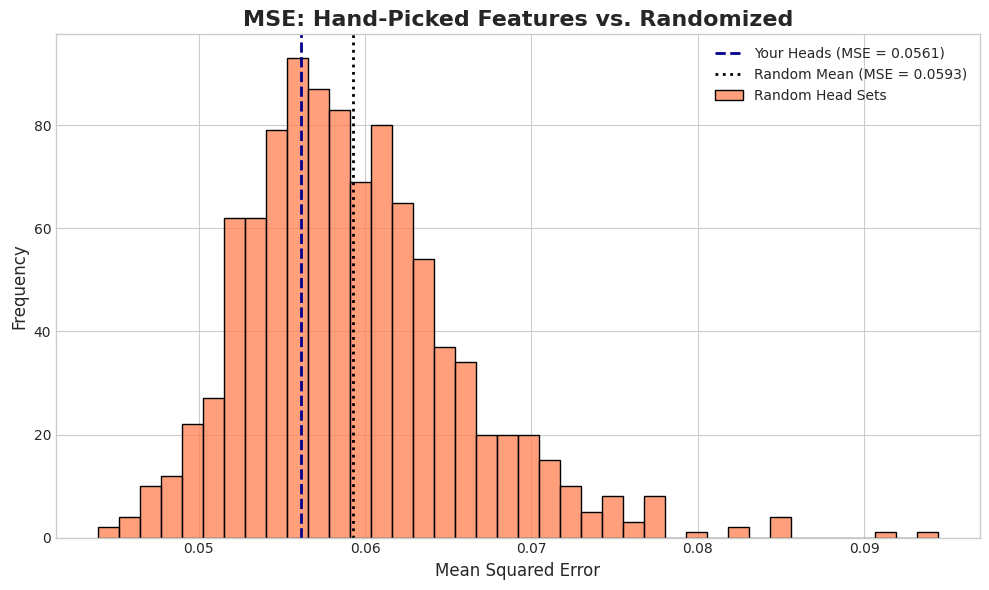


✅ Done.


In [7]:
import numpy as np
import os
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
TOP_FEATURES_PATH = "probe_features_top.npy"
LABELS_PATH = "probe_labels.npy"
PLOT_OUTPUT_PATH = "probe_mse_static_features.png"
NUM_TRIALS = 1000
RAND_FEATURE_TEMPLATE = "./probe_features/probe_features_rand_{:03d}.npy"

# --- Load Data ---
print("✅ Loading top features and labels...")
X = np.load(TOP_FEATURES_PATH)  # shape: [N, D]
y = np.load(LABELS_PATH)        # shape: [N]

print(f"📐 Feature shape: {X.shape}")
print(f"📊 Label shape:   {y.shape}")

# --- Train Ridge Regressor on Hand-Picked Heads ---
print("\n🎯 Training ridge regressor on your 10 selected heads...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

your_mse = mean_squared_error(y_test, y_pred)
print(f"🧠 MSE with hand-picked heads: {your_mse:.6f}")

# --- Evaluate MSE on Random Head Sets ---
print(f"\n🎲 Running {NUM_TRIALS} trials with real randomly sampled head sets...")
random_mse_list = []
missing_count = 0

for i in range(NUM_TRIALS):
    rand_path = RAND_FEATURE_TEMPLATE.format(i)
    if not os.path.exists(rand_path):
        print(f"⚠️ Missing file: {rand_path} — skipping.")
        missing_count += 1
        continue

    X_rand = np.load(rand_path)
    X_train, X_test, y_train, y_test = train_test_split(X_rand, y, test_size=0.2, random_state=42)

    model_rand = Ridge(alpha=1.0)
    model_rand.fit(X_train, y_train)
    y_pred_rand = model_rand.predict(X_test)

    mse = mean_squared_error(y_test, y_pred_rand)
    random_mse_list.append(mse)

if missing_count > 0:
    print(f"⚠️ Skipped {missing_count} trials due to missing files.")

# --- Metrics ---
random_mse_list = np.array(random_mse_list)
mean_random_mse = random_mse_list.mean()
percentile = np.mean(your_mse < random_mse_list) * 100

print("\n--- Results ---")
print(f"📌 Your MSE:         {your_mse:.6f}")
print(f"🎲 Mean Random MSE: {mean_random_mse:.6f}")
print(f"🏆 Percentile Rank:  {percentile:.1f}%")

# --- Plotting ---
print(f"\n📊 Saving plot to: {PLOT_OUTPUT_PATH}")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(random_mse_list, bins=40, color="coral", ax=ax, label="Random Head Sets")
ax.axvline(your_mse, color="darkblue", linestyle="--", linewidth=2,
           label=f"Your Heads (MSE = {your_mse:.4f})")
ax.axvline(mean_random_mse, color="black", linestyle=":", linewidth=2,
           label=f"Random Mean (MSE = {mean_random_mse:.4f})")

ax.set_title("MSE: Hand-Picked Features vs. Randomized", fontsize=16, fontweight="bold")
ax.set_xlabel("Mean Squared Error", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.legend()
fig.tight_layout()
plt.savefig(PLOT_OUTPUT_PATH)
plt.show()

print("\n✅ Done.")
